In [2]:
# ======================================================
# 📦 STEP 0: استيراد المكتبات
# ======================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [48]:
!pip install -q --upgrade "datasets>=2.21.0" "pyarrow==15.0.2"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 55.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.4 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibc

In [42]:
!pip install -q transformers datasets accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 43.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.


In [21]:
# ======================================================
# 🧾 STEP 1: تحميل ودمج ملفات البيانات الأصلية
# ======================================================
base_path = "/kaggle/input/fluent-speech-commands/fluent_speech_commands_dataset"
data_path = os.path.join(base_path, "data")

train_path = os.path.join(data_path, "train_data.csv")
valid_path = os.path.join(data_path, "valid_data.csv")
test_path  = os.path.join(data_path, "test_data.csv")

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df  = pd.read_csv(test_path)

# دمج كل الملفات ضمن DataFrame موحد
df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

print(" All CSVs loaded and merged successfully")
print(f"Total shape: {df.shape}")
print(df.head(3))


 All CSVs loaded and merged successfully
Total shape: (30043, 7)
   Unnamed: 0                                               path  \
0           0  wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...   
1           1  wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...   
2           2  wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...   

          speakerId       transcription           action  object location  
0  2BqVo8kVB2Skwgyb     Change language  change language    none     none  
1  2BqVo8kVB2Skwgyb              Resume         activate   music     none  
2  2BqVo8kVB2Skwgyb  Turn the lights on         activate  lights     none  


In [22]:
# ======================================================
# ✂️ STEP 2: Drop unnecessary columns
# ======================================================
# location → not needed for laptop-based system
# speakerId → optional (remove for simplicity)
columns_to_drop = ['location', 'speakerId']
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
valid_df = valid_df.drop(columns=columns_to_drop, errors='ignore')
test_df  = test_df.drop(columns=columns_to_drop, errors='ignore')

train_df = train_df.drop(columns=['Unnamed: 0'], errors='ignore')
valid_df = valid_df.drop(columns=['Unnamed: 0'], errors='ignore')
test_df  = test_df.drop(columns=['Unnamed: 0'], errors='ignore')

In [23]:

df = df.replace("none", pd.NA)
print(f" After removing invalid rows: {df.shape}")

 After removing invalid rows: (30043, 7)


In [24]:
def make_full(p):
    return os.path.join(base_path, p)

df["full_path"] = df["path"].apply(make_full)

print("\nFull path sample:")
df["full_path"].head()



Full path sample:


0    /kaggle/input/fluent-speech-commands/fluent_sp...
1    /kaggle/input/fluent-speech-commands/fluent_sp...
2    /kaggle/input/fluent-speech-commands/fluent_sp...
3    /kaggle/input/fluent-speech-commands/fluent_sp...
4    /kaggle/input/fluent-speech-commands/fluent_sp...
Name: full_path, dtype: object

In [25]:
def map_command(row):
    text = str(row["transcription"]).lower()

    if any(w in text for w in ["pause","stop","mute","quiet","silence"]):
        return "deactivate", "music"
    if any(w in text for w in ["resume","play","start","continue"]):
        return "activate", "music"

    if any(w in text for w in ["loud","up","increase","raise","higher"]):
        return "increase", "volume"
    if any(w in text for w in ["down","decrease","lower","reduce","softer"]):
        return "decrease", "volume"

    if "language" in text or "english" in text:
        return "change language", "English"

    if "light" in text:
        if "off" in text:
            return "deactivate", "lights"
        if "on" in text:
            return "activate", "lights"

    return row["action"], row["object"]


In [26]:
df[["action", "object"]] = df.apply(lambda r: pd.Series(map_command(r)), axis=1)


In [27]:
unwanted_objects = [
    "heat", "temperature", "lamp", "newspaper", "juice",
    "socks", "shoes", "German", "Korean", "Chinese"
]

df = df[~df["object"].isin(unwanted_objects)].reset_index(drop=True)


In [28]:
df['pair']=df['action']+' → '+df['object']
print(df['pair'].value_counts())

pair
increase → volume            7753
decrease → volume            6148
activate → lights            3615
change language → English    3064
deactivate → lights          2702
deactivate → music           1563
activate → music              912
Name: count, dtype: int64


In [29]:
print("\nUnique pairs BEFORE mapping:")
orig_pairs = (train_df["action"] + " → " + train_df["object"]).unique()
print(orig_pairs)



Unique pairs BEFORE mapping:
['change language → none' 'activate → music' 'activate → lights'
 'deactivate → lights' 'increase → volume' 'decrease → volume'
 'increase → heat' 'decrease → heat' 'deactivate → music'
 'activate → lamp' 'deactivate → lamp' 'bring → newspaper' 'bring → juice'
 'bring → socks' 'change language → Chinese' 'change language → Korean'
 'change language → English' 'change language → German' 'bring → shoes']


In [30]:
df["pair"] = df["action"] + " → " + df["object"]
print("\nUnique pairs AFTER mapping:")
print(df["pair"].unique())



Unique pairs AFTER mapping:
['change language → English' 'activate → music' 'activate → lights'
 'deactivate → lights' 'increase → volume' 'decrease → volume'
 'deactivate → music']


In [31]:
print("\nFinal distribution after mapping & cleaning:")
print(df["pair"].value_counts())



Final distribution after mapping & cleaning:
pair
increase → volume            7753
decrease → volume            6148
activate → lights            3615
change language → English    3064
deactivate → lights          2702
deactivate → music           1563
activate → music              912
Name: count, dtype: int64


In [32]:
os.makedirs("/kaggle/working/data_clean", exist_ok=True)
out_path = "/kaggle/working/data_clean/mapped_clean_ready.csv"
df.to_csv(out_path, index=False)
print("\nSaved to:", out_path)



Saved to: /kaggle/working/data_clean/mapped_clean_ready.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# ======================================================
# 📂 STEP 1: تحميل الملف بعد الـmapping والتنظيف
# ======================================================
DATA_PATH = "/kaggle/input/data-final/data_final/mapped_clean_ready_cleaned.csv"
df = pd.read_csv(DATA_PATH)

print("Loaded mapped & cleaned data")
print(f"Shape: {df.shape}")
print(df.head(3))

# إنشاء عمود للأزواج
df["pair"] = df["action"] + " → " + df["object"]
print("\nUnique pairs:", df["pair"].unique())

# ======================================================
# ✂️ STEP 2: تقسيم stratified حسب الأزواج
# ======================================================

# تقسيم أولي: Train (80%) - Temp (20%)
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["pair"], random_state=42
)

# تقسيم مؤقت: من الـ20% الباقية → 50/50 → 10% validation + 10% test
valid_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["pair"], random_state=42
)

# ======================================================
# 📊 STEP 3: التحقق من التوزيع
# ======================================================
def show_distribution(df, name):
    counts = df["pair"].value_counts(normalize=True).mul(100)
    print(f"\n{name} distribution (% per pair):")
    print(counts.round(2))

show_distribution(train_df, "Train")
show_distribution(valid_df, "Valid")
show_distribution(test_df, "Test")

print("\nSizes:")
print(f"Train: {len(train_df)} | Valid: {len(valid_df)} | Test: {len(test_df)}")

# ======================================================
# 💾 STEP 4: حفظ الملفات
# ======================================================
os.makedirs("/kaggle/working/data_splits", exist_ok=True)
train_df.to_csv("/kaggle/working/data_splits/train_split.csv", index=False)
valid_df.to_csv("/kaggle/working/data_splits/valid_split.csv", index=False)
test_df.to_csv("/kaggle/working/data_splits/test_split.csv", index=False)

print("Data successfully split and saved to /kaggle/working/data_splits/")


Loaded mapped & cleaned data
Shape: (14241, 5)
                                                path         transcription  \
0  wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...                Resume   
1  wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...    Turn the lights on   
2  wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-1...  Switch on the lights   

     action  object                                          full_path  
0  activate   music  /kaggle/input/fluent-speech-commands/fluent_sp...  
1  activate  lights  /kaggle/input/fluent-speech-commands/fluent_sp...  
2  activate  lights  /kaggle/input/fluent-speech-commands/fluent_sp...  

Unique pairs: ['activate → music' 'activate → lights' 'deactivate → lights'
 'increase → volume' 'decrease → volume' 'deactivate → music'
 'change language → English']

Train distribution (% per pair):
pair
activate → lights            25.39
increase → volume            22.88
deactivate → lights          18.97
decrease → volume            12.25


In [18]:
import os

missing = train_df[~train_df["full_path"].apply(os.path.exists)]
print("Missing files:", len(missing))
missing.head()


Missing files: 0


,path,transcription,action,object,full_path,pair


Current pair counts:
pair
activate → lights            2892
activate → music              730
change language → English     357
deactivate → lights          2161
deactivate → music           1250
decrease → volume            1395
increase → volume            2607
Name: count, dtype: int64


Augmenting weak pairs: 100%|██████████| 7/7 [00:45<00:00,  6.49s/it]



Augmented new samples: 913

Final pair counts after hybrid balancing:
pair
activate → lights            1500
activate → music             1000
change language → English    1000
deactivate → lights          1500
deactivate → music           1250
decrease → volume            1395
increase → volume            1500
Name: count, dtype: int64
Total samples: 9145

Saved to: /kaggle/working/data_balanced_final/train_hybrid_balanced.csv


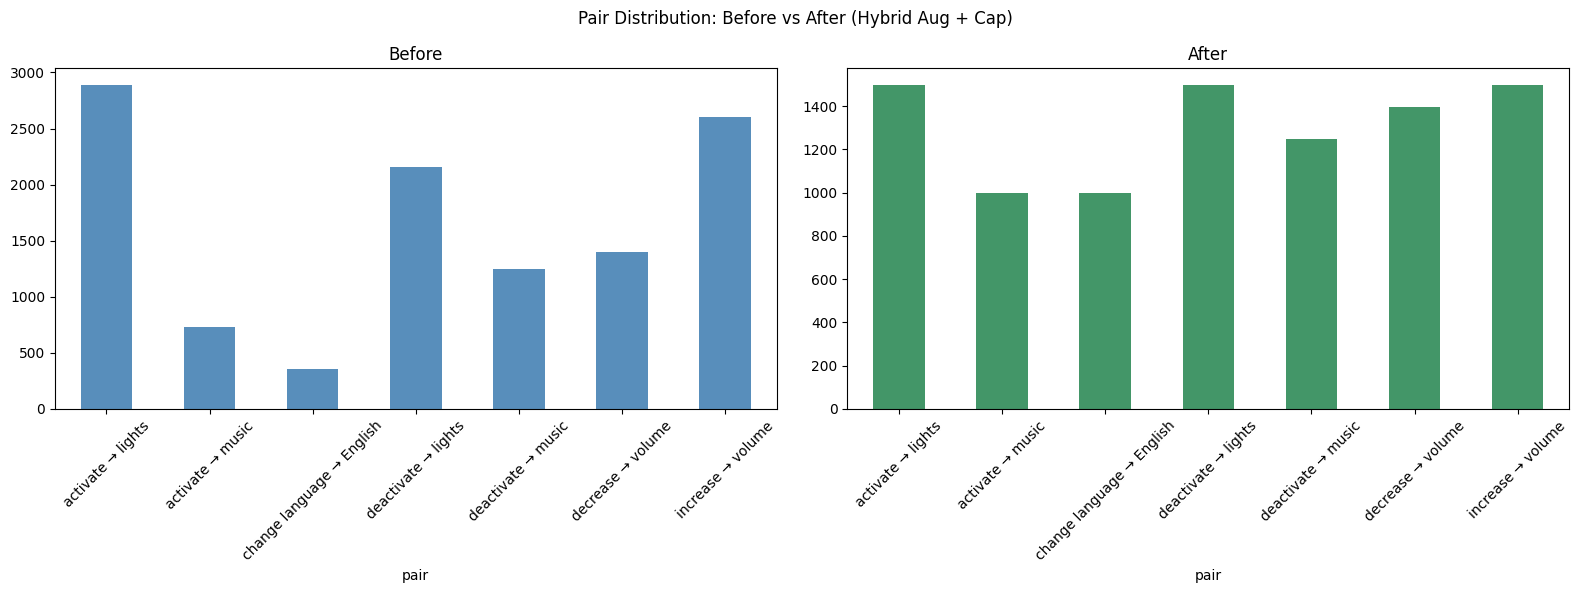

In [36]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================
# إعدادات المسارات
# =========================
BASE_DIR = "/kaggle/input/data-split2"
TRAIN_CSV = os.path.join(BASE_DIR, "train_split.csv")

AUG_DIR = "/kaggle/working/aug_pairs_hybrid"
OUT_DIR = "/kaggle/working/data_balanced_final"
os.makedirs(AUG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# تحميل بيانات التدريب
# =========================
train_df = pd.read_csv(TRAIN_CSV)
train_df["pair"] = train_df["action"].astype(str) + " → " + train_df["object"].astype(str)

# راقب التوزيع الحالي
print("Current pair counts:")
print(train_df["pair"].value_counts().sort_index())

# =========================
# حدود الخطة الهجينة
# عدّل القيم إذا لزم
# =========================
LOWER_TARGET = 1000   # الأزواج تحت هذا العدد سنرفعها بالـAug
UPPER_CAP    = 1500   # الأزواج فوق هذا العدد سنخفضها بالـdownsample

# =========================
# دالة Augmentation خفيفة
# =========================
def augment_audio(y, sr):
    y = y / (np.max(np.abs(y)) + 1e-8)
    if np.random.rand() < 0.45:
        y = np.roll(y, int(sr * np.random.uniform(-0.1, 0.1)))   # shift
    if np.random.rand() < 0.45:
        rate = np.random.uniform(0.9, 1.1)
        y = librosa.effects.time_stretch(y, rate=rate)            # speed
    if np.random.rand() < 0.35:
        steps = np.random.uniform(-1.0, 1.0)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)  # pitch
    if np.random.rand() < 0.35:
        noise = np.random.randn(len(y)) * np.random.uniform(0.001, 0.01)
        y = y + noise                                             # noise
    return y

# =========================
# 1) Aug للأزواج الصغيرة
# =========================
aug_rows = []
groups = list(train_df.groupby("pair"))
for pair_name, subset in tqdm(groups, desc="Augmenting weak pairs"):
    n = len(subset)
    if n >= LOWER_TARGET:
        continue
    diff = LOWER_TARGET - n
    # سحب بعينة مع إرجاع من نفس الزوج
    samples = subset.sample(n=diff, replace=True, random_state=42)

    for _, row in samples.iterrows():
        try:
            y, sr = librosa.load(row["full_path"], sr=None)
            y2 = augment_audio(y, sr)
            new_name = f"aug_{pair_name.replace(' ', '_').replace('→','to')}_{os.path.basename(row['full_path'])}"
            new_path = os.path.join(AUG_DIR, new_name)
            sf.write(new_path, y2, sr)
            new_row = row.copy()
            new_row["full_path"] = new_path
            new_row["is_aug"] = 1
            aug_rows.append(new_row)
        except Exception as e:
            # يمكنك الطباعة إذا رغبتِ
            pass

aug_df = pd.DataFrame(aug_rows)
print(f"\nAugmented new samples: {len(aug_df)}")

# =========================
# 2) دمج الأصل + المولّد
# =========================
if len(aug_df):
    merged = pd.concat([train_df, aug_df], ignore_index=True)
else:
    merged = train_df.copy()
merged["is_aug"] = merged.get("is_aug", 0)

# =========================
# 3) Downsample للأزواج الكبيرة
# =========================
final_parts = []
for pair_name, subset in merged.groupby("pair"):
    n = len(subset)
    if n > UPPER_CAP:
        # خفض إلى السقف العلوي
        keep = subset.sample(n=UPPER_CAP, random_state=42)
        final_parts.append(keep)
    else:
        final_parts.append(subset)

final_train = pd.concat(final_parts, ignore_index=True)
final_train = final_train.sample(frac=1, random_state=42).reset_index(drop=True)

# =========================
# حفظ وملخص
# =========================
out_csv = os.path.join(OUT_DIR, "train_hybrid_balanced.csv")
final_train.to_csv(out_csv, index=False)

print("\nFinal pair counts after hybrid balancing:")
print(final_train["pair"].value_counts().sort_index())
print("Total samples:", len(final_train))
print(f"\nSaved to: {out_csv}")

# =========================
# رسم للتوزيع قبل/بعد
# =========================
before_counts = train_df["pair"].value_counts().sort_index()
after_counts  = final_train["pair"].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Pair Distribution: Before vs After (Hybrid Aug + Cap)")

before_counts.plot.bar(ax=axes[0], color="steelblue", alpha=0.9)
axes[0].set_title("Before")
axes[0].tick_params(axis="x", rotation=45)

after_counts.plot.bar(ax=axes[1], color="seagreen", alpha=0.9)
axes[1].set_title("After")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


Before:
 pair
activate → lights            1500
activate → music             1000
change language → English    1000
deactivate → lights          1500
deactivate → music           1250
decrease → volume            1395
increase → volume            1500
Name: count, dtype: int64 
Total: 9145

Snap target = 1000

After:
 pair
activate → lights            1000
activate → music             1000
change language → English    1000
deactivate → lights          1000
deactivate → music           1000
decrease → volume            1000
increase → volume            1000
Name: count, dtype: int64 
Total: 7000


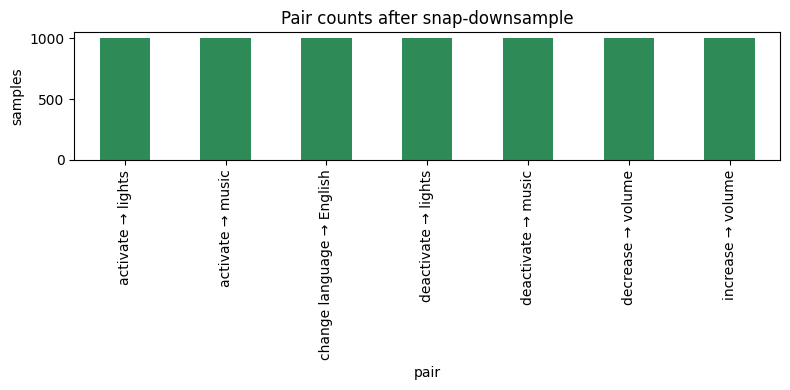

Saved: /kaggle/working/data_balanced_final/train_hybrid_balanced_down.csv


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# حمّلي ناتجك الحالي
path = "/kaggle/working/data_balanced_final/train_hybrid_balanced.csv"
df = pd.read_csv(path)

df["pair"] = df["action"] + " → " + df["object"]
counts = df["pair"].value_counts().sort_index()
print("Before:\n", counts, "\nTotal:", len(df))

# الهدف = أصغر زوج (ما منكرر ولا منعمل Aug)
target = counts.min()
print("\nSnap target =", target)

balanced = []
for p, g in df.groupby("pair"):
    if len(g) > target:
        balanced.append(g.sample(n=target, random_state=42))
    else:
        balanced.append(g)  # لو مساوي/أقل، منتركه (إذا أقل نبدّل الهدف لأصغر زوج فعلي)
df_bal = pd.concat(balanced, ignore_index=True)

# تحقّق ورسم
final_counts = df_bal["pair"].value_counts().sort_index()
print("\nAfter:\n", final_counts, "\nTotal:", len(df_bal))

ax = final_counts.plot.bar(color="seagreen", figsize=(8,4))
ax.set_title("Pair counts after snap-downsample")
ax.set_ylabel("samples"); ax.set_xlabel("pair")
plt.tight_layout(); plt.show()

# حفظ نسخة نهائية
out_path = "/kaggle/working/data_balanced_final/train_hybrid_balanced_down.csv"
df_bal.drop(columns=["pair"], errors="ignore").to_csv(out_path, index=False)
print("Saved:", out_path)


**__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________**

In [20]:
import pandas as pd

df = pd.read_csv("/kaggle/input/whisper-features/whisper_train.csv")

# نتأكد أن pair = action → object دائماً
mismatch = df.apply(
    lambda r: r["pair"] != f"{r['action']} → {r['object']}", axis=1
)

print("عدد الصفوف اللي فيها عدم تطابق pair مع action/object:", mismatch.sum())
df[mismatch].head()


عدد الصفوف اللي فيها عدم تطابق pair مع action/object: 4191


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f506,f507,f508,f509,f510,f511,action,object,pair,full_path
1001,0.042094,-0.215490,-0.745699,0.449643,-1.148982,0.288029,-1.095885,-0.076673,0.210182,0.083924,...,0.390668,-0.295263,-0.047672,0.064000,0.271319,0.544592,activate,music,NaN,/kaggle/input/fluent-speech-commands/fluent_sp...
1003,-0.033885,-0.207730,-0.905184,0.374580,-1.119008,0.318828,-1.036169,-0.001335,0.176163,0.001821,...,0.411310,-0.377852,0.009996,0.064706,0.044276,0.492017,activate,music,NaN,/kaggle/input/fluent-speech-commands/fluent_sp...
1006,-0.097282,-0.244565,-0.794836,0.419811,-1.028112,0.475399,-0.930461,-0.152551,0.162316,0.060740,...,0.516658,-0.433210,-0.025647,0.075728,0.132887,0.765054,activate,music,NaN,/kaggle/input/fluent-speech-commands/fluent_sp...
1009,-0.108824,-0.209785,-0.866842,0.366506,-1.021178,0.440248,-0.877295,-0.081556,0.154554,-0.061576,...,0.510794,-0.418444,-0.051047,0.025401,0.107851,0.654216,activate,music,NaN,/kaggle/input/fluent-speech-commands/fluent_sp...
1010,-0.024550,-0.099126,-0.751611,0.646884,-0.966534,0.464396,-0.944397,0.111155,0.008801,0.036132,...,0.431342,-0.514380,-0.081195,0.015400,0.317932,0.519273,activate,music,NaN,/kaggle/input/fluent-speech-commands/fluent_sp...


In [19]:
!pip install transformers torchaudio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [3]:
# =========================================
# 1️⃣ الاستيراد وتعريف الجهاز
# =========================================
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torchaudio
from tqdm import tqdm

from transformers import WhisperProcessor, WhisperForConditionalGeneration

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


2025-12-03 12:29:35.735705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764764975.907514      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764764975.953725      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [4]:
# =========================================
# 2️⃣ تحميل البيانات الأساسية + إضافة pair
#    (عدّلي المسارات حسب ملفاتك)
# =========================================

train_path = "/kaggle/input/traine-mapped-balance/train_hybrid_balanced_down (2).csv"
valid_path = "/kaggle/input/data-split2/valid_split.csv"
test_path  = "/kaggle/input/data-split2/test_split.csv"

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df  = pd.read_csv(test_path)

def prepare(df):
    df = df.copy()
    # يفترض أن الأعمدة action و object موجودة
    df["pair"] = df["action"] + " → " + df["object"]
    df["label_text"] = df["pair"]
    return df

train_df = prepare(train_df)
valid_df = prepare(valid_df)
test_df  = prepare(test_df)

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:",  test_df.shape)

# تأكدي أن full_path موجود في البيانات
print(train_df.columns)


Train: (7000, 8)
Valid: (1424, 7)
Test: (1425, 7)
Index(['path', 'transcription', 'action', 'object', 'full_path', 'is_aug',
       'pair', 'label_text'],
      dtype='object')


In [7]:
import os

# المسار الصحيح للـ aug داخل داتاست كاغل
AUG_BASE = "/kaggle/input/aug-pairs-hybird/aug_pairs_hybrid"

def fix_path(p):
    # إذا المسار القديم يشير إلى working → استبدله بالـ input
    if "/kaggle/working/aug_pairs_hybrid" in p:
        fname = os.path.basename(p)
        return os.path.join(AUG_BASE, fname)
    else:
        # الملفات الأصلية من fluent-speech-commands تبقى كما هي
        return p

for df in [train_df, valid_df, test_df]:
    df["full_path"] = df["full_path"].apply(fix_path)


In [8]:
print(train_df["full_path"].head())
print(os.path.exists(train_df["full_path"].iloc[0]))


0    /kaggle/input/fluent-speech-commands/fluent_sp...
1    /kaggle/input/fluent-speech-commands/fluent_sp...
2    /kaggle/input/fluent-speech-commands/fluent_sp...
3    /kaggle/input/fluent-speech-commands/fluent_sp...
4    /kaggle/input/fluent-speech-commands/fluent_sp...
Name: full_path, dtype: object
True


In [9]:
# 1) نتأكد ما في أي مسار قديم من working
for df, name in [(train_df, "train"), (valid_df, "valid"), (test_df, "test")]:
    bad = df["full_path"].str.contains("/kaggle/working/aug_pairs_hybrid")
    print(name, "rows with old working path:", bad.sum())


train rows with old working path: 0
valid rows with old working path: 0
test rows with old working path: 0


In [ ]:
# 2) نتأكد من المسارات المفقودة بعد التصحيح
for df, name in [(train_df, "train"), (valid_df, "valid"), (test_df, "test")]:
    missing = ~df["full_path"].apply(os.path.exists)
    print(name, "missing files after fix:", missing.sum())


train missing files after fix: 0
valid missing files after fix: 0


In [1]:
missing_mask = ~train_df["full_path"].apply(os.path.exists)
missing_paths = train_df.loc[missing_mask, "full_path"]

print("عدد المسارات المفقودة:", len(missing_paths))
missing_paths.head(20)


NameError: name 'train_df' is not defined

In [14]:
# =========================================
# 3️⃣ تجهيز مجلد إخراج الميزات (حذف القديم)
# =========================================
OUT_DIR = "/kaggle/working/features_whisper"

# حذف المجلد القديم إن وجد
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)
    print(f"Deleted old directory: {OUT_DIR}")

# إعادة إنشائه
os.makedirs(OUT_DIR, exist_ok=True)
print(f"Created directory: {OUT_DIR}")


Created directory: /kaggle/working/features_whisper


In [15]:
# =========================================
# 4️⃣ تحميل نموذج Whisper والـ Processor
# =========================================
MODEL_NAME = "openai/whisper-small"  # يمكنك تغييره إلى medium أو large إذا أردتِ

processor = WhisperProcessor.from_pretrained(MODEL_NAME)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()

print("Whisper model and processor loaded.")


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Whisper model and processor loaded.


In [14]:
# =========================================
# 5️⃣ دالة تحميل الصوت وتحويله إلى mono 16k
# =========================================
def load_mono_16k(path):
    waveform, sr = torchaudio.load(path)  # waveform: (channels, samples)

    # تحويل إلى قناة واحدة (mono) عند الحاجة
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # إعادة采样 إلى 16k إذا لم يكن كذلك
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
        waveform = resampler(waveform)
        sr = 16000

    # نرجع tensor بشكل (samples,)
    return waveform.squeeze(0)


In [15]:
# =========================================
# 6️⃣ دالة استخراج ميزات Whisper لمجموعة واحدة
# =========================================
def extract_whisper_embeddings(df, split_name):
    embeds, kept_idx = [], []
    short_count = 0

    for i, row in enumerate(tqdm(df.itertuples(), total=len(df), desc=f"Extracting {split_name}")):
        path = row.full_path  # يفترض وجود full_path في df
        if not os.path.exists(path):
            print(f" Skip (missing file): {path}")
            continue

        try:
            # تحميل الصوت وتحويله إلى 16k mono
            y = load_mono_16k(path)

            # تجهيز مدخلات Whisper
            inputs = processor(
                y.numpy(),
                sampling_rate=16000,
                return_tensors="pt",
                padding=True
            )
            input_features = inputs.input_features  # شكلها (1, 80, T)

            # معالجة الملفات القصيرة: padding إلى طول معيّن
            if input_features.shape[-1] < 3000:
                pad_len = 3000 - input_features.shape[-1]
                input_features = torch.nn.functional.pad(input_features, (0, pad_len))
                short_count += 1

            with torch.no_grad():
                encoder_out = model.get_encoder()(input_features.to(DEVICE))
                # المتوسط عبر البعد الزمني → embedding بواحد × 512 تقريباً
                pooled = encoder_out.last_hidden_state.mean(dim=1).cpu().numpy().squeeze()

            embeds.append(pooled)
            kept_idx.append(i)

            if i > 0 and i % 500 == 0:
                print(f"Processed {i}/{len(df)} files in {split_name}")

        except Exception as e:
            print(f" Skip {path}: {e}")
            continue

    if len(embeds) == 0:
        print(f"No embeddings extracted for {split_name}")
        return

    # تحويل قائمة embeddings إلى DataFrame
    embeds = np.vstack(embeds)
    feature_cols = [f"f{i}" for i in range(embeds.shape[1])]
    emb_df = pd.DataFrame(embeds, columns=feature_cols)

    # الأعمدة التعريفية (من نفس df الأصلي بالمؤشرات التي نجحت)
    emb_df["action"]    = df.iloc[kept_idx]["action"].values
    emb_df["object"]    = df.iloc[kept_idx]["object"].values
    emb_df["pair"]      = df.iloc[kept_idx]["pair"].values  # نستخدم pair الجاهز
    emb_df["full_path"] = df.iloc[kept_idx]["full_path"].values

    out_path = os.path.join(OUT_DIR, f"whisper_{split_name}.csv")
    emb_df.to_csv(out_path, index=False)

    print(f"Saved embeddings for {split_name}: {emb_df.shape}")
    print(f"File saved to: {out_path}")
    print(f"Short audio padded: {short_count}/{len(df)}\n")


In [16]:
# =========================================
# 7️⃣ تنفيذ الاستخراج لكل من train / valid / test
# =========================================
splits = {
    "train": train_df,
    "valid": valid_df,
    "test":  test_df
}

for split_name, df in splits.items():
    print(f"\n=== Processing {split_name} ===")
    print(df.shape)
    extract_whisper_embeddings(df, split_name)



=== Processing train ===
(7000, 8)


Extracting train:   7%|▋         | 502/7000 [01:04<13:48,  7.84it/s]

Processed 500/7000 files in train


Extracting train:  14%|█▍        | 1002/7000 [02:08<12:37,  7.92it/s]

Processed 1000/7000 files in train


Extracting train:  21%|██▏       | 1502/7000 [03:11<11:29,  7.97it/s]

Processed 1500/7000 files in train


Extracting train:  29%|██▊       | 2002/7000 [04:14<10:33,  7.89it/s]

Processed 2000/7000 files in train


Extracting train:  36%|███▌      | 2502/7000 [05:18<09:28,  7.92it/s]

Processed 2500/7000 files in train


Extracting train:  43%|████▎     | 3002/7000 [06:21<08:25,  7.91it/s]

Processed 3000/7000 files in train


Extracting train:  50%|█████     | 3502/7000 [07:26<07:33,  7.72it/s]

Processed 3500/7000 files in train


Extracting train:  57%|█████▋    | 4002/7000 [08:30<06:17,  7.94it/s]

Processed 4000/7000 files in train


Extracting train:  64%|██████▍   | 4502/7000 [09:33<05:19,  7.82it/s]

Processed 4500/7000 files in train


Extracting train:  71%|███████▏  | 5002/7000 [10:36<04:15,  7.83it/s]

Processed 5000/7000 files in train


Extracting train:  79%|███████▊  | 5502/7000 [11:40<03:08,  7.94it/s]

Processed 5500/7000 files in train


Extracting train:  86%|████████▌ | 6002/7000 [12:43<02:05,  7.96it/s]

Processed 6000/7000 files in train


Extracting train:  93%|█████████▎| 6502/7000 [13:47<01:02,  7.92it/s]

Processed 6500/7000 files in train


Extracting train: 100%|██████████| 7000/7000 [14:50<00:00,  7.86it/s]


Saved embeddings for train: (7000, 772)
File saved to: /kaggle/working/features_whisper/whisper_train.csv
Short audio padded: 7000/7000


=== Processing valid ===
(1424, 7)


Extracting valid:  35%|███▌      | 502/1424 [01:03<01:54,  8.05it/s]

Processed 500/1424 files in valid


Extracting valid:  70%|███████   | 1002/1424 [02:07<00:53,  7.86it/s]

Processed 1000/1424 files in valid


Extracting valid: 100%|██████████| 1424/1424 [03:01<00:00,  7.87it/s]


Saved embeddings for valid: (1424, 772)
File saved to: /kaggle/working/features_whisper/whisper_valid.csv
Short audio padded: 1424/1424


=== Processing test ===
(1425, 7)


Extracting test:  35%|███▌      | 502/1425 [01:03<01:59,  7.72it/s]

Processed 500/1425 files in test


Extracting test:  70%|███████   | 1002/1425 [02:07<00:54,  7.79it/s]

Processed 1000/1425 files in test


Extracting test: 100%|██████████| 1425/1425 [03:01<00:00,  7.86it/s]


Saved embeddings for test: (1425, 772)
File saved to: /kaggle/working/features_whisper/whisper_test.csv
Short audio padded: 1425/1425



# SVM

In [19]:
import pandas as pd

train = pd.read_csv("/kaggle/working/features_whisper/whisper_train.csv")
valid = pd.read_csv("/kaggle/working/features_whisper/whisper_valid.csv")
test  = pd.read_csv("/kaggle/working/features_whisper/whisper_test.csv")


In [20]:
num_cols = train.select_dtypes(include=[np.number]).columns

print("Numeric columns:", num_cols)

X_train = train[num_cols].values
y_train = train["pair"].values

X_valid = valid[num_cols].values
y_valid = valid["pair"].values

X_test  = test[num_cols].values
y_test  = test["pair"].values


Numeric columns: Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766',
       'f767'],
      dtype='object', length=768)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)


In [22]:
from sklearn.svm import SVC

svm_model = SVC(kernel="linear", C=1)
svm_model.fit(X_train_scaled, y_train)


SVC(C=1, kernel='linear')

In [23]:
from sklearn.metrics import accuracy_score, classification_report

valid_pred = svm_model.predict(X_valid_scaled)
print("Validation Accuracy:", accuracy_score(y_valid, valid_pred))
print(classification_report(y_valid, valid_pred))


Validation Accuracy: 0.9606741573033708
                           precision    recall  f1-score   support

        activate → lights       0.98      0.98      0.98       361
         activate → music       0.92      0.99      0.95        91
change language → English       1.00      1.00      1.00        45
      deactivate → lights       0.97      0.98      0.97       270
       deactivate → music       0.96      0.96      0.96       157
        decrease → volume       0.93      0.93      0.93       174
        increase → volume       0.96      0.94      0.95       326

                 accuracy                           0.96      1424
                macro avg       0.96      0.97      0.96      1424
             weighted avg       0.96      0.96      0.96      1424



In [26]:
import joblib

joblib.dump(svm_model, "/kaggle/working/svm_whisper_model.pkl")
print("Model saved.")


Model saved.


In [24]:
test_pred = svm_model.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, test_pred))


Test Accuracy: 0.9663157894736842


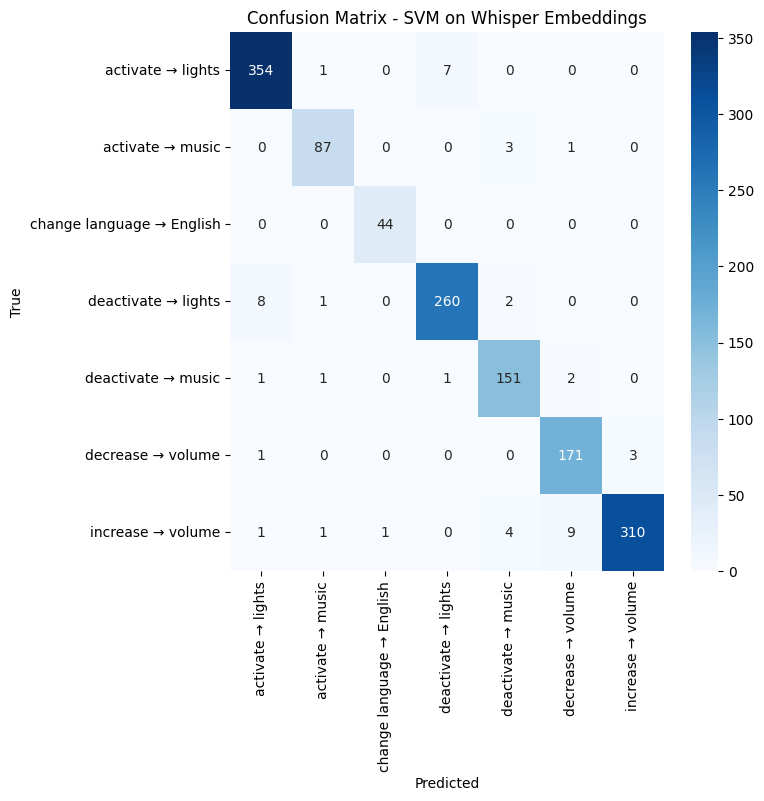

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# حساب المصفوفة
cm = confusion_matrix(y_test, test_pred, labels=svm_model.classes_)

plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=svm_model.classes_,
            yticklabels=svm_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM on Whisper Embeddings")
plt.show()


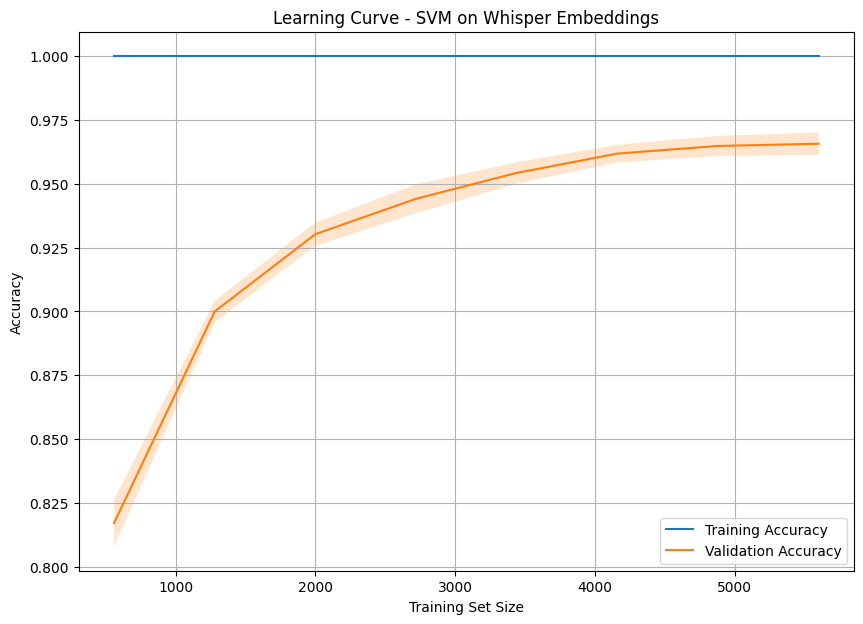

In [27]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# Pipeline: StandardScaler + SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel="rbf", C=10, gamma="scale"))
])

train_sizes, train_scores, valid_scores = learning_curve(
    svm_pipeline,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring="accuracy",
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std  = valid_scores.std(axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, valid_mean, label="Validation Accuracy")

plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.2)

plt.fill_between(train_sizes,
                 valid_mean - valid_std,
                 valid_mean + valid_std,
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - SVM on Whisper Embeddings")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# ------------------------------------------------
# تحميل الميزات (whisper_train/valid/test)
# ------------------------------------------------
train_path = "/kaggle/working/features_whisper/whisper_train.csv"
valid_path = "/kaggle/working/features_whisper/whisper_valid.csv"
test_path  = "/kaggle/working/features_whisper/whisper_test.csv"

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df  = pd.read_csv(test_path)

print(train_df.shape, valid_df.shape, test_df.shape)

# ------------------------------------------------
# اختيار الأعمدة الرقمية (الفيتشرات)
# ------------------------------------------------
num_cols = train_df.select_dtypes(include=[np.number]).columns
# استبعاد عمود الـ label لو كان رقمي
num_cols = [c for c in num_cols if c != "pair"]

X_train = train_df[num_cols].values
y_train = train_df["pair"].values

X_valid = valid_df[num_cols].values
y_valid = valid_df["pair"].values

X_test  = test_df[num_cols].values
y_test  = test_df["pair"].values

# ------------------------------------------------
# Standardization
# ------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------------------------
# نموذج Logistic Regression
# ------------------------------------------------
clf = LogisticRegression(
    max_iter=5000,
    multi_class="multinomial",
    solver="lbfgs"
)

clf.fit(X_train_scaled, y_train)

# ------------------------------------------------
# تقييم
# ------------------------------------------------
pred_valid = clf.predict(X_valid_scaled)
pred_test  = clf.predict(X_test_scaled)

print("\nValidation Accuracy:", accuracy_score(y_valid, pred_valid))
print("Validation F1:", f1_score(y_valid, pred_valid, average="macro"))

print("\nTest Accuracy:", accuracy_score(y_test, pred_test))
print("Test F1:", f1_score(y_test, pred_test, average="macro"))

print("\nClassification Report (Test):")
print(classification_report(y_test, pred_test))


(7000, 772) (1424, 772) (1425, 772)

Validation Accuracy: 0.9691011235955056
Validation F1: 0.9672948047325761

Test Accuracy: 0.9628070175438597
Test F1: 0.960934760244234

Classification Report (Test):
                           precision    recall  f1-score   support

        activate → lights       0.98      0.98      0.98       362
         activate → music       0.93      0.97      0.95        91
change language → English       0.98      0.98      0.98        44
      deactivate → lights       0.97      0.96      0.96       271
       deactivate → music       0.92      0.96      0.94       156
        decrease → volume       0.94      0.99      0.96       175
        increase → volume       0.98      0.94      0.96       326

                 accuracy                           0.96      1425
                macro avg       0.96      0.97      0.96      1425
             weighted avg       0.96      0.96      0.96      1425



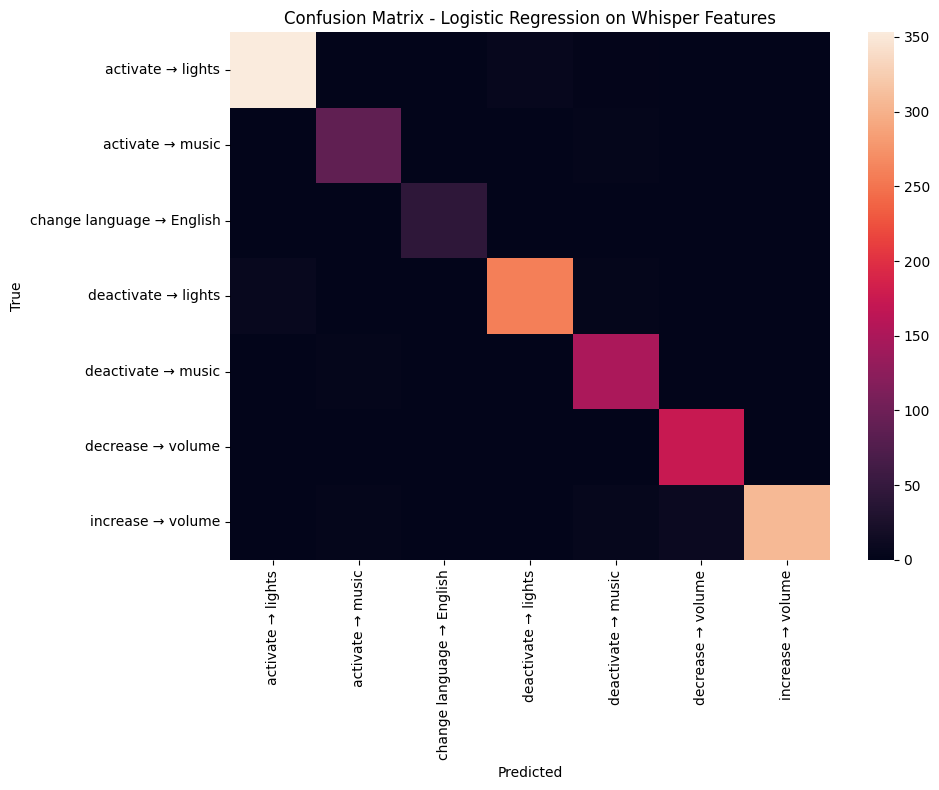

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import numpy as np

labels = sorted(np.unique(y_test))

cm = confusion_matrix(y_test, pred_test, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", 
            xticklabels=labels, 
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression on Whisper Features")
plt.tight_layout()
plt.show()


# Transecreption & whisper_audio 

In [7]:
# =========================================
# 0) الاستيرادات والإعدادات العامة
# =========================================
import os
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib

SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

# =========================================
# 1) تحميل الميتاداتا الأصلية + بناء عمود pair
# =========================================
train_meta_path = "/kaggle/input/traine-mapped-balance/train_hybrid_balanced_down (2).csv"
valid_meta_path = "/kaggle/input/data-split2/valid_split.csv"
test_meta_path  = "/kaggle/input/data-split2/test_split.csv"

train_meta = pd.read_csv(train_meta_path)
valid_meta = pd.read_csv(valid_meta_path)
test_meta  = pd.read_csv(test_meta_path)

# نبني pair بشكل نظيف 100% ونتجاهل أي pair قديم داخل الملفات
for df in [train_meta, valid_meta, test_meta]:
    df["pair"] = df["action"].astype(str) + " → " + df["object"].astype(str)

print("Train meta:", train_meta.shape)
print("Valid meta:", valid_meta.shape)
print("Test  meta:",  test_meta.shape)
print("Example pair (train_meta):", train_meta["pair"].iloc[0], type(train_meta["pair"].iloc[0]))

# =========================================
# 2) تحميل ميزات Whisper (صوت) من CSV
# =========================================
whisper_train_path = "/kaggle/input/features-whisper/whisper_train.csv"
whisper_valid_path = "/kaggle/input/features-whisper/whisper_valid.csv"
whisper_test_path  = "/kaggle/input/features-whisper/whisper_test.csv"

audio_train = pd.read_csv(whisper_train_path)
audio_valid = pd.read_csv(whisper_valid_path)
audio_test  = pd.read_csv(whisper_test_path)

print("Audio shapes (raw):", audio_train.shape, audio_valid.shape, audio_test.shape)

# تأكيد تطابق عدد الصفوف
assert train_meta.shape[0] == audio_train.shape[0], "Mismatch in train rows"
assert valid_meta.shape[0] == audio_valid.shape[0], "Mismatch in valid rows"
assert test_meta.shape[0]  == audio_test.shape[0],  "Mismatch in test rows"

# إعادة ضبط الفهارس للتأكد من اصطفاف الصفوف
audio_train = audio_train.reset_index(drop=True)
audio_valid = audio_valid.reset_index(drop=True)
audio_test  = audio_test.reset_index(drop=True)

train_meta = train_meta.reset_index(drop=True)
valid_meta = valid_meta.reset_index(drop=True)
test_meta  = test_meta.reset_index(drop=True)

# =========================================
# 3) بناء DataFrames جديدة نظيفة (صوت + نص)
# =========================================
cols_keep = ["transcription", "action", "object", "pair"]

train_df = pd.concat([train_meta[cols_keep], audio_train], axis=1)
valid_df = pd.concat([valid_meta[cols_keep], audio_valid], axis=1)
test_df  = pd.concat([test_meta[cols_keep],  audio_test],  axis=1)

# إزالة الأعمدة المكررة إن وجدت (action, object, pair مكررة من audio)
train_df = train_df.loc[:, ~train_df.columns.duplicated()]
valid_df = valid_df.loc[:, ~valid_df.columns.duplicated()]
test_df  = test_df.loc[:,  ~test_df.columns.duplicated()]

print("Final dfs:", train_df.shape, valid_df.shape, test_df.shape)
print("Example row train_df:\n", train_df.iloc[0])

# تأكيد أن pair نص عادي من نوع str
print("pair type in train_df:", type(train_df["pair"].iloc[0]))

# =========================================
# 4) بناء الـ Labels (1D) من الميتاداتا النظيفة
# =========================================
y_train = train_meta["pair"].astype(str).values
y_valid = valid_meta["pair"].astype(str).values
y_test  = test_meta["pair"].astype(str).values

print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)
print("y_test  shape:",  y_test.shape)

# =========================================
# 5) تمثيل النص: TF-IDF ثم SVD
# =========================================
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=1,
    max_features=20000
)

X_train_tfidf = vectorizer.fit_transform(train_df["transcription"])
X_valid_tfidf = vectorizer.transform(valid_df["transcription"])
X_test_tfidf  = vectorizer.transform(test_df["transcription"])

print("TF-IDF shapes:", X_train_tfidf.shape, X_valid_tfidf.shape, X_test_tfidf.shape)

joblib.dump(vectorizer, os.path.join(SAVE_DIR, "tfidf_vectorizer.pkl"))

# تقليل الأبعاد بالـ SVD
K = 32
print("\nRunning Fusion with Text SVD components =", K)

n_features_tfidf = X_train_tfidf.shape[1]
n_components = min(K, n_features_tfidf)
print(f"TF-IDF features = {n_features_tfidf}, using n_components = {n_components}")

svd = TruncatedSVD(n_components=n_components, random_state=42)

X_train_text = svd.fit_transform(X_train_tfidf)
X_valid_text = svd.transform(X_valid_tfidf)
X_test_text  = svd.transform(X_test_tfidf)

print("Text embedding shapes:", X_train_text.shape, X_valid_text.shape, X_test_text.shape)

joblib.dump(svd, os.path.join(SAVE_DIR, "svd_text.pkl"))

# =========================================
# 6) اختيار ميزات الصوت (الأعمدة الرقمية من Whisper)
# =========================================
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print("Total numeric cols:", len(numeric_cols))
print("Example numeric cols:", numeric_cols[:10])

X_train_audio = train_df[numeric_cols].values
X_valid_audio = valid_df[numeric_cols].values
X_test_audio  = test_df[numeric_cols].values

print("Audio shapes:", X_train_audio.shape, X_valid_audio.shape, X_test_audio.shape)
print("Text shapes :", X_train_text.shape,  X_valid_text.shape,  X_test_text.shape)

# =========================================
# 7) Fusion: دمج الصوت + النص بالـ concatenation
# =========================================
X_train_fused = np.concatenate([X_train_audio, X_train_text], axis=1)
X_valid_fused = np.concatenate([X_valid_audio, X_valid_text], axis=1)
X_test_fused  = np.concatenate([X_test_audio,  X_test_text],  axis=1)

print("Fused shapes:", X_train_fused.shape, X_valid_fused.shape, X_test_fused.shape)

# =========================================
# 8) Standardization + Logistic Regression (تصنيف الـ pair)
# =========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fused)
X_valid_scaled = scaler.transform(X_valid_fused)
X_test_scaled  = scaler.transform(X_test_fused)

joblib.dump(scaler, os.path.join(SAVE_DIR, "fusion_scaler.pkl"))

clf = LogisticRegression(
    max_iter=5000,
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train)

joblib.dump(clf, os.path.join(SAVE_DIR, "fusion_logreg_pair.pkl"))

# =========================================
# 9) التقييم على الـ validation و الـ test
# =========================================
pred_valid = clf.predict(X_valid_scaled)
pred_test  = clf.predict(X_test_scaled)

val_acc = accuracy_score(y_valid, pred_valid)
val_f1  = f1_score(y_valid, pred_valid, average="macro")
test_acc = accuracy_score(y_test, pred_test)
test_f1  = f1_score(y_test, pred_test, average="macro")

print("\n[K=32] Validation Accuracy:", val_acc)
print("[K=32] Validation F1:", val_f1)
print("[K=32] Test Accuracy:", test_acc)
print("[K=32] Test F1:", test_f1)

print(" Classification Report (Test):")
print(classification_report(y_test, pred_test))


Train meta: (7000, 7)
Valid meta: (1424, 6)
Test  meta: (1425, 6)
Example pair (train_meta): activate → lights <class 'str'>
Audio shapes (raw): (7000, 772) (1424, 772) (1425, 772)
Final dfs: (7000, 773) (1424, 773) (1425, 773)
Example row train_df:
 transcription                        Switch on the washroom lights
action                                                    activate
object                                                      lights
pair                                             activate → lights
f0                                                       -0.326775
                                       ...                        
f764                                                      0.813519
f765                                                     -0.021596
f766                                                     -0.412283
f767                                                     -0.217689
full_path        /kaggle/input/fluent-speech-commands/fluent_sp...
Name: 0, Len

In [8]:
train_paths = set(train_df["full_path"].values)
test_paths  = set(test_df["full_path"].values)

intersection = train_paths.intersection(test_paths)
print("Overlap between train and test:", len(intersection))


Overlap between train and test: 0


In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, pred_test, labels=np.unique(y_test))
print("Confusion matrix shape:", cm.shape)

# عرض بعض الأخطاء
errors_idx = np.where(pred_test != y_test)[0]
print("Number of errors:", len(errors_idx))

for i in errors_idx[:10]:  # لو في أخطاء
    print("----")
    print("Transcription:", test_df["transcription"].iloc[i])
    print("True pair   :", y_test[i])
    print("Pred pair   :", pred_test[i])


Confusion matrix shape: (7, 7)
Number of errors: 2
----
Transcription: Turn off the music
True pair   : deactivate → music
Pred pair   : deactivate → lights
----
Transcription: Switch off the washroom lights
True pair   : deactivate → lights
Pred pair   : activate → music


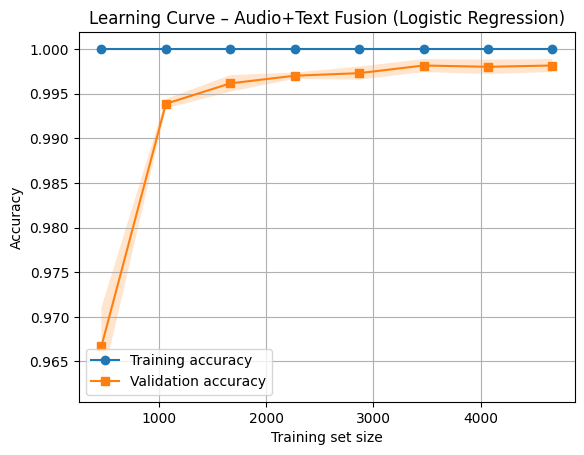

In [10]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# 1) تعريف Pipeline (scaler + logistic regression)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=5000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])

# 2) حساب منحنى التعلم
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=pipe,
    X=X_train_fused,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),  # 8 نقاط من 10% إلى 100% من بيانات التدريب
    cv=3,                                   # 3-fold cross-validation
    scoring="accuracy",
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# 3) حساب المتوسط والانحراف المعياري عبر الـ folds
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std  = valid_scores.std(axis=1)

# 4) رسم منحنى التعلم
plt.figure()
plt.plot(train_sizes, train_mean, marker="o", label="Training accuracy")
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.2)

plt.plot(train_sizes, valid_mean, marker="s", label="Validation accuracy")
plt.fill_between(train_sizes,
                 valid_mean - valid_std,
                 valid_mean + valid_std,
                 alpha=0.2)

plt.title("Learning Curve – Audio+Text Fusion (Logistic Regression)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


Confusion matrix shape: (7, 7)


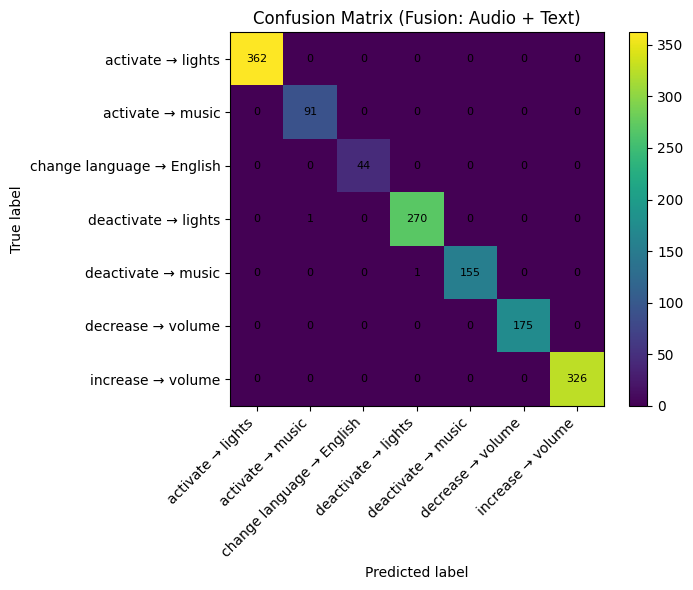

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ------------------------------------------------
# 1) إعادة حساب التنبؤات على test (احتياطاً)
# ------------------------------------------------
pred_test = clf.predict(X_test_scaled)

# ترتيب الكلاسات (نفس ترتيب التقرير السابق)
class_names = [
    "activate → lights",
    "activate → music",
    "change language → English",
    "deactivate → lights",
    "deactivate → music",
    "decrease → volume",
    "increase → volume",
]

# ------------------------------------------------
# 2) مصفوفة الالتباس الخام + المطبّعة
# ------------------------------------------------
cm = confusion_matrix(y_test, pred_test, labels=class_names)
cm_norm = confusion_matrix(y_test, pred_test, labels=class_names, normalize="true")

print("Confusion matrix shape:", cm.shape)

# ------------------------------------------------
# 3) رسم مصفوفة الالتباس (قيم حقيقية)
# ------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix (Fusion: Audio + Text)")
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

# إظهار الأرقام داخل الخلايا
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            str(cm[i, j]),
            ha="center", va="center",
            fontsize=8,
        )

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [7]:
!pip install -q openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 10.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8

In [5]:
!apt-get update && apt-get install -y ffmpeg


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,598 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,961 kB]
Get:13 https://cl

In [14]:
import os
import whisper
import numpy as np
import pandas as pd
import joblib
import librosa

# تحميل النماذج التي صدّرتيها من Kaggle
vectorizer = joblib.load("/kaggle/input/results/tfidf_vectorizer.pkl")
svd        = joblib.load("/kaggle/input/results/svd_text.pkl")
scaler     = joblib.load("/kaggle/input/results/fusion_scaler.pkl")
clf        = joblib.load("/kaggle/input/results/fusion_logreg_pair.pkl")

# تحميل Whisper
model = whisper.load_model("small")  # أو "base" لو بطيء

# جذر ملفات الصوت عندك محلياً (عدّلي هذا المسار حسب مكان الداتا)
DATA_ROOT = r"/kaggle/input/fluent-speech-commands/fluent_speech_commands_dataset"

# تحميل مثلاً test_split.csv
meta_test = pd.read_csv("/kaggle/input/data-split2/test_split.csv")  # ملف الميتاداتا عندك محلياً

def extract_whisper_features(audio_path):
    audio, sr = librosa.load(audio_path, sr=16000)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).numpy().flatten()

    # نفس البعد اللي درّبتي عليه (768)
    if len(mel) < 768:
        mel = np.pad(mel, (0, 768 - len(mel)))
    else:
        mel = mel[:768]

    return mel.reshape(1, -1)

def predict_intent(audio_path):
    # 1) تحويل الصوت إلى نص
    result = model.transcribe(audio_path, fp16=False)
    text = result["text"].strip()

    # 2) تحويل النص إلى embedding
    X_tfidf = vectorizer.transform([text])
    X_text = svd.transform(X_tfidf)

    # 3) استخراج ميزات الصوت
    X_audio = extract_whisper_features(audio_path)

    # 4) Fusion + Scaling
    X_fused  = np.concatenate([X_audio, X_text], axis=1)
    X_scaled = scaler.transform(X_fused)

    # 5) التنبؤ
    pred = clf.predict(X_scaled)[0]
    return text, pred

# تجربة على أول صف من test_split.csv
i = 5
rel_path = meta_test["path"].iloc[i]  # أو "full_path" حسب ملفك
audio_file = os.path.join(DATA_ROOT, rel_path)

text, intent = predict_intent(audio_file)

print("Audio file:", audio_file)
print("Transcription (Whisper):", text)
print("Predicted Intent:", intent)
print("True pair:", meta_test["action"].iloc[i] + " → " + meta_test["object"].iloc[i])


Audio file: /kaggle/input/fluent-speech-commands/fluent_speech_commands_dataset/wavs/speakers/7B4XmNppyrCK977p/e5317430-45c8-11e9-8ec0-7bf21d1cfe30.wav
Transcription (Whisper): Turn off the music.
Predicted Intent: change language → English
True pair: deactivate → music


In [7]:
from IPython.display import Audio

audio_path = "/kaggle/input/fluent-speech-commands/fluent_speech_commands_dataset/wavs/speakers/mj4BWeRbp7ildyB9d/92fd6840-4528-11e9-a843-8db76f4b5e29.wav"

Audio(filename=audio_path)


In [9]:
# نفس المتغيرات الموجودة من الكود السابق:
# vectorizer, svd, scaler, clf, numeric_cols, test_df

i = 0  # جرّبي أي رقم من 0 إلى len(test_df)-1

sentence   = test_df["transcription"].iloc[i]
true_label = test_df["pair"].iloc[i]

print("Sentence:", sentence)
print("True pair:", true_label)

# 1) تمثيل نصي للجملة
X_text = vectorizer.transform([sentence])          # TF-IDF
X_text = svd.transform(X_text)                    # SVD => (1, K)

# 2) ميزات الصوت لنفس العينة
audio_feat = test_df[numeric_cols].iloc[i].values.reshape(1, -1)

# 3) Fusion + Scaling
X_fused  = np.concatenate([audio_feat, X_text], axis=1)
X_scaled = scaler.transform(X_fused)

# 4) التنبؤ
pred = clf.predict(X_scaled)[0]

print("Predicted pair:", pred)


Sentence: Make it louder
True pair: increase → volume
Predicted pair: increase → volume


In [10]:
for i in [0, 10, 50, 123, 400]:
    sentence   = test_df["transcription"].iloc[i]
    true_label = test_df["pair"].iloc[i]

    # نص
    X_text = vectorizer.transform([sentence])
    X_text = svd.transform(X_text)

    # صوت
    audio_feat = test_df[numeric_cols].iloc[i].values.reshape(1, -1)

    # دمج + scaling
    X_fused  = np.concatenate([audio_feat, X_text], axis=1)
    X_scaled = scaler.transform(X_fused)

    pred = clf.predict(X_scaled)[0]

    print("-" * 40)
    print("i:", i)
    print("Sentence:", sentence)
    print("True pair:", true_label)
    print("Predicted pair:", pred)


----------------------------------------
i: 0
Sentence: Make it louder
True pair: increase → volume
Predicted pair: increase → volume
----------------------------------------
i: 10
Sentence: Turn the bedroom lights off
True pair: deactivate → lights
Predicted pair: deactivate → lights
----------------------------------------
i: 50
Sentence: Quieter
True pair: deactivate → music
Predicted pair: deactivate → music
----------------------------------------
i: 123
Sentence: Turn the bedroom lights on
True pair: activate → lights
Predicted pair: activate → lights
----------------------------------------
i: 400
Sentence: Set my phone's language to English
True pair: change language → English
Predicted pair: change language → English


# Extract Whisper_text

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import whisper

# -----------------------------
# 1) تحميل الميتاداتا الأصلية
# -----------------------------
train_meta_path = "/kaggle/input/traine-mapped-balance/train_hybrid_balanced_down (2).csv"
valid_meta_path = "/kaggle/input/data-split2/valid_split.csv"
test_meta_path  = "/kaggle/input/data-split2/test_split.csv"

train_meta = pd.read_csv(train_meta_path)
valid_meta = pd.read_csv(valid_meta_path)
test_meta  = pd.read_csv(test_meta_path)

# نبني pair من جديد (ضماناً)
for df in [train_meta, valid_meta, test_meta]:
    df["pair"] = df["action"].astype(str) + " → " + df["object"].astype(str)

print("Train meta:", train_meta.shape)
print("Valid meta:", valid_meta.shape)
print("Test  meta:", test_meta.shape)

# -----------------------------
# 2) إصلاح full_path (للـ aug)
# -----------------------------
AUG_BASE = "/kaggle/input/aug-pairs-hybird/aug_pairs_hybrid"

def fix_path(p):
    if isinstance(p, str) and "/kaggle/working/aug_pairs_hybrid" in p:
        fname = os.path.basename(p)
        return os.path.join(AUG_BASE, fname)
    return p

for df in [train_meta, valid_meta, test_meta]:
    df["full_path"] = df["full_path"].apply(fix_path)

# -----------------------------
# 3) تحميل Whisper model
# -----------------------------
model = whisper.load_model("small")   # غيّريها لـ "base" لو حابة أسرع

# -----------------------------
# 4) دالة تضيف عمود whisper_text
#    مع كاش بسيط لكل ملف صوت
# -----------------------------
def add_whisper_text(df, model, split_name, cache_dir="/kaggle/working/whisper_text_cache"):
    os.makedirs(cache_dir, exist_ok=True)
    texts = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Transcribing {split_name}"):
        audio_path = row["full_path"]

        # اسم ملف الكاش على أساس اسم ملف الصوت
        base = os.path.basename(audio_path)
        base_no_ext = os.path.splitext(base)[0]
        cache_path = os.path.join(cache_dir, base_no_ext + ".txt")

        if os.path.exists(cache_path):
            with open(cache_path, "r", encoding="utf-8") as f:
                txt = f.read().strip()
        else:
            # Transcribe بالصوت الحقيقي
            result = model.transcribe(audio_path, fp16=False)
            txt = result["text"].strip()
            with open(cache_path, "w", encoding="utf-8") as f:
                f.write(txt)

        texts.append(txt)

    df = df.copy()
    df["whisper_text"] = texts
    return df

# -----------------------------
# 5) توليد whisper_text لكل split
# -----------------------------
train_meta_w = add_whisper_text(train_meta, model, "train")
valid_meta_w = add_whisper_text(valid_meta, model, "valid")
test_meta_w  = add_whisper_text(test_meta,  model, "test")

print("Train with whisper_text:", train_meta_w.shape)
print("Valid with whisper_text:", valid_meta_w.shape)
print("Test  with whisper_text:", test_meta_w.shape)

# -----------------------------
# 6) حفظ الميتاداتا الجديدة
# -----------------------------
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

train_meta_w.to_csv(os.path.join(SAVE_DIR, "train_meta_whisper_text.csv"), index=False)
valid_meta_w.to_csv(os.path.join(SAVE_DIR, "valid_meta_whisper_text.csv"), index=False)
test_meta_w.to_csv(os.path.join(SAVE_DIR, "test_meta_whisper_text.csv"), index=False)

print("Saved meta files with whisper_text in:", SAVE_DIR)


Train meta: (7000, 7)
Valid meta: (1424, 6)
Test  meta: (1425, 6)


Transcribing test:  73%|███████▎  | 1047/1425 [10:13<02:59,  2.10it/s] 

# Fusion(Whisper_audio & Whisper_text)

In [15]:
# =========================================
# 0) الاستيرادات والإعدادات العامة
# =========================================
import os
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib

SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

# =========================================
# 1) تحميل الميتاداتا الجديدة التي تحتوي whisper_text + بناء pair
# =========================================
train_meta_path = "/kaggle/input/whisper-text/train_meta_whisper_text.csv"
valid_meta_path = "/kaggle/input/whisper-text/valid_meta_whisper_text.csv"
test_meta_path  = "/kaggle/input/whisper-text/test_meta_whisper_text.csv"

train_meta = pd.read_csv(train_meta_path)
valid_meta = pd.read_csv(valid_meta_path)
test_meta  = pd.read_csv(test_meta_path)

# pair جاهزة في الملفات، لكن نعيد بنائها لضمان صحتها
for df in [train_meta, valid_meta, test_meta]:
    df["pair"] = df["action"].astype(str) + " → " + df["object"].astype(str)

print("Train meta:", train_meta.shape)
print("Valid meta:", valid_meta.shape)
print("Test  meta:",  test_meta.shape)
print("Example whisper_text:", train_meta["whisper_text"].iloc[0])

# =========================================
# 2) تحميل ميزات Whisper (صوت) من CSV
# =========================================
whisper_train_path = "/kaggle/input/features-whisper/whisper_train.csv"
whisper_valid_path = "/kaggle/input/features-whisper/whisper_valid.csv"
whisper_test_path  = "/kaggle/input/features-whisper/whisper_test.csv"

audio_train = pd.read_csv(whisper_train_path)
audio_valid = pd.read_csv(whisper_valid_path)
audio_test  = pd.read_csv(whisper_test_path)

print("Audio shapes (raw):", audio_train.shape, audio_valid.shape, audio_test.shape)

# تأكيد تطابق عدد الصفوف
assert train_meta.shape[0] == audio_train.shape[0], "Mismatch in train rows"
assert valid_meta.shape[0] == audio_valid.shape[0], "Mismatch in valid rows"
assert test_meta.shape[0]  == audio_test.shape[0],  "Mismatch in test rows"

# إعادة ضبط الفهارس للتأكد من الاصطفاف
train_meta = train_meta.reset_index(drop=True)
valid_meta = valid_meta.reset_index(drop=True)
test_meta  = test_meta.reset_index(drop=True)

audio_train = audio_train.reset_index(drop=True)
audio_valid = audio_valid.reset_index(drop=True)
audio_test  = audio_test.reset_index(drop=True)

# =========================================
# 3) بناء DataFrames جديدة نظيفة (صوت + whisper_text)
# =========================================
cols_keep = ["whisper_text", "action", "object", "pair"]

train_df = pd.concat([train_meta[cols_keep], audio_train], axis=1)
valid_df = pd.concat([valid_meta[cols_keep], audio_valid], axis=1)
test_df  = pd.concat([test_meta[cols_keep],  audio_test],  axis=1)

# إزالة أي أعمدة مكررة
train_df = train_df.loc[:, ~train_df.columns.duplicated()]
valid_df = valid_df.loc[:, ~valid_df.columns.duplicated()]
test_df  = test_df.loc[:,  ~test_df.columns.duplicated()]

print("Final dfs:", train_df.shape, valid_df.shape, test_df.shape)

# =========================================
# 4) بناء الـ Labels (1D)
# =========================================
y_train = train_df["pair"].astype(str).values
y_valid = valid_df["pair"].astype(str).values
y_test  = test_df["pair"].astype(str).values

print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)
print("y_test  shape:",  y_test.shape)

# =========================================
# 5) تمثيل النص: TF-IDF على whisper_text ثم SVD
# =========================================
text_col = "whisper_text"

# تنظيف النصوص
train_df[text_col] = train_df[text_col].fillna("").astype(str)
valid_df[text_col] = valid_df[text_col].fillna("").astype(str)
test_df[text_col]  = test_df[text_col].fillna("").astype(str)

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=1,
    max_features=20000
)

X_train_tfidf = vectorizer.fit_transform(train_df[text_col])
X_valid_tfidf = vectorizer.transform(valid_df[text_col])
X_test_tfidf  = vectorizer.transform(test_df[text_col])

print("TF-IDF shapes:", X_train_tfidf.shape, X_valid_tfidf.shape, X_test_tfidf.shape)

joblib.dump(vectorizer, os.path.join(SAVE_DIR, "tfidf_vectorizer_text.pkl"))

# تقليل الأبعاد بالـ SVD
K = 8
print("\nRunning Fusion with Text SVD components =", K)

n_features_tfidf = X_train_tfidf.shape[1]
n_components = min(K, n_features_tfidf)

svd = TruncatedSVD(n_components=n_components, random_state=42)

X_train_text = svd.fit_transform(X_train_tfidf)
X_valid_text = svd.transform(X_valid_tfidf)
X_test_text  = svd.transform(X_test_tfidf)

print("Text embedding shapes:", X_train_text.shape, X_valid_text.shape, X_test_text.shape)

joblib.dump(svd, os.path.join(SAVE_DIR, "svd_text.pkl"))

# =========================================
# 6) اختيار ميزات الصوت (الأعمدة الرقمية من Whisper)
# =========================================
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

print("Total numeric cols:", len(numeric_cols))
print("Example numeric cols:", numeric_cols[:10])

X_train_audio = train_df[numeric_cols].values
X_valid_audio = valid_df[numeric_cols].values
X_test_audio  = test_df[numeric_cols].values

print("Audio shapes:", X_train_audio.shape, X_valid_audio.shape, X_test_audio.shape)
print("Text shapes :", X_train_text.shape,  X_valid_text.shape,  X_test_text.shape)

# =========================================
# 7) Fusion: دمج الصوت + النص
# =========================================
X_train_fused = np.concatenate([X_train_audio, X_train_text], axis=1)
X_valid_fused = np.concatenate([X_valid_audio, X_valid_text], axis=1)
X_test_fused  = np.concatenate([X_test_audio,  X_test_text],  axis=1)

print("Fused shapes:", X_train_fused.shape, X_valid_fused.shape, X_test_fused.shape)

# =========================================
# 8) Standardization + Logistic Regression
# =========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fused)
X_valid_scaled = scaler.transform(X_valid_fused)
X_test_scaled  = scaler.transform(X_test_fused)

joblib.dump(scaler, os.path.join(SAVE_DIR, "fusion_scaler_text.pkl"))

clf = LogisticRegression(
    max_iter=5000,
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train)

joblib.dump(clf, os.path.join(SAVE_DIR, "fusion_logreg_pair_text.pkl"))

# =========================================
# 9) التقييم
# =========================================
pred_valid = clf.predict(X_valid_scaled)
pred_test  = clf.predict(X_test_scaled)

val_acc = accuracy_score(y_valid, pred_valid)
val_f1  = f1_score(y_valid, pred_valid, average="macro")
test_acc = accuracy_score(y_test, pred_test)
test_f1  = f1_score(y_test, pred_test, average="macro")

print("\n[K=32] Validation Accuracy:", val_acc)
print("[K=32] Validation F1:", val_f1)
print("[K=32] Test Accuracy:", test_acc)
print("[K=32] Test F1:", test_f1)

print("\nClassification Report (Test):")
print(classification_report(y_test, pred_test))


Train meta: (7000, 8)
Valid meta: (1424, 7)
Test  meta: (1425, 7)
Example whisper_text: Switch on the washroom lights.
Audio shapes (raw): (7000, 772) (1424, 772) (1425, 772)
Final dfs: (7000, 773) (1424, 773) (1425, 773)
y_train shape: (7000,)
y_valid shape: (1424,)
y_test  shape: (1425,)
TF-IDF shapes: (7000, 2705) (1424, 2705) (1425, 2705)

Running Fusion with Text SVD components = 8
Text embedding shapes: (7000, 8) (1424, 8) (1425, 8)
Total numeric cols: 768
Example numeric cols: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
Audio shapes: (7000, 768) (1424, 768) (1425, 768)
Text shapes : (7000, 8) (1424, 8) (1425, 8)
Fused shapes: (7000, 776) (1424, 776) (1425, 776)

[K=32] Validation Accuracy: 0.9754213483146067
[K=32] Validation F1: 0.9748655795508044
[K=32] Test Accuracy: 0.9691228070175438
[K=32] Test F1: 0.9698813803245706

Classification Report (Test):
                           precision    recall  f1-score   support

        activate → lights       0.98      

In [20]:
import numpy as np
import pandas as pd

# اقرأ ميزات الصوت من ملفات whisper_*.csv (هذه يجب أن تكون رقمية)
audio_train = pd.read_csv("/kaggle/input/features-whisper/whisper_train.csv")
audio_valid = pd.read_csv("/kaggle/input/features-whisper/whisper_valid.csv")
audio_test  = pd.read_csv("/kaggle/input/features-whisper/whisper_test.csv")

# خذي الأعمدة الرقمية فقط (احتياطاً)
audio_cols = audio_train.select_dtypes(include=[np.number]).columns.tolist()

print("Audio numeric cols:", len(audio_cols))
print("Example:", audio_cols[:10])

X_train_audio = audio_train[audio_cols].to_numpy(dtype=np.float32)
X_valid_audio = audio_valid[audio_cols].to_numpy(dtype=np.float32)
X_test_audio  = audio_test[audio_cols].to_numpy(dtype=np.float32)

print("X_audio shapes:", X_train_audio.shape, X_valid_audio.shape, X_test_audio.shape)


Audio numeric cols: 768
Example: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
X_audio shapes: (7000, 768) (1424, 768) (1425, 768)


In [21]:
def train_eval_fusion_text(
    train_text, valid_text, test_text,
    X_train_audio, X_valid_audio, X_test_audio,
    y_train, y_valid, y_test,
    K=32, max_features=20000, name_prefix="exp"
):
    # تنظيف النصوص من NaN
    train_text = pd.Series(train_text).fillna("").astype(str).values
    valid_text = pd.Series(valid_text).fillna("").astype(str).values
    test_text  = pd.Series(test_text).fillna("").astype(str).values

    # TF-IDF (fit على train فقط)
    vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_features=max_features)
    X_train_tfidf = vectorizer.fit_transform(train_text)
    X_valid_tfidf = vectorizer.transform(valid_text)
    X_test_tfidf  = vectorizer.transform(test_text)

    # SVD
    n_components = min(K, X_train_tfidf.shape[1])
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_train_text = svd.fit_transform(X_train_tfidf)
    X_valid_text = svd.transform(X_valid_tfidf)
    X_test_text  = svd.transform(X_test_tfidf)

    # Fusion
    X_train_fused = np.concatenate([X_train_audio, X_train_text], axis=1)
    X_valid_fused = np.concatenate([X_valid_audio, X_valid_text], axis=1)
    X_test_fused  = np.concatenate([X_test_audio,  X_test_text],  axis=1)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fused)
    X_valid_scaled = scaler.transform(X_valid_fused)
    X_test_scaled  = scaler.transform(X_test_fused)

    # Classifier
    clf = LogisticRegression(
        max_iter=5000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    )
    clf.fit(X_train_scaled, y_train)

    # Predict
    pred_valid = clf.predict(X_valid_scaled)
    pred_test  = clf.predict(X_test_scaled)

    metrics = {
        "val_acc": accuracy_score(y_valid, pred_valid),
        "val_f1":  f1_score(y_valid, pred_valid, average="macro"),
        "test_acc": accuracy_score(y_test, pred_test),
        "test_f1":  f1_score(y_test, pred_test, average="macro"),
        "pred_valid": pred_valid,
        "pred_test": pred_test,
        "vectorizer": vectorizer,
        "svd": svd,
        "scaler": scaler,
        "clf": clf,
        "classes": clf.classes_
    }

    # حفظ
    joblib.dump(vectorizer, os.path.join(SAVE_DIR, f"{name_prefix}_tfidf.pkl"))
    joblib.dump(svd,        os.path.join(SAVE_DIR, f"{name_prefix}_svd.pkl"))
    joblib.dump(scaler,     os.path.join(SAVE_DIR, f"{name_prefix}_scaler.pkl"))
    joblib.dump(clf,        os.path.join(SAVE_DIR, f"{name_prefix}_clf.pkl"))

    return metrics


In [8]:
res_A = train_eval_fusion_text(
    train_text=train_meta["transcription"],
    valid_text=valid_meta["transcription"],
    test_text=test_meta["transcription"],
    X_train_audio=X_train_audio, X_valid_audio=X_valid_audio, X_test_audio=X_test_audio,
    y_train=y_train, y_valid=y_valid, y_test=y_test,
    K=32,
    name_prefix="A_transcription"
)

print("A (transcription) test_acc:", res_A["test_acc"], "test_f1:", res_A["test_f1"])


A (transcription) test_acc: 0.9985964912280701 test_f1: 0.9982328640202447


In [22]:
train_meta_w = pd.read_csv("/kaggle/input/whisper-text/train_meta_whisper_text.csv")
valid_meta_w = pd.read_csv("/kaggle/input/whisper-text/valid_meta_whisper_text.csv")
test_meta_w  = pd.read_csv("/kaggle/input/whisper-text/test_meta_whisper_text.csv")

print(train_meta_w.shape, valid_meta_w.shape, test_meta_w.shape)
print(train_meta_w.columns)


(7000, 8) (1424, 7) (1425, 7)
Index(['path', 'transcription', 'action', 'object', 'full_path', 'is_aug',
       'pair', 'whisper_text'],
      dtype='object')


In [23]:
res_B = train_eval_fusion_text(
    train_text=train_meta_w["whisper_text"],
    valid_text=valid_meta_w["whisper_text"],
    test_text=test_meta_w["whisper_text"],
    X_train_audio=X_train_audio, X_valid_audio=X_valid_audio, X_test_audio=X_test_audio,
    y_train=y_train, y_valid=y_valid, y_test=y_test,
    K=32,
    name_prefix="B_whisper_text"
)

print("B (whisper_text) test_acc:", res_B["test_acc"], "test_f1:", res_B["test_f1"])


B (whisper_text) test_acc: 0.976140350877193 test_f1: 0.9770534243553008


<Figure size 1000x800 with 0 Axes>

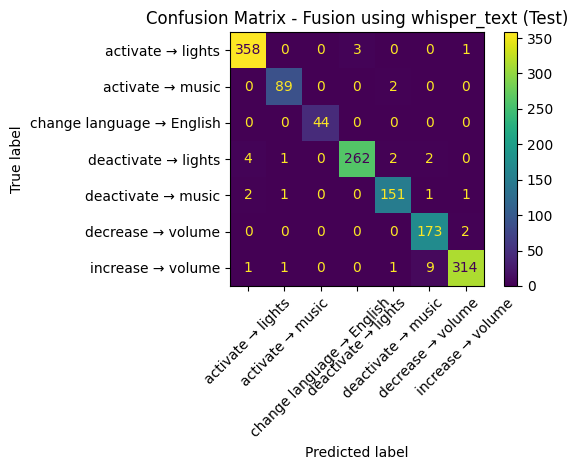

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(10, 8))
    disp.plot(include_values=True, xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

labels = res_B["classes"]
plot_cm(y_test, res_B["pred_test"], labels, "Confusion Matrix - Fusion using whisper_text (Test)")


In [12]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

def learning_curve_full(
    train_text, valid_text,
    X_train_audio, X_valid_audio,
    y_train, y_valid,
    train_fracs=(0.1,0.2,0.4,0.6,0.8,1.0),
    K=32, max_features=20000, seed=42
):
    rng = np.random.default_rng(seed)
    n = len(y_train)
    idx_all = np.arange(n)
    rng.shuffle(idx_all)

    train_text = pd.Series(train_text).fillna("").astype(str).values
    valid_text = pd.Series(valid_text).fillna("").astype(str).values

    sizes = []

    train_accs, valid_accs = [], []
    train_losses, valid_losses = [], []

    for frac in train_fracs:
        m = int(n * frac)
        idx = idx_all[:m]

        # =========================
        # Text features
        # =========================
        vec = TfidfVectorizer(
            ngram_range=(1,2),
            min_df=1,
            max_features=max_features
        )
        X_tr_tfidf = vec.fit_transform(train_text[idx])
        X_va_tfidf = vec.transform(valid_text)

        n_comp = min(K, X_tr_tfidf.shape[1])
        svd = TruncatedSVD(n_components=n_comp, random_state=42)

        X_tr_txt = svd.fit_transform(X_tr_tfidf)
        X_va_txt = svd.transform(X_va_tfidf)

        # =========================
        # Fusion
        # =========================
        X_tr = np.concatenate([X_train_audio[idx], X_tr_txt], axis=1)
        X_va = np.concatenate([X_valid_audio,      X_va_txt], axis=1)

        sc = StandardScaler()
        X_tr = sc.fit_transform(X_tr)
        X_va = sc.transform(X_va)

        clf = LogisticRegression(
            max_iter=5000,
            multi_class="multinomial",
            solver="lbfgs",
            n_jobs=-1
        )
        clf.fit(X_tr, y_train[idx])

        # =========================
        # Predictions
        # =========================
        pred_tr = clf.predict(X_tr)
        pred_va = clf.predict(X_va)

        prob_tr = clf.predict_proba(X_tr)
        prob_va = clf.predict_proba(X_va)

        # =========================
        # Metrics
        # =========================
        train_accs.append(accuracy_score(y_train[idx], pred_tr))
        valid_accs.append(accuracy_score(y_valid, pred_va))

        train_losses.append(log_loss(y_train[idx], prob_tr))
        valid_losses.append(log_loss(y_valid, prob_va))

        sizes.append(m)

    return {
        "sizes": sizes,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
        "train_loss": train_losses,
        "valid_loss": valid_losses
    }


In [13]:
res = learning_curve_full(
    train_text=train_meta_w["whisper_text"],
    valid_text=valid_meta_w["whisper_text"],
    X_train_audio=X_train_audio,
    X_valid_audio=X_valid_audio,
    y_train=y_train,
    y_valid=y_valid,
    K=32
)


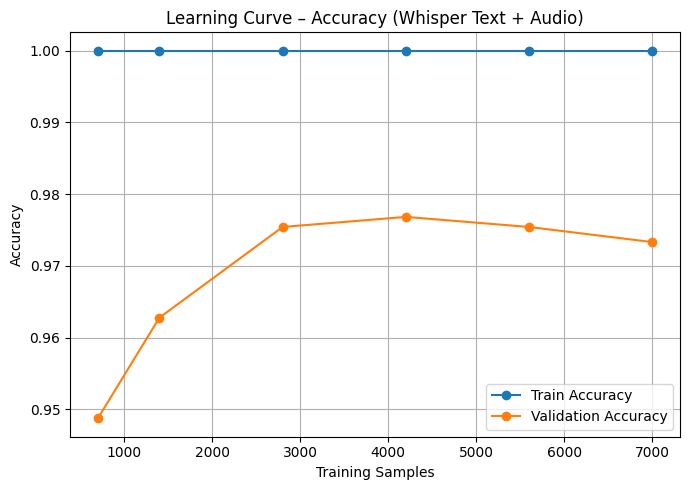

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(res["sizes"], res["train_acc"], marker="o", label="Train Accuracy")
plt.plot(res["sizes"], res["valid_acc"], marker="o", label="Validation Accuracy")
plt.title("Learning Curve – Accuracy (Whisper Text + Audio)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


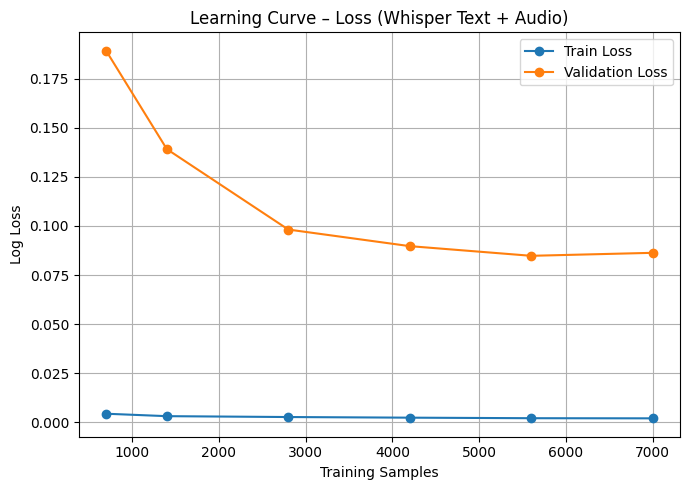

In [15]:
plt.figure(figsize=(7,5))
plt.plot(res["sizes"], res["train_loss"], marker="o", label="Train Loss")
plt.plot(res["sizes"], res["valid_loss"], marker="o", label="Validation Loss")
plt.title("Learning Curve – Loss (Whisper Text + Audio)")
plt.xlabel("Training Samples")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# =========================================================
# Train + Save FINAL MODEL (Case A)
# A: audio_k=256, C=0.03, noise=0.01
# Saves: clf_A, scaler_A, svd_audio_A, + text tools (TFIDF + SVD)
# =========================================================
import os, json, joblib
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# (0) Ensure text tools variable names
# -----------------------------
vectorizer_text = vectorizer      # TF-IDF
svd_text_32     = svd             # Text SVD (32)

# -----------------------------
# (1) Case A hyperparams
# -----------------------------
AUDIO_K   = 256
TEXT_K    = 32
C_A       = 0.03
NOISE_STD = 0.01
RSEED     = 42

# -----------------------------
# (2) Fit Audio SVD on FULL train
# -----------------------------
svd_audio_A = TruncatedSVD(n_components=AUDIO_K, random_state=RSEED)
X_train_a = svd_audio_A.fit_transform(X_train_audio)
X_valid_a = svd_audio_A.transform(X_valid_audio)
X_test_a  = svd_audio_A.transform(X_test_audio)

# -----------------------------
# (3) Fusion (audio + text)
# -----------------------------
X_train_fused = np.concatenate([X_train_a, X_train_text], axis=1)
X_valid_fused = np.concatenate([X_valid_a, X_valid_text], axis=1)
X_test_fused  = np.concatenate([X_test_a,  X_test_text ], axis=1)

# -----------------------------
# (4) Scaling
# -----------------------------
scaler_A = StandardScaler()
X_train_scaled_clean = scaler_A.fit_transform(X_train_fused)
X_valid_scaled       = scaler_A.transform(X_valid_fused)
X_test_scaled        = scaler_A.transform(X_test_fused)

# -----------------------------
# (5) Add noise to TRAIN only (for training)
# -----------------------------
rng = np.random.default_rng(RSEED)
X_train_scaled_noisy = X_train_scaled_clean + rng.normal(0, NOISE_STD, X_train_scaled_clean.shape)

# -----------------------------
# (6) Train classifier (Case A)
# -----------------------------
clf_A = LogisticRegression(
    max_iter=12000,
    multi_class="multinomial",
    solver="saga",
    penalty="l2",
    C=C_A,
    n_jobs=-1,
    tol=1e-3,
    random_state=RSEED
)
clf_A.fit(X_train_scaled_noisy, y_train)

# -----------------------------
# (7) Quick evaluation
# -----------------------------
pred_tr = clf_A.predict(X_train_scaled_clean)
pred_va = clf_A.predict(X_valid_scaled)
pred_te = clf_A.predict(X_test_scaled)

print("=== Case A Metrics (trained on noisy, evaluated on clean) ===")
print("Train Acc:", accuracy_score(y_train, pred_tr), "Train F1:", f1_score(y_train, pred_tr, average="macro"))
print("Valid Acc:", accuracy_score(y_valid, pred_va), "Valid F1:", f1_score(y_valid, pred_va, average="macro"))
print("Test  Acc:", accuracy_score(y_test,  pred_te), "Test  F1:", f1_score(y_test,  pred_te, average="macro"))

# -----------------------------
# (8) Save everything
# -----------------------------
SAVE_DIR = "/kaggle/working/best_model_case_A"
os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(clf_A,           os.path.join(SAVE_DIR, "classifier_logreg.pkl"))
joblib.dump(scaler_A,        os.path.join(SAVE_DIR, "fusion_scaler.pkl"))
joblib.dump(svd_audio_A,     os.path.join(SAVE_DIR, "svd_audio_256.pkl"))
joblib.dump(vectorizer_text, os.path.join(SAVE_DIR, "tfidf_vectorizer.pkl"))
joblib.dump(svd_text_32,     os.path.join(SAVE_DIR, "svd_text_32.pkl"))

config = {
    "case": "A",
    "audio_svd_k": AUDIO_K,
    "text_svd_k": TEXT_K,
    "classifier": "LogisticRegression (multinomial)",
    "solver": "saga",
    "C": C_A,
    "noise_std_train_only": NOISE_STD,
    "fusion": "concatenation (audio + text)",
    "scaler": "StandardScaler"
}
with open(os.path.join(SAVE_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# ✅ مهم: حفظ labels
labels = np.unique(y_train).tolist()
with open(os.path.join(SAVE_DIR, "labels.json"), "w") as f:
    json.dump(labels, f, indent=2)

print("\nSaved Case A artifacts to:", SAVE_DIR)
print("Files:", os.listdir(SAVE_DIR))


=== Case A Metrics (trained on noisy, evaluated on clean) ===
Train Acc: 0.9925714285714285 Train F1: 0.9925743785842701
Valid Acc: 0.9676966292134831 Valid F1: 0.9688484542854662
Test  Acc: 0.9564912280701754 Test  F1: 0.9555362611053323

Saved Case A artifacts to: /kaggle/working/best_model_case_A
Files: ['classifier_logreg.pkl', 'svd_text_32.pkl', 'svd_audio_256.pkl', 'config.json', 'labels.json', 'fusion_scaler.pkl', 'tfidf_vectorizer.pkl']


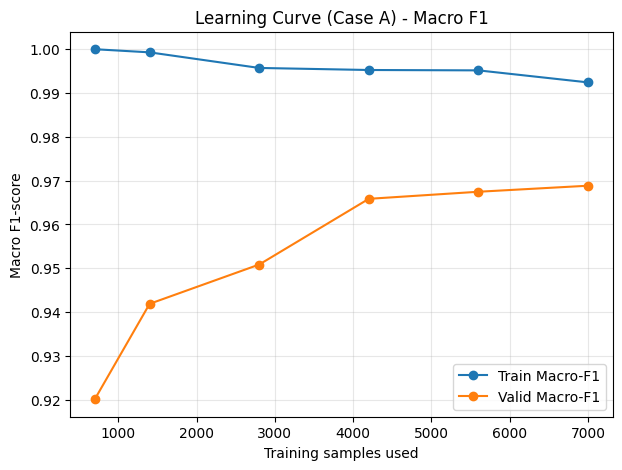

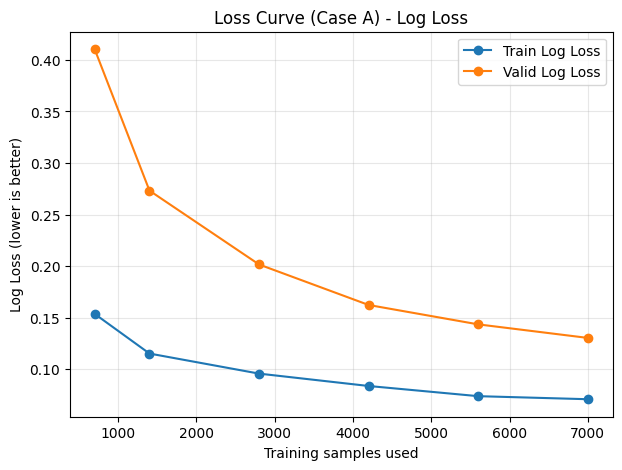

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss

def plot_learning_and_loss_caseA(
    X_train_audio, X_valid_audio,
    X_train_text,  X_valid_text,
    y_train, y_valid,
    audio_k=256,
    C=0.03,
    noise_std=0.01,
    solver="saga",
    random_state=42,
    train_fracs=(0.1, 0.2, 0.4, 0.6, 0.8, 1.0)
):
    # 1) Audio SVD (fit على كامل train ثم transform)
    svd_audio = TruncatedSVD(n_components=audio_k, random_state=random_state)
    X_train_a_full = svd_audio.fit_transform(X_train_audio)
    X_valid_a = svd_audio.transform(X_valid_audio)

    # 2) Fusion
    X_train_full = np.concatenate([X_train_a_full, X_train_text], axis=1)
    X_valid_full = np.concatenate([X_valid_a,      X_valid_text], axis=1)

    # 3) Scale (fit على كامل train ثم transform)
    scaler = StandardScaler()
    X_train_full_sc = scaler.fit_transform(X_train_full)
    X_valid_sc      = scaler.transform(X_valid_full)

    # Labels ثابتة حتى log_loss ما يطلع مشاكل
    classes = np.unique(y_train)
    n = X_train_full_sc.shape[0]
    idx_all = np.arange(n)

    rng = np.random.default_rng(random_state)
    rng.shuffle(idx_all)

    sizes = []
    train_f1s, valid_f1s = [], []
    train_losses, valid_losses = [], []

    for frac in train_fracs:
        m = max(50, int(frac * n))  # خلي الحد الأدنى 50 حتى يكون log_loss ثابت
        idx = idx_all[:m]

        X_tr = X_train_full_sc[idx]
        y_tr = y_train[idx]

        # Noise على TRAIN subset فقط (للتدريب)، والتقييم على clean
        if noise_std and noise_std > 0:
            X_tr_noisy = X_tr + rng.normal(0, noise_std, X_tr.shape)
        else:
            X_tr_noisy = X_tr

        clf = LogisticRegression(
            max_iter=12000,
            multi_class="multinomial",
            solver=solver,
            penalty="l2",
            C=C,
            n_jobs=-1,
            tol=1e-3,
            random_state=random_state
        )
        clf.fit(X_tr_noisy, y_tr)

        # ---- F1 ----
        pred_tr = clf.predict(X_tr)
        pred_va = clf.predict(X_valid_sc)
        train_f1s.append(f1_score(y_tr, pred_tr, average="macro"))
        valid_f1s.append(f1_score(y_valid, pred_va, average="macro"))

        # ---- Loss (log loss) ----
        proba_tr = clf.predict_proba(X_tr)
        proba_va = clf.predict_proba(X_valid_sc)

        # مهم: نمرّر labels=clf.classes_ لضمان ترتيب صحيح
        train_losses.append(log_loss(y_tr, proba_tr, labels=clf.classes_))
        valid_losses.append(log_loss(y_valid, proba_va, labels=clf.classes_))

        sizes.append(m)

    # =========================
    # Plot 1: Learning Curve (F1)
    # =========================
    plt.figure(figsize=(7,5))
    plt.plot(sizes, train_f1s, marker="o", label="Train Macro-F1")
    plt.plot(sizes, valid_f1s, marker="o", label="Valid Macro-F1")
    plt.title("Learning Curve (Case A) - Macro F1")
    plt.xlabel("Training samples used")
    plt.ylabel("Macro F1-score")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # =========================
    # Plot 2: Loss Curve (Log Loss)
    # =========================
    plt.figure(figsize=(7,5))
    plt.plot(sizes, train_losses, marker="o", label="Train Log Loss")
    plt.plot(sizes, valid_losses, marker="o", label="Valid Log Loss")
    plt.title("Loss Curve (Case A) - Log Loss")
    plt.xlabel("Training samples used")
    plt.ylabel("Log Loss (lower is better)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# تشغيل للحالة A
plot_learning_and_loss_caseA(
    X_train_audio=X_train_audio, X_valid_audio=X_valid_audio,
    X_train_text=X_train_text,   X_valid_text=X_valid_text,
    y_train=y_train, y_valid=y_valid,
    audio_k=256, C=0.03, noise_std=0.01
)


<Figure size 1000x800 with 0 Axes>

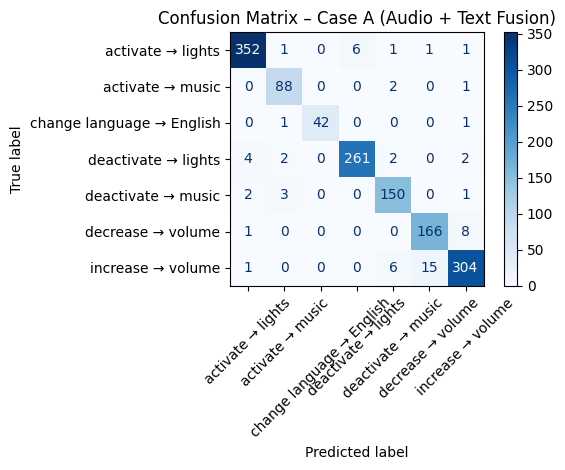

In [29]:
# =========================================
# Confusion Matrix - Case A
# =========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

# -------------------------
# تحميل النموذج والـ scaler
# -------------------------
MODEL_DIR = "/kaggle/working/best_model_case_A"

clf = joblib.load(f"{MODEL_DIR}/classifier_logreg.pkl")
scaler = joblib.load(f"{MODEL_DIR}/fusion_scaler.pkl")

# -------------------------
# تجهيز بيانات الاختبار
# -------------------------
# X_test_fused يجب أن يكون جاهز (audio + text بعد SVD)
X_test_scaled = scaler.transform(X_test_fused)

y_true = y_test
y_pred = clf.predict(X_test_scaled)

# -------------------------
# حساب Confusion Matrix
# -------------------------
labels = np.unique(y_true)

cm = confusion_matrix(y_true, y_pred, labels=labels)

# -------------------------
# الرسم
# -------------------------
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)
disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    values_format="d"
)

plt.title("Confusion Matrix – Case A (Audio + Text Fusion)")
plt.tight_layout()
plt.show()


# Out of domain

In [25]:
def show_examples(meta_w, y_true, y_pred, n=10):
    wrong = np.where(y_true != y_pred)[0]
    print("Total wrong:", len(wrong), "out of", len(y_true))
    for i in wrong[:n]:
        print("-"*60)
        print("Whisper:", meta_w.loc[i, "whisper_text"])
        print("True   :", y_true[i])
        print("Pred   :", y_pred[i])

show_examples(test_meta_w, y_test, res_B["pred_test"], n=10)


Total wrong: 34 out of 1425
------------------------------------------------------------
Whisper: nan
True   : deactivate → music
Pred   : activate → lights
------------------------------------------------------------
Whisper: Cristassan volume
True   : increase → volume
Pred   : decrease → volume
------------------------------------------------------------
Whisper: Bye, everyone, see you in the future.
True   : deactivate → lights
Pred   : decrease → volume
------------------------------------------------------------
Whisper: Router form
True   : increase → volume
Pred   : decrease → volume
------------------------------------------------------------
Whisper: சிற்சு அந்த வாஸ்ட்டும் வேண்டும்
True   : activate → lights
Pred   : deactivate → lights
------------------------------------------------------------
Whisper: Up.
True   : deactivate → music
Pred   : increase → volume
------------------------------------------------------------
Whisper: Turn on the kitchen lights.
True   : deactiv

In [30]:
import pandas as pd 
train_meta_w = pd.read_csv("/kaggle/input/whisper-text/train_meta_whisper_text.csv")
valid_meta_w = pd.read_csv("/kaggle/input/whisper-text/valid_meta_whisper_text.csv")
test_meta_w  = pd.read_csv("/kaggle/input/whisper-text/test_meta_whisper_text.csv")

In [32]:
import joblib
import numpy as np

# تحميل نماذج النص
vectorizer = joblib.load("/kaggle/working/tfidf_vectorizer_text.pkl")
svd        = joblib.load("/kaggle/working/svd_text.pkl")

# تحميل الـ scalers
scaler = joblib.load("/kaggle/working/fusion_scaler_text.pkl")

# تحميل نموذج التصنيف
clf = joblib.load("/kaggle/working/fusion_logreg_pair_text.pkl")

labels_path = os.path.join(MODEL_DIR, "labels.json")
LABELS = None
if os.path.exists(labels_path):
    with open(labels_path, "r") as f:
        LABELS = json.load(f)

alpha = 1.0  # if you want to weight text later, change it

# Rejected Machanisem

In [4]:
import re
import numpy as np

def normalize_text(text: str) -> str:
    text = str(text).lower().strip()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def map_text_to_intent(text: str):
    """
    يرجع (action, object, pair):
      - pair بشكل "action → object" إذا قدر يحدد نية واضحة
      - أو pair="in_domain_ambiguous" إذا الجملة ضمن المجال لكن غير صريحة
      - أو (None, None, None) إذا خارج المجال
    """
    txt = normalize_text(text)
    if not txt:
        return None, None, None

    # 1) music on/off
    if any(w in txt for w in ["pause","stop","mute","quiet","silence"]):
        action, obj = "deactivate", "music"
        return action, obj, f"{action} → {obj}"

    if any(w in txt for w in ["resume","play","start","continue"]):
        action, obj = "activate", "music"
        return action, obj, f"{action} → {obj}"

    # 2) volume up/down
    if any(w in txt for w in ["loud","up","increase","raise","higher"]):
        action, obj = "increase", "volume"
        return action, obj, f"{action} → {obj}"

    if any(w in txt for w in ["down","decrease","lower","reduce","softer"]):
        action, obj = "decrease", "volume"
        return action, obj, f"{action} → {obj}"

    # 3) language
    if ("language" in txt) or ("english" in txt):
        action, obj = "change language", "English"
        return action, obj, f"{action} → {obj}"

    # 4) lights on/off (لازم on/off صريح حتى نرجع نية)
    if ("light" in txt) or ("lights" in txt) or ("lamp" in txt):
        if "off" in txt:
            action, obj = "deactivate", "lights"
            return action, obj, f"{action} → {obj}"
        if "on" in txt:
            action, obj = "activate", "lights"
            return action, obj, f"{action} → {obj}"
        # موجود lights لكن بدون on/off -> ambiguous ضمن المجال
        return "IN_DOMAIN", "lights", "in_domain_ambiguous"

    # 5) ✅ Ambiguous in-domain (يمرّ بدون رفض)
    # مثل: "I need volume", "volume please", "I need music"
    if ("volume" in txt) or ("sound" in txt):
        return "IN_DOMAIN", "volume", "in_domain_ambiguous"

    if ("music" in txt) or ("song" in txt) or ("audio" in txt):
        return "IN_DOMAIN", "music", "in_domain_ambiguous"

    return None, None, None

def should_reject(text):
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return True, "reject: ASR failure (NaN)"

    txt = str(text).strip()
    if len(txt) < 2:
        return True, "reject: ASR failure (too short)"

    action, obj, pair = map_text_to_intent(txt)

    # ضمن المجال حتى لو ambiguous → لا ترفضي
    if pair == "in_domain_ambiguous":
        return False, f"ok (in-domain ambiguous: {obj})"

    # خارج المجال
    if pair is None:
        return True, "reject: out-of-domain (no valid intent)"

    return False, "ok"


In [34]:
reject_flags, reject_reasons = [], []
for t in test_meta_w["whisper_text"].tolist():
    r, reason = should_reject(t)
    reject_flags.append(r)
    reject_reasons.append(reason)

test_meta_w["rejected"] = reject_flags
test_meta_w["reject_reason"] = reject_reasons

print("Reject rate:", np.mean(test_meta_w["rejected"]) * 100, "%")
print(test_meta_w["reject_reason"].value_counts())


Reject rate: 6.7368421052631575 %
reject_reason
ok                                         1267
reject: out-of-domain (no valid intent)      94
ok (in-domain ambiguous: volume)             35
ok (in-domain ambiguous: music)              19
ok (in-domain ambiguous: lights)              8
reject: ASR failure (NaN)                     2
Name: count, dtype: int64


In [9]:
pred_all = []

for _, row in test_meta_w.iterrows():
    text = str(row["whisper_text"])

    # تمثيل النص
    X_txt = vectorizer.transform([text])
    X_txt = svd.transform(X_txt)
    X_txt = alpha * X_txt

    # Audio dummy (لنفس أبعاد التدريب)
    X_audio = np.zeros((1, AUDIO_DIM))

    # Fusion + scaling
    X_fused = np.concatenate([X_audio, X_txt], axis=1)
    X_fused = scaler.transform(X_fused)

    # Prediction
    pred = clf.predict(X_fused)[0]
    pred_all.append(pred)

pred_all = np.array(pred_all)


In [10]:
y_true = test_meta_w["pair"].astype(str).values
y_pred = pred_all


In [14]:
!ffmpeg -version


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-l

In [38]:
!pip install -q openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 11.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2

In [2]:
import os, glob, subprocess, re, json
import numpy as np
import torch
import whisper
import joblib
from IPython.display import Audio, display


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
whisper_model = whisper.load_model("small").to(DEVICE)
print("Whisper model loaded on:", DEVICE)

Whisper model loaded on: cuda


# Demo

In [10]:

# =========================
# (1) Convert m4a -> wav (optional helper)
# =========================
def convert_to_wav_16k_mono(in_path, out_path):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    cmd = [
        "ffmpeg", "-y",
        "-i", in_path,
        "-ac", "1",
        "-ar", "16000",
        out_path
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def ensure_wav(audio_path, wav_root="/kaggle/working/demo_audio_wav_caseA"):
    """
    إذا دخلتي m4a: يحولها wav 16k mono ويعيد مسار wav
    إذا wav: يرجع نفس المسار
    """
    ext = os.path.splitext(audio_path)[1].lower()
    if ext == ".wav":
        return audio_path

    base = os.path.splitext(os.path.basename(audio_path))[0]
    out_wav = os.path.join(wav_root, base + ".wav")
    if not os.path.exists(out_wav):
        convert_to_wav_16k_mono(audio_path, out_wav)
    return out_wav


# =========================
# (2) Load Case A artifacts
# =========================
MODEL_DIR = "/kaggle/working/best_model_case_A"

clf        = joblib.load(os.path.join(MODEL_DIR, "classifier_logreg.pkl"))
scaler     = joblib.load(os.path.join(MODEL_DIR, "fusion_scaler.pkl"))
svd_audio  = joblib.load(os.path.join(MODEL_DIR, "svd_audio_256.pkl"))
vectorizer = joblib.load(os.path.join(MODEL_DIR, "tfidf_vectorizer.pkl"))
svd_text   = joblib.load(os.path.join(MODEL_DIR, "svd_text_32.pkl"))

alpha = 1.0  # خليه 1.0 للديمو

# labels (اختياري)
LABELS = None
labels_path = os.path.join(MODEL_DIR, "labels.json")
if os.path.exists(labels_path):
    with open(labels_path, "r") as f:
        LABELS = json.load(f)

# =========================
# (3) Load Whisper model
# =========================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
whisper_model = whisper.load_model("small").to(DEVICE)
print("Whisper model loaded on:", DEVICE)


# =========================
# (4) Audio embedding 768 ثم Audio SVD 256 (Case A)
# =========================
def extract_audio_embedding_768(audio_path):
    audio = whisper.load_audio(audio_path)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(whisper_model.device)
    mel = mel.unsqueeze(0)  # (1, 80, T)

    with torch.no_grad():
        enc = whisper_model.encoder(mel)  # (1, T, 768)

    emb_768 = enc.mean(dim=1).squeeze(0).cpu().numpy()  # (768,)
    return emb_768


# =========================
# (5) Full Demo - Case A
# =========================
def demo_full_pipeline_caseA(audio_path):
    print("=" * 100)

    # 0) ensure wav (16k mono) for consistent demo
    wav_path = ensure_wav(audio_path)
    print("Audio path (used):", wav_path)

    # Play audio
    display(Audio(filename=wav_path))

    # 1) ASR
    asr = whisper_model.transcribe(wav_path, fp16=False)
    text = asr.get("text", "").strip()
    print("Whisper text:", text if text else "(empty)")

    # 2) Reject / Accept
    reject, reason = should_reject(text)
    print("Decision   :", "REJECTED" if reject else "ACCEPTED")
    print("Reason     :", reason)
    if reject:
        return

    # 3) Text embedding: TF-IDF -> SVD(32)
    X_txt = vectorizer.transform([text])
    X_txt = svd_text.transform(X_txt) * alpha  # (1, 32)

    # 4) Audio embedding: Whisper encoder 768 -> Audio SVD(256)
    emb_768 = extract_audio_embedding_768(wav_path).reshape(1, -1)  # (1, 768)
    X_audio = svd_audio.transform(emb_768)                           # (1, 256)

    # 5) Fusion (256 + 32 = 288) + scaling
    X_fused = np.concatenate([X_audio, X_txt], axis=1)               # (1, 288)
    X_fused_sc = scaler.transform(X_fused)

    # 6) Prediction + confidence
    pred = clf.predict(X_fused_sc)[0]
    print("Prediction :", pred)

    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X_fused_sc)[0]
        conf = float(np.max(proba))
        print("Confidence :", round(conf, 4))

        # Top-3 (اختياري)
        if LABELS is not None and len(LABELS) == len(proba):
            top_idx = np.argsort(proba)[::-1][:3]
            print("Top-3:")
            for i in top_idx:
                print(f"  - {LABELS[i]} : {proba[i]:.4f}")


# =========================
# (6) Examples (عدلّي المسارات حسب ملفاتك)
# =========================
demo_full_pipeline_caseA("/kaggle/input/demo-audio/demo_audio/accept/Decreas volum.m4a")
demo_full_pipeline_caseA("/kaggle/input/demo-audio/demo_audio/amigos/Switch the keyboard to english.m4a")
demo_full_pipeline_caseA("/kaggle/input/demo-audio/demo_audio/reject/Hello how are you.m4a")

Whisper model loaded on: cuda
Audio path (used): /kaggle/working/demo_audio_wav_caseA/Decreas volum.wav


Whisper text: Decrease volume.
Decision   : ACCEPTED
Reason     : ok
Prediction : decrease → volume
Confidence : 0.9997
Top-3:
  - decrease → volume : 0.9997
  - deactivate → music : 0.0002
  - activate → lights : 0.0001
Audio path (used): /kaggle/working/demo_audio_wav_caseA/Switch the keyboard to english.wav


Whisper text: Switch the keyboard to English.
Decision   : ACCEPTED
Reason     : ok
Prediction : change language → English
Confidence : 0.6227
Top-3:
  - change language → English : 0.6227
  - activate → lights : 0.2042
  - deactivate → music : 0.1666
Audio path (used): /kaggle/working/demo_audio_wav_caseA/Hello how are you.wav


Whisper text: Hello, how are you?
Decision   : REJECTED
Reason     : reject: out-of-domain (no valid intent)


# Previous Experiences

In [16]:
X_train_audio = train_df[numeric_cols].values
X_valid_audio = valid_df[numeric_cols].values
X_test_audio  = test_df[numeric_cols].values

In [17]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def train_eval_variant(
    X_train_audio, X_valid_audio, X_test_audio,
    X_train_text,  X_valid_text,  X_test_text,
    y_train, y_valid, y_test,
    use_audio_svd=False, audio_k=128,
    C=1.0, solver="lbfgs",
    use_noise=False, noise_std=0.02,
    random_state=42
):
    # 1) اختياري: تقليل أبعاد الصوت
    if use_audio_svd:
        svd_audio = TruncatedSVD(n_components=audio_k, random_state=random_state)
        X_train_a = svd_audio.fit_transform(X_train_audio)
        X_valid_a = svd_audio.transform(X_valid_audio)
        X_test_a  = svd_audio.transform(X_test_audio)
    else:
        X_train_a, X_valid_a, X_test_a = X_train_audio, X_valid_audio, X_test_audio

    # 2) دمج (صوت + نص)
    X_train_fused = np.concatenate([X_train_a, X_train_text], axis=1)
    X_valid_fused = np.concatenate([X_valid_a, X_valid_text], axis=1)
    X_test_fused  = np.concatenate([X_test_a,  X_test_text],  axis=1)

    # 3) Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fused)
    X_valid_scaled = scaler.transform(X_valid_fused)
    X_test_scaled  = scaler.transform(X_test_fused)

    # 4) اختياري: Noise على التدريب فقط
    if use_noise:
        rng = np.random.default_rng(random_state)
        X_train_scaled = X_train_scaled + rng.normal(0, noise_std, X_train_scaled.shape)

    # 5) Logistic Regression (Regularization عبر C)
    clf = LogisticRegression(
        max_iter=8000,
        multi_class="multinomial",
        solver=solver,
        n_jobs=-1,
        C=C,
        penalty="l2",
        tol=1e-3
    )
    clf.fit(X_train_scaled, y_train)

    # 6) تقييم
    pred_tr = clf.predict(X_train_scaled)
    pred_va = clf.predict(X_valid_scaled)
    pred_te = clf.predict(X_test_scaled)

    tr_acc = accuracy_score(y_train, pred_tr)
    tr_f1  = f1_score(y_train, pred_tr, average="macro")
    va_acc = accuracy_score(y_valid, pred_va)
    va_f1  = f1_score(y_valid, pred_va, average="macro")
    te_acc = accuracy_score(y_test, pred_te)
    te_f1  = f1_score(y_test, pred_te, average="macro")

    return {
        "use_audio_svd": use_audio_svd,
        "audio_k": audio_k if use_audio_svd else None,
        "use_noise": use_noise,
        "noise_std": noise_std if use_noise else None,
        "C": C,
        "solver": solver,
        "train_acc": tr_acc, "train_f1": tr_f1,
        "valid_acc": va_acc, "valid_f1": va_f1,
        "test_acc": te_acc,  "test_f1": te_f1,
        "gap_f1": tr_f1 - va_f1
    }


In [18]:
# 0) Baseline
res0 = train_eval_variant(
    X_train_audio, X_valid_audio, X_test_audio,
    X_train_text, X_valid_text, X_test_text,
    y_train, y_valid, y_test,
    use_audio_svd=False,
    C=1.0, solver="lbfgs",
    use_noise=False
)

# 1) Regularization أقوى (C أصغر + saga)
res1 = train_eval_variant(
    X_train_audio, X_valid_audio, X_test_audio,
    X_train_text, X_valid_text, X_test_text,
    y_train, y_valid, y_test,
    use_audio_svd=False,
    C=1e-3, solver="saga",
    use_noise=False
)

# 2) Audio SVD فقط
res2 = train_eval_variant(
    X_train_audio, X_valid_audio, X_test_audio,
    X_train_text, X_valid_text, X_test_text,
    y_train, y_valid, y_test,
    use_audio_svd=True, audio_k=128,
    C=1.0, solver="lbfgs",
    use_noise=False
)

# 3) Noise فقط
res3 = train_eval_variant(
    X_train_audio, X_valid_audio, X_test_audio,
    X_train_text, X_valid_text, X_test_text,
    y_train, y_valid, y_test,
    use_audio_svd=False,
    C=1.0, solver="lbfgs",
    use_noise=True, noise_std=0.02
)

# 4) Combined (الثلاثة سوا)
res4 = train_eval_variant(
    X_train_audio, X_valid_audio, X_test_audio,
    X_train_text, X_valid_text, X_test_text,
    y_train, y_valid, y_test,
    use_audio_svd=True, audio_k=128,
    C=1e-3, solver="saga",
    use_noise=True, noise_std=0.02
)

for i, r in enumerate([res0,res1,res2,res3,res4]):
    print(f"\nVariant {i}: {r}")



Variant 0: {'use_audio_svd': False, 'audio_k': None, 'use_noise': False, 'noise_std': None, 'C': 1.0, 'solver': 'lbfgs', 'train_acc': 1.0, 'train_f1': 1.0, 'valid_acc': 0.9754213483146067, 'valid_f1': 0.9748655795508044, 'test_acc': 0.9691228070175438, 'test_f1': 0.9698813803245706, 'gap_f1': 0.02513442044919556}

Variant 1: {'use_audio_svd': False, 'audio_k': None, 'use_noise': False, 'noise_std': None, 'C': 0.001, 'solver': 'saga', 'train_acc': 0.9641428571428572, 'train_f1': 0.9641070715875732, 'valid_acc': 0.9311797752808989, 'valid_f1': 0.921017040839574, 'test_acc': 0.9319298245614035, 'test_f1': 0.9278097945040515, 'gap_f1': 0.04309003074799922}

Variant 2: {'use_audio_svd': True, 'audio_k': 128, 'use_noise': False, 'noise_std': None, 'C': 1.0, 'solver': 'lbfgs', 'train_acc': 0.9802857142857143, 'train_f1': 0.9802822235353962, 'valid_acc': 0.9459269662921348, 'valid_f1': 0.9422895641301706, 'test_acc': 0.9389473684210526, 'test_f1': 0.9366267322949812, 'gap_f1': 0.0379926594052

In [19]:

# ============================================================
# Run 3 targeted attempts (Audio SVD + Regularization + Noise)
# - Attempts:
#   A) audio_k=256, C=0.03, noise=0.01
#   B) audio_k=128, C=0.03, noise=0.01
#   C) audio_k=128, C=0.10, noise=0.01
# Notes:
# - Train is evaluated on CLEAN train (to measure "memorization")
# - Model is trained on NOISY train (regularization trick)
# - Uses SVD for audio reduction, then concatenates with text SVD features
# ============================================================

import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def run_attempt(
    name,
    X_train_audio, X_valid_audio, X_test_audio,
    X_train_text,  X_valid_text,  X_test_text,
    y_train, y_valid, y_test,
    audio_k=128,
    C=0.03,
    noise_std=0.01,
    random_state=42
):
    # ----------------------------
    # 1) Reduce audio dims (SVD)
    # ----------------------------
    svd_audio = TruncatedSVD(n_components=audio_k, random_state=random_state)
    X_train_a = svd_audio.fit_transform(X_train_audio)
    X_valid_a = svd_audio.transform(X_valid_audio)
    X_test_a  = svd_audio.transform(X_test_audio)

    # ----------------------------
    # 2) Fusion (audio + text)
    # ----------------------------
    X_train_fused = np.concatenate([X_train_a, X_train_text], axis=1)
    X_valid_fused = np.concatenate([X_valid_a, X_valid_text], axis=1)
    X_test_fused  = np.concatenate([X_test_a,  X_test_text],  axis=1)

    # ----------------------------
    # 3) Standardize
    # ----------------------------
    scaler = StandardScaler()
    X_train_scaled_clean = scaler.fit_transform(X_train_fused)
    X_valid_scaled = scaler.transform(X_valid_fused)
    X_test_scaled  = scaler.transform(X_test_fused)

    # ----------------------------
    # 4) Add noise to TRAIN only (for training)
    #    but evaluate train on CLEAN
    # ----------------------------
    rng = np.random.default_rng(random_state)
    X_train_scaled_noisy = X_train_scaled_clean + rng.normal(0, noise_std, X_train_scaled_clean.shape)

    # ----------------------------
    # 5) Logistic Regression (saga for stronger regularization behavior)
    # ----------------------------
    clf = LogisticRegression(
        max_iter=12000,
        multi_class="multinomial",
        solver="saga",
        penalty="l2",
        C=C,
        n_jobs=-1,
        tol=1e-3,
        random_state=random_state
    )
    clf.fit(X_train_scaled_noisy, y_train)

    # ----------------------------
    # 6) Evaluate
    # ----------------------------
    # Train metrics on CLEAN train (important!)
    pred_tr = clf.predict(X_train_scaled_clean)
    tr_acc = accuracy_score(y_train, pred_tr)
    tr_f1  = f1_score(y_train, pred_tr, average="macro")

    # Valid/Test
    pred_va = clf.predict(X_valid_scaled)
    pred_te = clf.predict(X_test_scaled)

    va_acc = accuracy_score(y_valid, pred_va)
    va_f1  = f1_score(y_valid, pred_va, average="macro")
    te_acc = accuracy_score(y_test, pred_te)
    te_f1  = f1_score(y_test, pred_te, average="macro")

    out = {
        "name": name,
        "audio_k": audio_k,
        "C": C,
        "noise_std": noise_std,
        "train_acc": tr_acc,
        "train_f1": tr_f1,
        "valid_acc": va_acc,
        "valid_f1": va_f1,
        "test_acc": te_acc,
        "test_f1": te_f1,
        "gap_f1": tr_f1 - va_f1
    }
    return out


# ============================================================
# REQUIRED VARIABLES (must already exist from your notebook):
# X_train_audio, X_valid_audio, X_test_audio
# X_train_text,  X_valid_text,  X_test_text
# y_train, y_valid, y_test
# ============================================================

attempts = [
    ("A_audio256_C003_noise001", 256, 0.03, 0.01),
    ("B_audio128_C003_noise001", 128, 0.03, 0.01),
    ("C_audio128_C01_noise001",  128, 0.10, 0.01),
]

results = []
for name, audio_k, C, noise_std in attempts:
    r = run_attempt(
        name=name,
        X_train_audio=X_train_audio, X_valid_audio=X_valid_audio, X_test_audio=X_test_audio,
        X_train_text=X_train_text,   X_valid_text=X_valid_text,   X_test_text=X_test_text,
        y_train=y_train, y_valid=y_valid, y_test=y_test,
        audio_k=audio_k,
        C=C,
        noise_std=noise_std,
        random_state=42
    )
    results.append(r)
    print("\n", "="*80)
    print("Attempt:", r["name"])
    print(f"audio_k={r['audio_k']} | C={r['C']} | noise_std={r['noise_std']}")
    print(f"Train: Acc={r['train_acc']:.4f} F1={r['train_f1']:.4f}")
    print(f"Valid: Acc={r['valid_acc']:.4f} F1={r['valid_f1']:.4f}")
    print(f"Test : Acc={r['test_acc']:.4f} F1={r['test_f1']:.4f}")
    print(f"GapF1: {r['gap_f1']:.4f}")

# Print summary sorted by valid_f1 then test_f1
print("\n\n==================== SUMMARY (sorted by Valid F1) ====================")
results_sorted = sorted(results, key=lambda d: (d["valid_f1"], d["test_f1"]), reverse=True)
for r in results_sorted:
    print(f"{r['name']}: "
          f"TrainF1={r['train_f1']:.4f} | ValidF1={r['valid_f1']:.4f} | TestF1={r['test_f1']:.4f} | Gap={r['gap_f1']:.4f}") 



Attempt: A_audio256_C003_noise001
audio_k=256 | C=0.03 | noise_std=0.01
Train: Acc=0.9926 F1=0.9926
Valid: Acc=0.9677 F1=0.9688
Test : Acc=0.9565 F1=0.9555
GapF1: 0.0237

Attempt: B_audio128_C003_noise001
audio_k=128 | C=0.03 | noise_std=0.01
Train: Acc=0.9641 F1=0.9641
Valid: Acc=0.9438 F1=0.9434
Test : Acc=0.9361 F1=0.9347
GapF1: 0.0207

Attempt: C_audio128_C01_noise001
audio_k=128 | C=0.1 | noise_std=0.01
Train: Acc=0.9703 F1=0.9703
Valid: Acc=0.9473 F1=0.9457
Test : Acc=0.9389 F1=0.9382
GapF1: 0.0246


==================== SUMMARY (sorted by Valid F1) ====================
A_audio256_C003_noise001: TrainF1=0.9926 | ValidF1=0.9688 | TestF1=0.9555 | Gap=0.0237
C_audio128_C01_noise001: TrainF1=0.9703 | ValidF1=0.9457 | TestF1=0.9382 | Gap=0.0246
B_audio128_C003_noise001: TrainF1=0.9641 | ValidF1=0.9434 | TestF1=0.9347 | Gap=0.0207


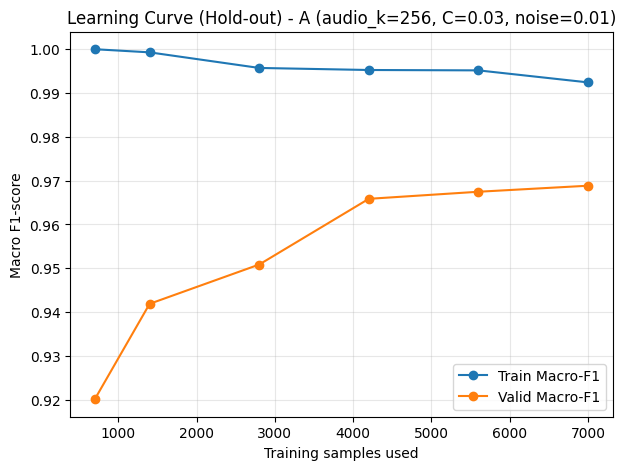

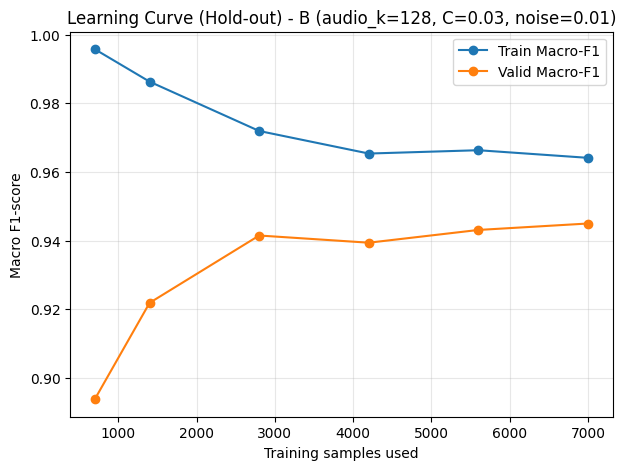

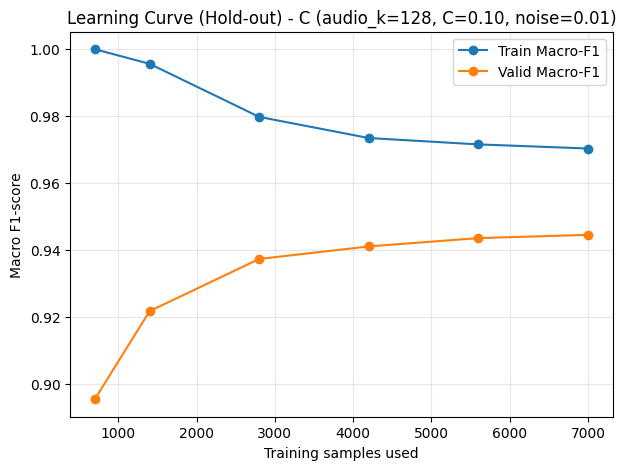

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# ---------------------------
# مساعد: تدريب وتقييم على أحجام مختلفة
# ---------------------------
def learning_curve_holdout(
    name,
    X_train_audio, X_valid_audio,
    X_train_text,  X_valid_text,
    y_train, y_valid,
    audio_k=256,
    C=0.03,
    noise_std=0.01,
    solver="saga",
    random_state=42,
    train_fracs=(0.1, 0.2, 0.4, 0.6, 0.8, 1.0)
):
    # 1) Audio SVD (fit على كامل train ثم transform)
    svd_audio = TruncatedSVD(n_components=audio_k, random_state=random_state)
    X_train_a_full = svd_audio.fit_transform(X_train_audio)
    X_valid_a = svd_audio.transform(X_valid_audio)

    # 2) Fusion
    X_train_full = np.concatenate([X_train_a_full, X_train_text], axis=1)
    X_valid_full = np.concatenate([X_valid_a,      X_valid_text], axis=1)

    # 3) Scale (fit على كامل train ثم transform)
    scaler = StandardScaler()
    X_train_full_sc = scaler.fit_transform(X_train_full)
    X_valid_sc      = scaler.transform(X_valid_full)

    # تحضير الأبعاد
    n = X_train_full_sc.shape[0]
    idx_all = np.arange(n)

    train_f1s = []
    valid_f1s = []
    sizes = []

    rng = np.random.default_rng(random_state)
    rng.shuffle(idx_all)

    for frac in train_fracs:
        m = max(10, int(frac * n))
        idx = idx_all[:m]

        X_tr = X_train_full_sc[idx]
        y_tr = y_train[idx]

        # 4) Noise على train subset فقط
        if noise_std and noise_std > 0:
            X_tr_noisy = X_tr + rng.normal(0, noise_std, X_tr.shape)
        else:
            X_tr_noisy = X_tr

        # 5) Train classifier
        clf = LogisticRegression(
            max_iter=12000,
            multi_class="multinomial",
            solver=solver,
            penalty="l2",
            C=C,
            n_jobs=-1,
            tol=1e-3,
            random_state=random_state
        )
        clf.fit(X_tr_noisy, y_tr)

        # 6) Evaluate (Train على clean subset + Valid)
        pred_tr = clf.predict(X_tr)
        pred_va = clf.predict(X_valid_sc)

        train_f1 = f1_score(y_tr, pred_tr, average="macro")
        valid_f1 = f1_score(y_valid, pred_va, average="macro")

        sizes.append(m)
        train_f1s.append(train_f1)
        valid_f1s.append(valid_f1)

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(sizes, train_f1s, marker="o", label="Train Macro-F1")
    plt.plot(sizes, valid_f1s, marker="o", label="Valid Macro-F1")
    plt.title(f"Learning Curve (Hold-out) - {name}")
    plt.xlabel("Training samples used")
    plt.ylabel("Macro F1-score")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# =========================================================
# 3 Plots for your 3 attempts
# A) audio_k=256, C=0.03, noise=0.01
# B) audio_k=128, C=0.03, noise=0.01
# C) audio_k=128, C=0.10, noise=0.01
# =========================================================

learning_curve_holdout(
    name="A (audio_k=256, C=0.03, noise=0.01)",
    X_train_audio=X_train_audio, X_valid_audio=X_valid_audio,
    X_train_text=X_train_text,   X_valid_text=X_valid_text,
    y_train=y_train, y_valid=y_valid,
    audio_k=256, C=0.03, noise_std=0.01
)

learning_curve_holdout(
    name="B (audio_k=128, C=0.03, noise=0.01)",
    X_train_audio=X_train_audio, X_valid_audio=X_valid_audio,
    X_train_text=X_train_text,   X_valid_text=X_valid_text,
    y_train=y_train, y_valid=y_valid,
    audio_k=128, C=0.03, noise_std=0.01
)

learning_curve_holdout(
    name="C (audio_k=128, C=0.10, noise=0.01)",
    X_train_audio=X_train_audio, X_valid_audio=X_valid_audio,
    X_train_text=X_train_text,   X_valid_text=X_valid_text,
    y_train=y_train, y_valid=y_valid,
    audio_k=128, C=0.10, noise_std=0.01
)


In [13]:
import pandas as pd

# عدّلي المسارات حسب ملفاتك
train_path = "/kaggle/input/traine-mapped-balance/train_hybrid_balanced_down (2).csv"
valid_path = "/kaggle/input/data-split2/valid_split.csv"
test_path  = "/kaggle/input/data-split2/test_split.csv"

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df  = pd.read_csv(test_path)

print(train_df.columns)
train_df.head()


Index(['path', 'transcription', 'action', 'object', 'full_path', 'is_aug'], dtype='object')


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,path,transcription,action,object,full_path,is_aug
0,wavs/speakers/52XVOeXMXYuaElyw/0fd74520-45c9-1...,Switch on the washroom lights,activate,lights,/kaggle/input/fluent-speech-commands/fluent_sp...,NaN
1,wavs/speakers/R3mXwwoaX9IoRVKe/ed350420-4547-1...,Switch the lights on,activate,lights,/kaggle/input/fluent-speech-commands/fluent_sp...,NaN
2,wavs/speakers/W4XOzzNEbrtZz4dW/018c1ef0-44cf-1...,Switch on the kitchen lights,activate,lights,/kaggle/input/fluent-speech-commands/fluent_sp...,NaN
3,wavs/speakers/D4jGxZ7KamfVo4E2V/34ac88a0-45cf-...,Switch the lights on,activate,lights,/kaggle/input/fluent-speech-commands/fluent_sp...,NaN
4,wavs/speakers/2BqVo8kVB2Skwgyb/e743df20-4478-1...,Lights on in the bathroom,activate,lights,/kaggle/input/fluent-speech-commands/fluent_sp...,NaN


In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

TEXT_COL = "transcription"

# 1) قراءة كل البيانات من data-split2
train_raw = pd.read_csv("/kaggle/input/data-split2/train_split.csv")
valid_raw = pd.read_csv("/kaggle/input/data-split2/valid_split.csv")
test_raw  = pd.read_csv("/kaggle/input/data-split2/test_split.csv")

all_df = pd.concat([train_raw, valid_raw, test_raw], ignore_index=True)

# اختياري: تنظيف بسيط
all_df = all_df.dropna(subset=[TEXT_COL, "action", "object"]).reset_index(drop=True)

# إضافة pair إذا ما كان موجود
if "pair" not in all_df.columns:
    all_df["pair"] = all_df["action"] + " → " + all_df["object"]

print("All rows:", all_df.shape)
print("Unique texts:", all_df[TEXT_COL].nunique())


All rows: (14241, 6)
Unique texts: 115


In [16]:
groups = all_df[TEXT_COL]  # كل جملة هي group

# 70% train, 30% temp
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(gss1.split(all_df, groups=groups))

train_df = all_df.iloc[train_idx].reset_index(drop=True)
temp_df  = all_df.iloc[temp_idx].reset_index(drop=True)

print("Train rows:", train_df.shape, "Temp rows:", temp_df.shape)
print("Train unique texts:", train_df[TEXT_COL].nunique())
print("Temp  unique texts:", temp_df[TEXT_COL].nunique())

# 15% valid, 15% test من temp (group split أيضاً)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
valid_idx, test_idx = next(gss2.split(temp_df, groups=temp_df[TEXT_COL]))

valid_df = temp_df.iloc[valid_idx].reset_index(drop=True)
test_df  = temp_df.iloc[test_idx].reset_index(drop=True)

print("Final shapes:")
print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test :", test_df.shape)

print("Unique texts per split:")
print("Train:", train_df[TEXT_COL].nunique())
print("Valid:", valid_df[TEXT_COL].nunique())
print("Test :", test_df[TEXT_COL].nunique())


Train rows: (9874, 6) Temp rows: (4367, 6)
Train unique texts: 80
Temp  unique texts: 35
Final shapes:
Train: (9874, 6)
Valid: (2132, 6)
Test : (2235, 6)
Unique texts per split:
Train: 80
Valid: 17
Test : 18


In [17]:
train_texts = set(train_df[TEXT_COL])
valid_texts = set(valid_df[TEXT_COL])
test_texts  = set(test_df[TEXT_COL])

print("Overlap train/test :", len(train_texts & test_texts))
print("Overlap train/valid:", len(train_texts & valid_texts))
print("Overlap valid/test :", len(valid_texts & test_texts))


Overlap train/test : 0
Overlap train/valid: 0
Overlap valid/test : 0


In [18]:
LABEL_COL = "pair"

# كل الليبلات الموجودة في train فقط
unique_labels = sorted(train_df[LABEL_COL].unique())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

print("Labels:", label2id)

for df in (train_df, valid_df, test_df):
    df["label_id"] = df[LABEL_COL].map(label2id)


Labels: {'activate → lights': 0, 'activate → music': 1, 'change language → English': 2, 'deactivate → lights': 3, 'deactivate → music': 4, 'decrease → volume': 5, 'increase → volume': 6}


In [7]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
text_encoder = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
text_encoder.eval()

TEXT_COL = "transcription"

def encode_texts(df, batch_size=32):
    texts = df[TEXT_COL].astype(str).tolist()
    all_embs = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Encoding texts"):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=64,
            ).to(DEVICE)

            outputs = text_encoder(**inputs)
            # نستخدم mean pooling على طول التسلسل
            last_hidden = outputs.last_hidden_state  # [B, T, H]
            emb = last_hidden.mean(dim=1)            # [B, H]
            all_embs.append(emb.cpu().numpy())

    all_embs = np.vstack(all_embs)
    return all_embs


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [19]:
import pandas as pd

# القراءة من الملفات التي خزنتيها سابقاً
whisper_train = pd.read_csv("/kaggle/input/features-whisper/whisper_train.csv")
whisper_valid = pd.read_csv("/kaggle/input/features-whisper/whisper_valid.csv")
whisper_test  = pd.read_csv("/kaggle/input/features-whisper/whisper_test.csv")

print(whisper_train.shape, whisper_valid.shape, whisper_test.shape)


(7000, 772) (1424, 772) (1425, 772)


In [20]:
# فحص تطابق عدد الصفوف
print(len(train_df), len(whisper_train))
print(len(valid_df), len(whisper_valid))
print(len(test_df), len(whisper_test))


9874 7000
2132 1424
2235 1425


In [8]:
train_text_emb = encode_texts(whisper_train)
valid_text_emb = encode_texts(whisper_valid)
test_text_emb  = encode_texts(whisper_test)

print(train_text_emb.shape)  # مثلاً (N_train, 768)


NameError: name 'whisper_train' is not defined

In [ ]:
text_dim = train_text_emb.shape[1]
text_cols = [f"t{i}" for i in range(text_dim)]

for df, emb in [
    (whisper_train, train_text_emb),
    (whisper_valid, valid_text_emb),
    (whisper_test,  test_text_emb),
]:
    for j, col in enumerate(text_cols):
        df[col] = emb[:, j]


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# أعمدة ميزات الصوت
audio_cols = [c for c in whisper_train.columns if c.startswith("f")]

# أعمدة ميزات النص
text_cols = [c for c in whisper_train.columns if c.startswith("t")]

print("Audio dims:", len(audio_cols), "Text dims:", len(text_cols))

# نكوّن الـ X, y
X_train = np.hstack([
    whisper_train[audio_cols].values,
    whisper_train[text_cols].values
])
y_train = whisper_train["label_id"].values

X_valid = np.hstack([
    whisper_valid[audio_cols].values,
    whisper_valid[text_cols].values
])
y_valid = whisper_valid["label_id"].values

X_test = np.hstack([
    whisper_test[audio_cols].values,
    whisper_test[text_cols].values
])
y_test = whisper_test["label_id"].values

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


In [55]:
from datasets import Dataset
from transformers import AutoTokenizer

TEXT_COL = "transcription"
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label_id"]])
valid_ds = Dataset.from_pandas(valid_df[[TEXT_COL, "label_id"]])
test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, "label_id"]])

def tokenize_batch(batch):
    return tokenizer(
        batch[TEXT_COL],
        padding="max_length",
        truncation=True,
        max_length=64,
    )

train_tok = train_ds.map(tokenize_batch, batched=True)
valid_tok = valid_ds.map(tokenize_batch, batched=True)
test_tok  = test_ds.map(tokenize_batch,  batched=True)

train_tok = train_tok.rename_column("label_id", "labels")
valid_tok = valid_tok.rename_column("label_id", "labels")
test_tok  = test_tok.rename_column("label_id", "labels")

train_tok.set_format("torch")
valid_tok.set_format("torch")
test_tok.set_format("torch")


Map:   0%|          | 0/9874 [00:00<?, ? examples/s]

Map:   0%|          | 0/2132 [00:00<?, ? examples/s]

Map:   0%|          | 0/2235 [00:00<?, ? examples/s]

In [72]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"

num_labels = len(label2id)  # كما هو عندك من قبل

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# 1) تجميد كل طبقات الـ encoder في DistilBERT
for param in model.distilbert.parameters():
    param.requires_grad = False

# 2) الإبقاء فقط على رأس التصنيف للتدريب
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    print("Trainable:", name)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable: pre_classifier.weight
Trainable: pre_classifier.bias
Trainable: classifier.weight
Trainable: classifier.bias


In [74]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_intent_frozen",

    eval_strategy="epoch",
    save_strategy="epoch",

    learning_rate=5e-4,           # نرفعها شوي لأن الرأس صغير فقط
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,           # 2 أو 3 كافية غالباً
    weight_decay=0.05,            # أعلى من قبل لمزيد من الـ regularization

    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)


In [75]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()


/tmp/ipykernel_47/1038806919.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.136900,0.286699,0.885084,0.902549
2,0.041500,0.187307,0.942777,0.936600
3,0.042200,0.156093,0.877580,0.794707


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [76]:
from sklearn.metrics import classification_report
import numpy as np

pred_test = trainer.predict(test_tok)
logits = pred_test.predictions
true_ids = pred_test.label_ids
pred_ids = np.argmax(logits, axis=-1)

print("Test Accuracy:", accuracy_score(true_ids, pred_ids))
print("Test F1 (macro):", f1_score(true_ids, pred_ids, average="macro"))

labels_in_test = sorted(np.unique(true_ids))
target_names   = [id2label[i] for i in labels_in_test]

print("\nClassification report:")
print(classification_report(
    true_ids,
    pred_ids,
    labels=labels_in_test,
    target_names=target_names
))



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Accuracy: 1.0
Test F1 (macro): 1.0

Classification report:
                           precision    recall  f1-score   support

        activate → lights       1.00      1.00      1.00       370
         activate → music       1.00      1.00      1.00       138
change language → English       1.00      1.00      1.00       112
      deactivate → lights       1.00      1.00      1.00       613
       deactivate → music       1.00      1.00      1.00       239
        decrease → volume       1.00      1.00      1.00       123
        increase → volume       1.00      1.00      1.00       640

                 accuracy                           1.00      2235
                macro avg       1.00      1.00      1.00      2235
             weighted avg       1.00      1.00      1.00      2235



In [56]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1_macro": f1_macro}

training_args = TrainingArguments(
    output_dir="./bert_intent",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# بعد ما يخلص التدريب:
print(trainer.evaluate(valid_tok))


/tmp/ipykernel_47/1142244671.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,1.682200
100,0.332800
150,0.043300
200,0.017100
250,0.009700
300,0.006800
350,0.005400
400,0.004100
450,0.003300
500,0.002800


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.5432719588279724, 'eval_accuracy': 0.9348030018761726, 'eval_f1_macro': 0.913453377074602, 'eval_runtime': 3.6181, 'eval_samples_per_second': 589.252, 'eval_steps_per_second': 18.518, 'epoch': 3.0}


In [57]:
from sklearn.metrics import classification_report
import numpy as np

pred_test = trainer.predict(test_tok)
logits = pred_test.predictions
true_ids = pred_test.label_ids
pred_ids = np.argmax(logits, axis=-1)

print("Test Accuracy:", accuracy_score(true_ids, pred_ids))
print("Test F1 (macro):", f1_score(true_ids, pred_ids, average="macro"))

labels_in_test = sorted(np.unique(true_ids))
target_names   = [id2label[i] for i in labels_in_test]

print("\nClassification report:")
print(classification_report(
    true_ids,
    pred_ids,
    labels=labels_in_test,
    target_names=target_names
))



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Accuracy: 1.0
Test F1 (macro): 1.0

Classification report:
                           precision    recall  f1-score   support

        activate → lights       1.00      1.00      1.00       370
         activate → music       1.00      1.00      1.00       138
change language → English       1.00      1.00      1.00       112
      deactivate → lights       1.00      1.00      1.00       613
       deactivate → music       1.00      1.00      1.00       239
        decrease → volume       1.00      1.00      1.00       123
        increase → volume       1.00      1.00      1.00       640

                 accuracy                           1.00      2235
                macro avg       1.00      1.00      1.00      2235
             weighted avg       1.00      1.00      1.00      2235



In [65]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_intent_clean",
    
    eval_strategy="epoch",   # تقييم كل epoch
    save_strategy="epoch",         # وحفظ كل epoch كمان

    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,

    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)


In [68]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipykernel_47/2725606488.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [69]:
train_result = trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.000000,0.884411,0.934803,0.913453
2,0.000000,0.947622,0.934803,0.913453
3,0.000000,0.980495,0.934803,0.913453
4,0.000000,0.998246,0.934803,0.913453
5,0.000000,1.004430,0.934803,0.913453


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


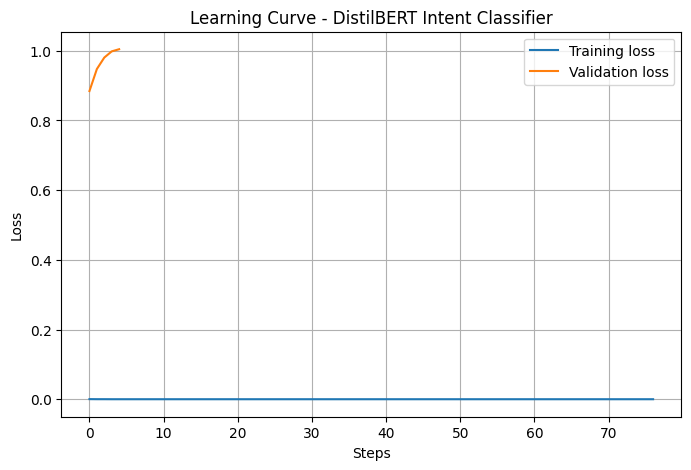

In [70]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history  # لستة من الدكتشنري

train_losses = [entry["loss"] for entry in logs if "loss" in entry]
eval_losses  = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
eval_epochs  = [entry["epoch"] for entry in logs if "eval_loss" in entry]

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training loss")
plt.plot(
    range(len(eval_losses)), 
    eval_losses, 
    label="Validation loss"
)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curve - DistilBERT Intent Classifier")
plt.legend()
plt.grid(True)
plt.show()


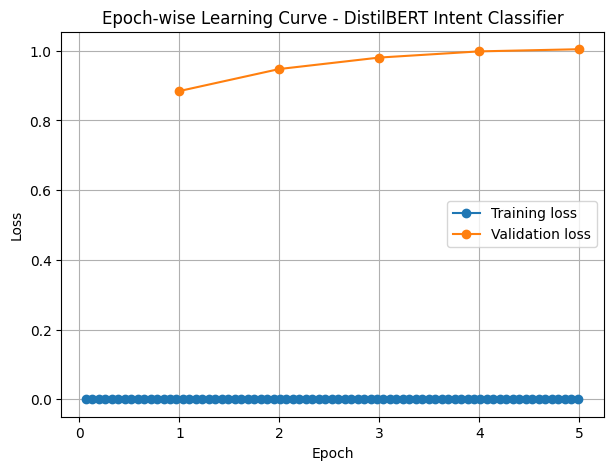

In [71]:
import numpy as np
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_epochs = {}
eval_epochs  = {}
for entry in logs:
    if "loss" in entry and "epoch" in entry:
        train_epochs.setdefault(entry["epoch"], []).append(entry["loss"])
    if "eval_loss" in entry and "epoch" in entry:
        eval_epochs[entry["epoch"]] = entry["eval_loss"]

train_epoch_vals = sorted((e, np.mean(v)) for e, v in train_epochs.items())
eval_epoch_vals  = sorted((e, l) for e, l in eval_epochs.items())

plt.figure(figsize=(7,5))
plt.plot([e for e,_ in train_epoch_vals],
         [l for _,l in train_epoch_vals],
         marker="o", label="Training loss")
plt.plot([e for e,_ in eval_epoch_vals],
         [l for _,l in eval_epoch_vals],
         marker="o", label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch-wise Learning Curve - DistilBERT Intent Classifier")
plt.legend()
plt.grid(True)
plt.show()


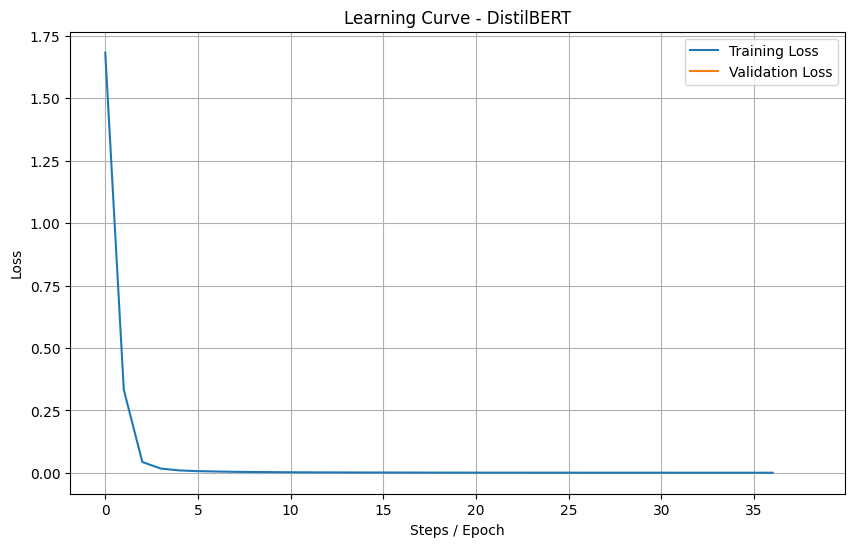

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# نحتفظ فقط بالحقول المهمة
logs = logs[["loss", "eval_loss", "epoch"]]

plt.figure(figsize=(10,6))
plt.plot(logs["loss"], label="Training Loss")
plt.plot(logs["eval_loss"], label="Validation Loss")
plt.xlabel("Steps / Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve - DistilBERT")
plt.legend()
plt.grid(True)
plt.show()


In [66]:
train_result = trainer.train()
trainer.save_model("./bert_intent_clean")
trainer.save_state()


AttributeError: `AcceleratorState` object has no attribute `distributed_type`. This happens if `AcceleratorState._reset_state()` was called and an `Accelerator` or `PartialState` was not reinitialized.

In [39]:
train_raw = pd.read_csv("/kaggle/input/data-split2/train_split.csv")
valid_raw = pd.read_csv("/kaggle/input/data-split2/valid_split.csv")
test_raw  = pd.read_csv("/kaggle/input/data-split2/test_split.csv")

print(train_raw.shape, valid_raw.shape, test_raw.shape)
print(train_raw.columns)


(11392, 6) (1424, 6) (1425, 6)
Index(['path', 'transcription', 'action', 'object', 'full_path', 'pair'], dtype='object')


In [40]:
TEXT_COL = "transcription"

def add_pair(df):
    df = df.copy()
    if "pair" not in df.columns:
        df["pair"] = df["action"] + " → " + df["object"]
    return df

train_raw = add_pair(train_raw)
valid_raw = add_pair(valid_raw)
test_raw  = add_pair(test_raw)

train_raw[[TEXT_COL, "action", "object", "pair"]].head()


,transcription,action,object,pair
0,Turn off the lights,deactivate,lights,deactivate → lights
1,Turn the bathroom lights on,activate,lights,activate → lights
2,Switch the lights on,activate,lights,activate → lights
3,Turn off the kitchen lights,deactivate,lights,deactivate → lights
4,Stop,deactivate,music,deactivate → music


In [37]:
train_df = train_raw.drop_duplicates(subset=TEXT_COL).reset_index(drop=True)
valid_df = valid_raw.drop_duplicates(subset=TEXT_COL).reset_index(drop=True)
test_df  = test_raw.drop_duplicates(subset=TEXT_COL).reset_index(drop=True)

print("Train:", train_df.shape, "Valid:", valid_df.shape, "Test:", test_df.shape)


Train: (115, 6) Valid: (115, 6) Test: (115, 6)


In [41]:
train_texts = set(train_df[TEXT_COL])

valid_df = valid_df[~valid_df[TEXT_COL].isin(train_texts)].reset_index(drop=True)
test_df  = test_df[~test_df[TEXT_COL].isin(train_texts)].reset_index(drop=True)

print("After removing leak from valid/test:")
print("Train:", train_df.shape, "Valid:", valid_df.shape, "Test:", test_df.shape)

overlap = set(train_df[TEXT_COL]).intersection(set(test_df[TEXT_COL]))
print("Overlap train/test:", len(overlap))


After removing leak from valid/test:
Train: (115, 6) Valid: (0, 6) Test: (0, 6)
Overlap train/test: 0


In [32]:
# دمج كل البيانات النصية
all_df = pd.concat([train_raw, valid_raw, test_raw], ignore_index=True)

print("Before dedup:", all_df.shape)

# حذف أي تكرار في النص
all_df = all_df.drop_duplicates(subset=TEXT_COL).reset_index(drop=True)

print("After dedup:", all_df.shape)
print("Internal duplicates:", all_df.duplicated(subset=TEXT_COL).sum())


Before dedup: (14241, 6)
After dedup: (115, 6)
Internal duplicates: 0


In [34]:
# 1) split أساساً: 70% train, 30% temp (stratified)
train_df, temp_df = train_test_split(
    all_df,
    test_size=0.30,
    random_state=42,
    stratify=all_df[LABEL_COL]
)

# 2) من temp → valid و test بدون stratify (بس random)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

print("Train size:", len(train_df))
print("Valid size:", len(valid_df))
print("Test size :", len(test_df))


Train size: 80
Valid size: 17
Test size : 18


In [ ]:
import os
os._exit(00)


In [3]:
TEXT_COL = "transcription"


In [4]:
def add_pair(df):
    df = df.copy()
    if "pair" not in df.columns:
        df["pair"] = df["action"] + " → " + df["object"]
    return df

train_df = add_pair(train_df)
valid_df = add_pair(valid_df)
test_df  = add_pair(test_df)


In [5]:
train_df[["transcription", "action", "object", "pair"]].head()


,transcription,action,object,pair
0,Switch on the washroom lights,activate,lights,activate → lights
1,Switch the lights on,activate,lights,activate → lights
2,Switch on the kitchen lights,activate,lights,activate → lights
3,Switch the lights on,activate,lights,activate → lights
4,Lights on in the bathroom,activate,lights,activate → lights


In [7]:
# استخراج جميع ال labels
unique_labels = sorted(train_df["pair"].unique())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

print("Unique labels:", unique_labels)
print("label2id:", label2id)

# إضافة عمود label_id الرقمي
train_df["label_id"] = train_df["pair"].map(label2id)
valid_df["label_id"] = valid_df["pair"].map(label2id)
test_df["label_id"]  = test_df["pair"].map(label2id)


Unique labels: ['activate → lights', 'activate → music', 'change language → English', 'deactivate → lights', 'deactivate → music', 'decrease → volume', 'increase → volume']
label2id: {'activate → lights': 0, 'activate → music': 1, 'change language → English': 2, 'deactivate → lights': 3, 'deactivate → music': 4, 'decrease → volume': 5, 'increase → volume': 6}


In [8]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label_id"]])
valid_ds = Dataset.from_pandas(valid_df[[TEXT_COL, "label_id"]])
test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, "label_id"]])

print(train_ds)
print(train_ds[0])


Dataset({
    features: ['transcription', 'label_id'],
    num_rows: 7000
})
{'transcription': 'Switch on the washroom lights', 'label_id': 0}


In [ ]:
save_dir = "/kaggle/working/bert_intent_final"

trainer.save_model(save_dir)          # يحفظ أوزان النموذج + config
tokenizer.save_pretrained(save_dir)   # يحفظ التوكننايزر
print("Model saved to:", save_dir)


In [2]:
import shutil
import os

folder_path = "/kaggle/working/features_whisper"  # غيّري المسار حسب الحاجة

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"✅ Deleted folder: {folder_path}")
else:
    print(f"⚠️ Folder not found: {folder_path}")


⚠️ Folder not found: /kaggle/working/features_whisper


In [13]:
import shutil

# المسار إلى المجلد الذي يحتوي على الميزات السابقة
features_dir = "/kaggle/working/features_whisper"

# حذف المجلد بالكامل إذا كان موجوداً
if os.path.exists(features_dir):
    shutil.rmtree(features_dir)
    print(f"Deleted existing directory: {features_dir}")


Deleted existing directory: /kaggle/working/features_whisper


In [14]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

MODEL_NAME = "openai/whisper-small"

processor = WhisperProcessor.from_pretrained(MODEL_NAME)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

# Feature extraction(delta delta_delta MFCC)

In [15]:
import os
import pandas as pd
import numpy as np
import torch
import torchaudio
from tqdm import tqdm


# ======================================================
# 2️⃣ المسارات الدقيقة للبيانات
# ======================================================
paths = {
    "train": "/kaggle/input/traine-mapped-balance/train_hybrid_balanced_down (2).csv",
    "valid": "/kaggle/input/data-split2/valid_split.csv",
    "test":  "/kaggle/input/data-split2/test_split.csv"
}

OUT_DIR = "/kaggle/working/features_whisper"
os.makedirs(OUT_DIR, exist_ok=True)

In [16]:
# ======================================================
# 3️⃣ دالة تحميل الصوت وتحضيره
# ======================================================
def load_mono_16k(path):
    """قراءة الصوت وتحويله إلى 16kHz قناة واحدة"""
    y, sr = torchaudio.load(path)
    if y.ndim > 1:
        y = y.mean(0, keepdim=True)
    if sr != 16000:
        y = torchaudio.functional.resample(y, sr, 16000)
    return y.squeeze(0)

In [ ]:
# ======================================================
# 3️⃣ دالة التحميل والمعالجة (Mono + 16kHz + Padding)
# ======================================================
def process_and_save_audio(input_path, output_path):
    try:
        y, sr = sf.read(input_path, always_2d=True)
        y = torch.tensor(y.mean(axis=1), dtype=torch.float32)  # تحويل إلى mono

        if sr != TARGET_SR:
            y = torchaudio.functional.resample(y.unsqueeze(0), sr, TARGET_SR).squeeze(0)

        # تحويل إلى Mel spectrogram للتحقق من الطول
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SR, n_fft=400, hop_length=160
        )(y.unsqueeze(0))

        if mel.shape[-1] < TARGET_LEN:
            pad_len = TARGET_LEN - mel.shape[-1]
            mel = torch.nn.functional.pad(mel, (0, pad_len))

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        torchaudio.save(output_path, y.unsqueeze(0), TARGET_SR)
        return True

    except Exception:
        # نتجاهل أي خطأ بدون طباعة
        return False



In [17]:
# ======================================================
# 4️⃣ دالة استخراج الميزات لمجموعة واحدة
# ======================================================
def extract_whisper_embeddings(df, split_name):
    embeds, kept_idx = [], []
    short_count = 0

    for i, row in enumerate(tqdm(df.itertuples(), total=len(df), desc=f"Extracting {split_name}")):
        path = row.full_path
        if not os.path.exists(path):
            continue
        try:
            y = load_mono_16k(path)
            inputs = processor(y.numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
            input_features = inputs.input_features

            # معالجة الملفات القصيرة
            if input_features.shape[-1] < 3000:
                pad_len = 3000 - input_features.shape[-1]
                input_features = torch.nn.functional.pad(input_features, (0, pad_len))
                short_count += 1

            with torch.no_grad():
                encoder_out = model.encoder(input_features.to(DEVICE))
                pooled = encoder_out.last_hidden_state.mean(dim=1).cpu().numpy().squeeze()

            embeds.append(pooled)
            kept_idx.append(i)

            if i % 500 == 0 and i > 0:
                print(f"Processed {i}/{len(df)} files in {split_name}")

        except Exception as e:
            print(f" Skip {path}: {e}")
            continue

    if len(embeds) > 0:
        embeds = np.vstack(embeds)
        feature_cols = [f"f{i}" for i in range(embeds.shape[1])]
        emb_df = pd.DataFrame(embeds, columns=feature_cols)

        # الأعمدة التعريفية
        emb_df["action"] = df.iloc[kept_idx]["action"].values
        emb_df["object"] = df.iloc[kept_idx]["object"].values
        emb_df["pair"] = df.iloc[kept_idx]["pair"].values
        emb_df["full_path"] = df.iloc[kept_idx]["full_path"].values

        out_path = os.path.join(OUT_DIR, f"whisper_{split_name}.csv")
        emb_df.to_csv(out_path, index=False)

        print(f"Saved embeddings for {split_name}: {emb_df.shape}")
        print(f"File saved to: {out_path}")
        print(f"Short audio padded: {short_count}/{len(df)}\n")
    else:
        print(f"No embeddings extracted for {split_name}")

In [6]:

FEATURE_DIR = "/kaggle/input/whisper-features"

train_df = pd.read_csv(os.path.join(FEATURE_DIR, "whisper_train.csv"))
valid_df = pd.read_csv(os.path.join(FEATURE_DIR, "whisper_valid.csv"))
test_df  = pd.read_csv(os.path.join(FEATURE_DIR, "whisper_test.csv"))

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (6087, 516)
Valid: (1424, 516)
Test: (1425, 516)


In [7]:
# أعمدة الميزات
feature_cols = [c for c in train_df.columns if c.startswith("f")]

X_train = train_df[feature_cols].values
y_train = train_df["pair"].values

X_valid = valid_df[feature_cols].values
y_valid = valid_df["pair"].values

X_test  = test_df[feature_cols].values
y_test  = test_df["pair"].values


Using 513 numeric features
Unique pairs: 8
Running PCA...
Running t-SNE (takes ~1-2 min)...


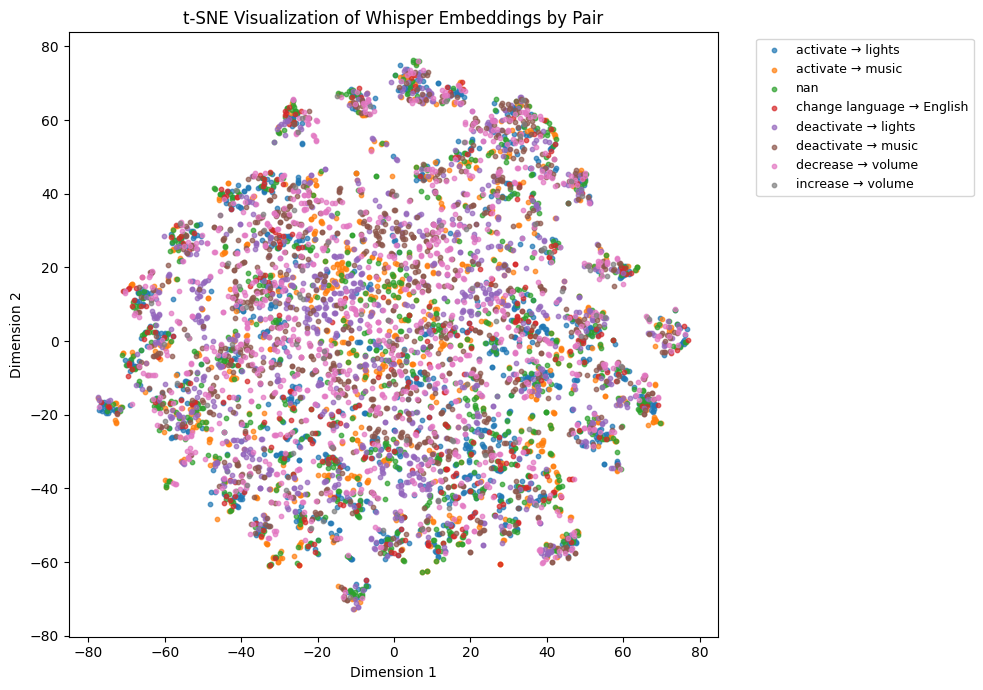

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ======================================================
# تحميل البيانات
# ======================================================
path = "/kaggle/working/features_normalized/train_normalized.csv"
df = pd.read_csv(path)

# تأكدي من الأعمدة العددية فقط (تبدأ بـ f)
feature_cols = [c for c in df.columns if c.startswith("f")]
X = df[feature_cols].select_dtypes(include=["float", "int"]).values

# تأكدي من وجود العمود pair (إذا غير موجود خذيه من action + object)
if "pair" in df.columns:
    pairs = df["pair"].astype(str)
else:
    pairs = df.apply(lambda r: f"{r['action']} → {r['object']}", axis=1)

print(f"Using {len(feature_cols)} numeric features")
print(f"Unique pairs: {pairs.nunique()}")

# ======================================================
# اختزال الأبعاد
# ======================================================
print("Running PCA...")
X_pca = PCA(n_components=min(50, X.shape[1])).fit_transform(X)

print("Running t-SNE (takes ~1-2 min)...")
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_pca)

# ======================================================
# رسم النتائج
# ======================================================
plt.figure(figsize=(10, 7))
unique_pairs = pairs.unique()

for p in unique_pairs:
    idx = pairs == p
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], s=10, alpha=0.7, label=p)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.title("t-SNE Visualization of Whisper Embeddings by Pair")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_pca, pairs)
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: -0.015


In [10]:
print(train_df.columns)

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'action', 'object',
       'pair', 'full_path'],
      dtype='object', length=516)


In [11]:
import os
import shutil
import pandas as pd
import torch
import torchaudio
import soundfile as sf
from tqdm import tqdm
# ======================================================
# 1️⃣ حذف المجلدات القديمة (تنظيف كامل)
# ======================================================
folders_to_delete = [
"/kaggle/working/audio_processed"
]

for folder in folders_to_delete:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"🗑️ Deleted old folder: {folder}")
    else:
        print(f"⚠️ Folder not found: {folder}")

⚠️ Folder not found: /kaggle/working/audio_processed


In [9]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [12]:
import os
import pandas as pd
import torchaudio
from tqdm import tqdm

# ======================================================
# 1️⃣ إعداد المسارات
# ======================================================
RAW_BASE = "/kaggle/input/fluent-speech-commands/fluent_speech_commands_dataset/wavs/speakers"
FINAL_DIR = "/kaggle/working/audio_processed"

AUDIO_OUT = os.path.join(FINAL_DIR, "audio")
CSV_OUT = os.path.join(FINAL_DIR, "csv")
os.makedirs(AUDIO_OUT, exist_ok=True)
os.makedirs(CSV_OUT, exist_ok=True)

In [12]:
# ملفات المجموعات الثلاث
paths = {
    "train": "/kaggle/input/traine-balanced7000/train_hybrid_balanced_down.csv",
    "valid": "/kaggle/input/data-splits/valid_split.csv",
    "test":  "/kaggle/input/data-splits/test_split.csv"
}

TARGET_SR = 16000
TARGET_LEN = 3000  # عدد الإطارات بعد تحويلها لميل spectrogram

In [13]:
# ======================================================
# 3️⃣ دالة التحميل والمعالجة (Mono + 16kHz + Padding)
# ======================================================
def process_and_save_audio(input_path, output_path):
    try:
        y, sr = sf.read(input_path, always_2d=True)
        y = torch.tensor(y.mean(axis=1), dtype=torch.float32)  # تحويل إلى mono

        if sr != TARGET_SR:
            y = torchaudio.functional.resample(y.unsqueeze(0), sr, TARGET_SR).squeeze(0)

        # تحويل إلى Mel spectrogram للتحقق من الطول
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SR, n_fft=400, hop_length=160
        )(y.unsqueeze(0))

        if mel.shape[-1] < TARGET_LEN:
            pad_len = TARGET_LEN - mel.shape[-1]
            mel = torch.nn.functional.pad(mel, (0, pad_len))

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        torchaudio.save(output_path, y.unsqueeze(0), TARGET_SR)
        return True

    except Exception:
        # نتجاهل أي خطأ بدون طباعة
        return False



In [14]:
# ======================================================
# 4️⃣ تنفيذ المعالجة لكل مجموعة بيانات
# ======================================================
for split_name, csv_path in paths.items():
    if not os.path.exists(csv_path):
        print(f"Skip {split_name} (CSV not found)")
        continue

    df = pd.read_csv(csv_path)
    print(f"Processing {split_name}: {df.shape}")

    new_paths = []
    for i, path in enumerate(tqdm(df["full_path"], desc=f"{split_name} processing")):
        rel = os.path.relpath(path, RAW_BASE)
        new_path = os.path.join(AUDIO_OUT, rel)
        ok = process_and_save_audio(path, new_path)
        new_paths.append(new_path if ok else None)

        if i % 1000 == 0 and i > 0:
            print(f"{i}/{len(df)} files done in {split_name}")

    df["full_path"] = new_paths
    df = df.dropna(subset=["full_path"]).reset_index(drop=True)
    out_csv = os.path.join(CSV_OUT, f"{split_name}_processed.csv")
    df.to_csv(out_csv, index=False)
    print(f"Saved CSV: {out_csv} ({df.shape})")

print("All audio processed & saved inside:", FINAL_DIR)

Processing train: (7000, 6)


train processing:   0%|          | 0/7000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
train processing:  15%|█▍        | 1019/7000 [00:16<01:13, 81.09it/s]

1000/7000 files done in train


train processing:  29%|██▉       | 2042/7000 [00:27<00:33, 149.33it/s]

2000/7000 files done in train


train processing:  43%|████▎     | 3004/7000 [00:32<00:25, 156.04it/s]

3000/7000 files done in train


train processing:  57%|█████▋    | 4008/7000 [00:48<00:51, 58.37it/s] 

4000/7000 files done in train


train processing:  72%|███████▏  | 5015/7000 [01:03<00:27, 71.61it/s]

5000/7000 files done in train


train processing:  86%|████████▌ | 6009/7000 [01:19<00:15, 64.65it/s]

6000/7000 files done in train


train processing: 100%|██████████| 7000/7000 [01:34<00:00, 73.81it/s]


Saved CSV: /kaggle/working/audio_processed/csv/train_processed.csv ((6087, 6))
Processing valid: (1424, 6)


valid processing:   0%|          | 0/1424 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
valid processing:  71%|███████   | 1013/1424 [00:16<00:06, 61.48it/s]

1000/1424 files done in valid


valid processing: 100%|██████████| 1424/1424 [00:22<00:00, 62.68it/s]


Saved CSV: /kaggle/working/audio_processed/csv/valid_processed.csv ((1424, 6))
Processing test: (1425, 6)


test processing:   0%|          | 0/1425 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
test processing:  71%|███████   | 1010/1425 [00:15<00:06, 65.58it/s]

1000/1425 files done in test


test processing: 100%|██████████| 1425/1425 [00:22<00:00, 63.68it/s]


Saved CSV: /kaggle/working/audio_processed/csv/test_processed.csv ((1425, 6))
All audio processed & saved inside: /kaggle/working/audio_processed


# *Whisper*

# Draft

In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torchaudio
from tqdm import tqdm
from transformers import WhisperProcessor, WhisperModel


# ======================================================
# 2️⃣ المسارات الدقيقة للبيانات
# ======================================================
paths = {
    "train": "/kaggle/input/traine-balanced7000/train_hybrid_balanced_down.csv",
    "valid": "/kaggle/input/data-splits/valid_split.csv",
    "test":  "/kaggle/input/data-splits/test_split.csv"
}

OUT_DIR = "/kaggle/working/features_whisper"
os.makedirs(OUT_DIR, exist_ok=True)

# ======================================================
# 3️⃣ دالة تحميل الصوت وتحضيره
# ======================================================
def load_mono_16k(path):
    """قراءة الصوت وتحويله إلى 16kHz قناة واحدة"""
    y, sr = torchaudio.load(path)
    if y.ndim > 1:
        y = y.mean(0, keepdim=True)
    if sr != 16000:
        y = torchaudio.functional.resample(y, sr, 16000)
    return y.squeeze(0)

# ======================================================
# 4️⃣ دالة استخراج الميزات لمجموعة واحدة
# ======================================================
def extract_whisper_embeddings(df, split_name):
    embeds, kept_idx = [], []
    short_count = 0  # لتسجيل عدد الملفات القصيرة التي تم تعديلها

    for i, row in enumerate(tqdm(df.itertuples(), total=len(df), desc=f"Extracting {split_name}")):
        path = row.full_path
        if not os.path.exists(path):
            continue
        try:
            y = load_mono_16k(path)
            inputs = processor(y.numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
            input_features = inputs.input_features

            # معالجة الملفات القصيرة (Padding)
            if input_features.shape[-1] < 3000:
                pad_len = 3000 - input_features.shape[-1]
                input_features = torch.nn.functional.pad(input_features, (0, pad_len))
                short_count += 1

            # استخراج الميزات من الـ encoder
            with torch.no_grad():
                encoder_out = model.encoder(input_features.to(DEVICE))
                pooled = encoder_out.last_hidden_state.mean(dim=1).cpu().numpy().squeeze()

            embeds.append(pooled)
            kept_idx.append(i)

            if i % 500 == 0 and i > 0:
                print(f"✅ Processed {i}/{len(df)} files in {split_name}")

        except Exception as e:
            print(f"⚠️ Skip {path}: {e}")
            continue

    # حفظ النتائج بعد الانتهاء من المجموعة
    if len(embeds) > 0:
        embeds = np.vstack(embeds)
        meta = df.iloc[kept_idx][["full_path", "action", "object"]].reset_index(drop=True)

        feature_cols = [f"f{i}" for i in range(embeds.shape[1])]
        emb_df = pd.DataFrame(embeds, columns=feature_cols)

       # نضيف كل الأعمدة التعريفية
       emb_df["action"] = df.iloc[kept_idx]["action"].values
       emb_df["object"] = df.iloc[kept_idx]["object"].values
       emb_df["pair"]   = df.iloc[kept_idx].apply(lambda r: f"{r['action']} → {r['object']}", axis=1)
       emb_df["full_path"] = df.iloc[kept_idx]["full_path"].values

       # حفظ الملف النهائي
       out_path = os.path.join(OUT_DIR, f"whisper_{split_name}.csv")
       emb_df.to_csv(out_path, index=False)
       print(f"✅ Saved {split_name} embeddings: {emb_df.shape} → {out_path}")


        print(f"\n✅ Saved embeddings for {split_name}: {emb_df.shape}")
        print(f"📦 File saved to: {out_path}")
        print(f"📉 Short audio padded: {short_count}/{len(df)}\n")
    else:
        print(f"⚠️ No embeddings extracted for {split_name}")

# ======================================================
# 5️⃣ تنفيذ العملية لكل مجموعة بيانات
# ======================================================
for split_name, file_path in paths.items():
    if not os.path.exists(file_path):
        print(f"⚠️ Skip {split_name} (file not found)")
        continue

    df = pd.read_csv(file_path)
    print(f"📂 Loaded {split_name}: {df.shape}")
    extract_whisper_embeddings(df, split_name)


📂 Loaded train: (7000, 6)


Extracting train:   0%|          | 0/7000 [00:00<?, ?it/s]2025-11-09 16:28:03.683044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762705683.705052     131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762705683.711769     131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Extracting train:   7%|▋         | 504/7000 [00:23<04:29, 24.06it/s]

✅ Processed 500/7000 files in train


Extracting train:  14%|█▍        | 1008/7000 [00:44<03:15, 30.70it/s]

✅ Processed 1000/7000 files in train


Extracting train:  43%|████▎     | 3002/7000 [01:30<01:21, 48.94it/s] 

✅ Processed 3000/7000 files in train


Extracting train:  50%|█████     | 3504/7000 [01:52<02:46, 21.06it/s]

✅ Processed 3500/7000 files in train


Extracting train:  57%|█████▋    | 4005/7000 [02:14<02:09, 23.10it/s]

✅ Processed 4000/7000 files in train


Extracting train:  64%|██████▍   | 4503/7000 [02:36<01:46, 23.47it/s]

✅ Processed 4500/7000 files in train


Extracting train:  71%|███████▏  | 5004/7000 [02:57<01:27, 22.83it/s]

✅ Processed 5000/7000 files in train


Extracting train:  79%|███████▊  | 5505/7000 [03:18<01:04, 23.03it/s]

✅ Processed 5500/7000 files in train


Extracting train:  86%|████████▌ | 6003/7000 [03:40<00:56, 17.64it/s]

✅ Processed 6000/7000 files in train


Extracting train:  93%|█████████▎| 6504/7000 [04:02<00:21, 23.12it/s]

✅ Processed 6500/7000 files in train


Extracting train: 100%|██████████| 7000/7000 [04:23<00:00, 26.52it/s]



✅ Saved embeddings for train: (6087, 515)
📦 File saved to: /kaggle/working/features_whisper/whisper_train.csv
📉 Short audio padded: 6087/7000

📂 Loaded valid: (1424, 6)


Extracting valid:  35%|███▌      | 504/1424 [00:22<00:39, 23.32it/s]

✅ Processed 500/1424 files in valid


Extracting valid:  71%|███████   | 1005/1424 [00:44<00:18, 22.94it/s]

✅ Processed 1000/1424 files in valid


Extracting valid: 100%|██████████| 1424/1424 [01:02<00:00, 22.87it/s]



✅ Saved embeddings for valid: (1424, 515)
📦 File saved to: /kaggle/working/features_whisper/whisper_valid.csv
📉 Short audio padded: 1424/1424

📂 Loaded test: (1425, 6)


Extracting test:  35%|███▌      | 504/1425 [00:21<00:40, 22.75it/s]

✅ Processed 500/1425 files in test


Extracting test:  71%|███████   | 1005/1425 [00:43<00:18, 22.45it/s]

✅ Processed 1000/1425 files in test


Extracting test: 100%|██████████| 1425/1425 [01:01<00:00, 23.05it/s]



✅ Saved embeddings for test: (1425, 515)
📦 File saved to: /kaggle/working/features_whisper/whisper_test.csv
📉 Short audio padded: 1425/1425



In [ ]:
import os
import pandas as pd
import numpy as np
import whisper
import soundfile as sf
from tqdm import tqdm

# المسار لملفك الحالي بعد التوازن
DATA_PATH = "/kaggle/input/balanced-data7000/train_hybrid_balanced_down.csv"
OUT_PATH = "/kaggle/working/features/whisper_embeddings_train.csv"

os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)

# تحميل البيانات
df = pd.read_csv(DATA_PATH)
df["pair"] = df["action"] + " → " + df["object"]
print("Loaded:", df.shape)

# تحميل نموذج Whisper
model = whisper.load_model("base")  # أو "small" لو متوفر GPU أقوى

# دالة استخراج الميزات (embedding)
def extract_embedding(audio_path):
    try:
        audio = whisper.load_audio(audio_path)
        audio = whisper.pad_or_trim(audio)
        mel = whisper.log_mel_spectrogram(audio).to(model.device)
        with torch.no_grad():
            features = model.encoder(mel.unsqueeze(0)).squeeze(0).mean(dim=0).cpu().numpy()
        return features
    except Exception as e:
        print(f"Error with {audio_path}: {e}")
        return np.zeros(512)  # feature بحجم 512 كاحتياط

# استخراج الميزات
features, labels = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    emb = extract_embedding(row["full_path"])
    features.append(emb)
    labels.append(row["pair"])

# تحويل للـ DataFrame
X = np.vstack(features)
feature_cols = [f"f{i}" for i in range(X.shape[1])]
features_df = pd.DataFrame(X, columns=feature_cols)
features_df["pair"] = labels

features_df.to_csv(OUT_PATH, index=False)
print("Saved embeddings to:", OUT_PATH)


In [ ]:
import shutil
import os

folder_path = "/kaggle/working/aug_pairs_hybrid"  # عدّلي المسار هنا

if os.path.isdir(folder_path):
    shutil.rmtree(folder_path)
    print(f"✅ Folder and all contents deleted: {folder_path}")
else:
    print(f"⚠️ Folder not found: {folder_path}")


Pair counts before balancing:
pair
activate → lights            2892
activate → music              730
change language → English     357
deactivate → lights          2161
deactivate → music           1250
decrease → volume            1395
increase → volume            2607
Name: count, dtype: int64

Number of unique pairs: 7

Pair counts after balancing:
pair
activate → lights            2892
activate → music              730
change language → English     357
deactivate → lights          2161
deactivate → music           1250
decrease → volume            1395
increase → volume            2607
Name: count, dtype: int64

Total samples after balancing: 11392

✅ Balanced dataset saved at: /kaggle/working/data_balanced/train_balanced_soft.csv


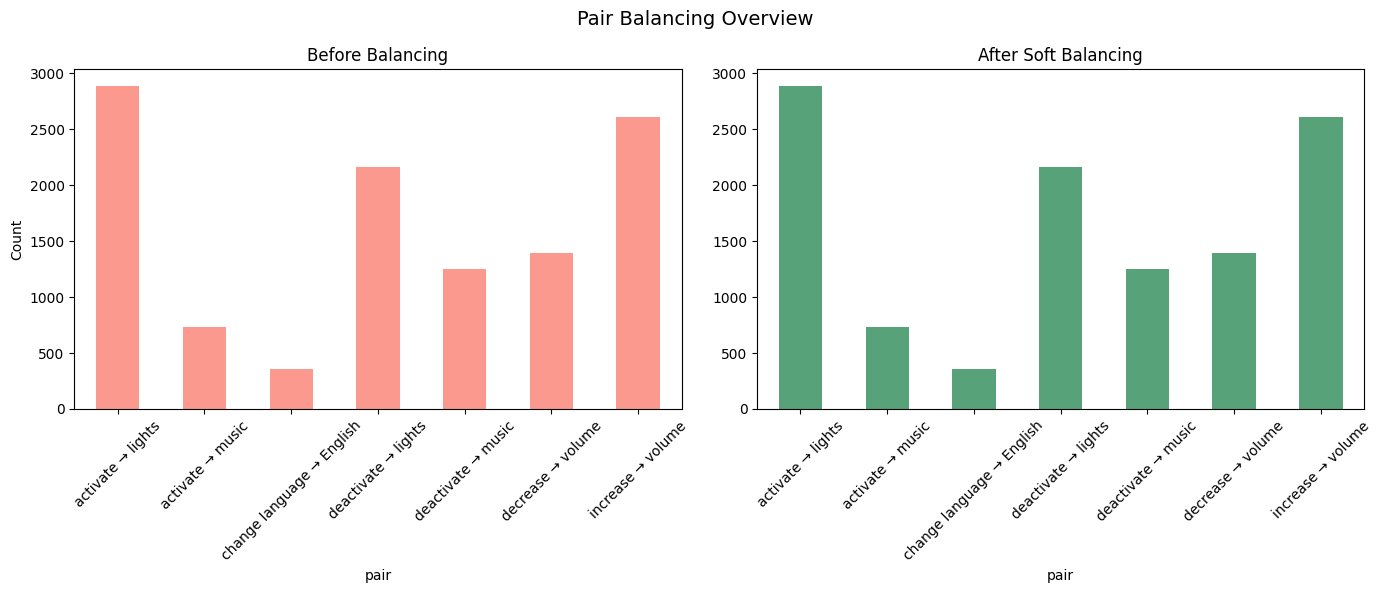

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======================================================
# ⚙️ STEP 1: تحميل بيانات التدريب بعد التقسيم
# ======================================================
BASE_DIR = "/kaggle/input/data-splits"
train_path = os.path.join(BASE_DIR, "train_split.csv")
train_df = pd.read_csv(train_path)

# ======================================================
# ⚙️ STEP 2: حساب الأزواج
# ======================================================
train_df["pair"] = train_df["action"] + " → " + train_df["object"]
pair_counts = train_df["pair"].value_counts().sort_index()

print("Pair counts before balancing:")
print(pair_counts)
print("\nNumber of unique pairs:", len(pair_counts))

# ======================================================
# ⚙️ STEP 3: موازنة الأزواج (Soft Balancing)
# ======================================================
def balance_pairs_soft(df, target=200, random_state=42):
    np.random.seed(random_state)
    balanced = []
    groups = list(df.groupby(["action", "object"]))

    for (act, obj), subset in groups:
        n = len(subset)
        if n < target:
            # توليد عينات مكررة مع Aug لاحقًا أو بدون Aug الآن
            idx = np.random.randint(0, n, target - n)
            subset_aug = subset.iloc[idx].copy()
            balanced.append(pd.concat([subset, subset_aug], ignore_index=True))
        else:
            balanced.append(subset)
    return pd.concat(balanced, ignore_index=True)

TARGET = 200   # يمكنك تعديله حسب الملاحظات السابقة (175–230 آمن جداً)
balanced_train_df = balance_pairs_soft(train_df, target=TARGET)

# ======================================================
# ⚙️ STEP 4: عرض النتائج بعد الموازنة
# ======================================================
pair_counts_after = balanced_train_df["pair"].value_counts().sort_index()

print("\nPair counts after balancing:")
print(pair_counts_after)
print("\nTotal samples after balancing:", len(balanced_train_df))

# ======================================================
# ⚙️ STEP 5: حفظ النسخة النهائية + رسم التوزيع
# ======================================================
out_dir = "/kaggle/working/data_balanced"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "train_balanced_soft.csv")
balanced_train_df.to_csv(out_path, index=False)
print(f"\n✅ Balanced dataset saved at: {out_path}")

# ======================================================
# 📊 Visualization
# ======================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Pair Balancing Overview", fontsize=14)

pair_counts.plot.bar(ax=axes[0], color="salmon", alpha=0.8)
axes[0].set_title("Before Balancing")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)

pair_counts_after.plot.bar(ax=axes[1], color="seagreen", alpha=0.8)
axes[1].set_title("After Soft Balancing")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


In [54]:
import os, numpy as np, pandas as pd, librosa, soundfile as sf
from tqdm import tqdm

# ======================================================
# ⚙️ 1. إعداد المسارات
# ======================================================
SOURCE_CSV = "/kaggle/input/data-final/data_final/splits/train_final.csv"  # غيّري المسار حسب موقع ملفك
OUT_DIR = "/kaggle/working/data_final_balanced"
AUG_DIR = os.path.join(OUT_DIR, "aug_pool")

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(AUG_DIR, exist_ok=True)

# ======================================================
# 🧾 2. تحميل البيانات الأصلية
# ======================================================
df = pd.read_csv(SOURCE_CSV)
df = df.dropna(subset=["action", "object", "full_path"])
print(f"✅ Loaded dataset: {df.shape}")

# ======================================================
# 🎛️ 3. دالة Augmentation متنوعة
# ======================================================
def augment_audio(y, sr):
    y = y / (np.max(np.abs(y)) + 1e-8)
    # shift (إزاحة زمنية)
    if np.random.rand() < 0.5:
        shift = int(np.random.uniform(-0.08, 0.08) * len(y))
        y = np.roll(y, shift)
    # pitch shift
    if np.random.rand() < 0.4:
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=np.random.uniform(-1, 1))
    # time stretch
    if np.random.rand() < 0.4:
        y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
    # noise injection
    if np.random.rand() < 0.5:
        y = y + np.random.randn(len(y)) * 0.005
    return y

# ======================================================
# 🔁 4. Augmentation عام (نسخة واحدة من كل ملف)
# ======================================================
aug_rows = []
for _, r in tqdm(df.iterrows(), total=len(df), desc="Building Aug Pool"):
    p = r["full_path"]
    try:
        y, sr = librosa.load(p, sr=16000, mono=True)
    except:
        continue
    y2 = augment_audio(y, sr)
    new_path = os.path.join(AUG_DIR, f"aug_{os.path.basename(p)}")
    sf.write(new_path, y2, sr)
    new_r = r.copy()
    new_r["full_path"] = new_path
    new_r["is_aug"] = 1
    aug_rows.append(new_r)

aug_df = pd.DataFrame(aug_rows)
print(f"✅ Augmented samples generated: {len(aug_df)}")

# ======================================================
# ⚖️ 5. موازنة الأزواج (باستخدام الأصل + aug_pool)
# ======================================================
def balance_pairs_with_aug(orig_df, aug_df, target=None, random_state=42):
    df = pd.concat([orig_df.assign(is_aug=0), aug_df], ignore_index=True)
    groups = df.groupby(["action", "object"])
    counts = groups.size()
    if target is None:
        target = int(np.median(counts))  # هدف منطقي بدون تضخيم مفرط

    rng = np.random.default_rng(random_state)
    new_groups = []
    for (act, obj), g in groups:
        n = len(g)
        if n < target:
            g_aug = aug_df[(aug_df["action"]==act)&(aug_df["object"]==obj)]
            need = target - n
            if len(g_aug) > 0:
                add = g_aug.sample(n=min(need, len(g_aug)), replace=(len(g_aug)<need),
                                   random_state=rng.integers(0,9999))
            else:
                add = g.sample(n=need, replace=True, random_state=rng.integers(0,9999))
            g_bal = pd.concat([g, add], ignore_index=True)
        elif n > target:
            g_bal = g.sample(n=target, random_state=rng.integers(0,9999))
        else:
            g_bal = g
        new_groups.append(g_bal)

    out = pd.concat(new_groups, ignore_index=True)
    return out

final_df = balance_pairs_with_aug(df, aug_df)
print("✅ After balancing:", final_df.shape)
print(final_df.groupby(["action", "object"]).size())

# ======================================================
# 💾 6. حفظ النسخة النهائية
# ======================================================
final_path = os.path.join(OUT_DIR, "train_aug_balanced_final.csv")
final_df.to_csv(final_path, index=False)
print(f"\n💾 Final balanced dataset saved at: {final_path}")


✅ Loaded dataset: (17713, 8)


Building Aug Pool: 100%|██████████| 17713/17713 [05:10<00:00, 57.12it/s]


✅ Augmented samples generated: 17713
✅ After balancing: (35420, 9)
action           object 
activate         lights     5060
                 music      5060
change language  English    5060
deactivate       lights     5060
                 music      5060
decrease         volume     5060
increase         volume     5060
dtype: int64

💾 Final balanced dataset saved at: /kaggle/working/data_final_balanced/train_aug_balanced_final.csv


✅ Loaded: /kaggle/working/data_final_balanced/train_aug_balanced.csv
Rows: 26707
Unique pairs: 7
pair
activate → lights            3847
activate → music             3812
change language → English    3812
deactivate → lights          3809
deactivate → music           3809
decrease → volume            3809
increase → volume            3809
Name: count, dtype: int64

⏱️ Computing duration/RMS (quick scan)...


100%|██████████| 26707/26707 [00:40<00:00, 659.00it/s] 



🔑 Computing content hashes (dedupe by audio content)...


100%|██████████| 26707/26707 [00:36<00:00, 727.42it/s] 



================ SUMMARY ================
Total rows:                    26707
Unique audio filenames:        18331
Duplicates by filename+pair:   12784
Unique content hashes:         18222
Duplicates by content+pair:    12962

⚠️ name duplicates (same audio_id within same pair) examples:
                                     transcription          action  object                      pair                                 audio_id                                                                                                                                    full_path
                                           Quieter      deactivate   music        deactivate → music 0f1f4950-45d5-11e9-9992-dfba019cb646.wav  /kaggle/input/fluent-speech-commands/fluent_speech_commands_dataset/wavs/speakers/neaPN7GbBEUex8rV/0f1f4950-45d5-11e9-9992-dfba019cb646.wav
I need to practice my English. Switch the language change language English change language → English 0b1c4f00-4522-11e9-a843-8db76f4b5e29.wav  

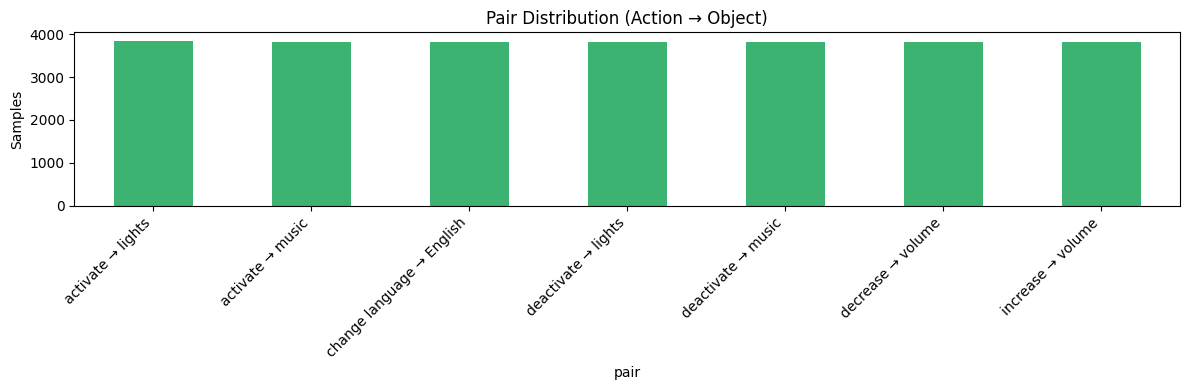

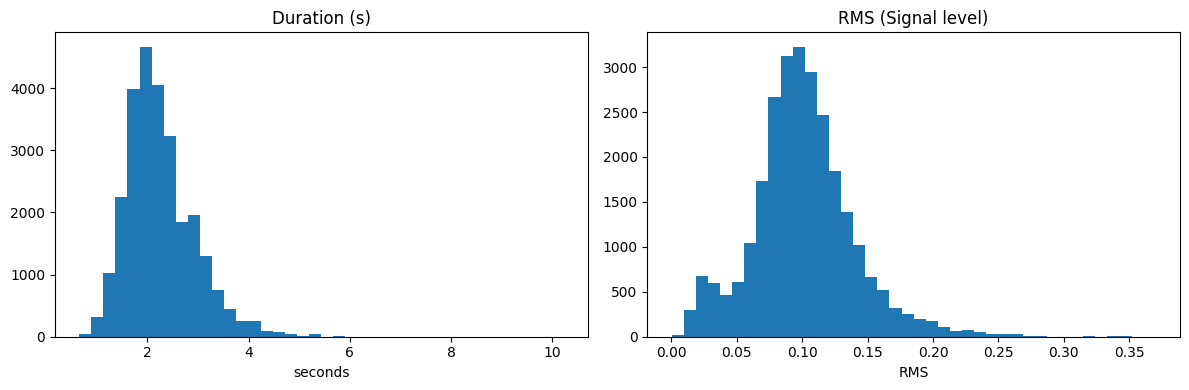

🧹 After dedupe by content+name within each pair: (18222, 13)
💾 Clean file saved to: /kaggle/working/data_qc/train_aug_balanced_dedup.csv


In [49]:
# =========================
# QC للبيانات بعد الـAug + Balance
# =========================
import os, hashlib
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1) حددي ملف الداتا النهائي (بعد الـAug والموازنة)
CSV_PATH = "/kaggle/working/data_final_balanced/train_aug_balanced.csv"  # عدّلي إذا لزم
df = pd.read_csv(CSV_PATH)

# 2) تجهيز أعمدة مساعدة
def file_id(p):
    try:
        return os.path.basename(p)
    except Exception:
        return p

df["audio_id"] = df["full_path"].apply(file_id)
df["pair"] = df["action"] + " → " + df["object"]

print("✅ Loaded:", CSV_PATH)
print("Rows:", len(df))
print("Unique pairs:", df['pair'].nunique())
print(df['pair'].value_counts().sort_index())

# 3) حساب خصائص سريعة (المدة + RMS) للفحص
def audio_stats(path, target_sr=16000):
    try:
        y, sr = librosa.load(path, sr=target_sr, mono=True)
        if y.size == 0:
            return np.nan, np.nan
        dur = len(y) / target_sr
        rms = float(np.sqrt(np.mean(y**2)))
        return dur, rms
    except Exception:
        return np.nan, np.nan

durations = []
rms_vals  = []
print("\n⏱️ Computing duration/RMS (quick scan)...")
for p in tqdm(df["full_path"].tolist()):
    d, r = audio_stats(p)
    durations.append(d)
    rms_vals.append(r)
df["duration_s"] = durations
df["rms"] = rms_vals

# 4) التكرارات بالاسم
name_dups = df.duplicated(subset=["audio_id", "pair"], keep=False)
n_name_dups = name_dups.sum()

# 5) التكرارات بالمحتوى (Hash)
#    بصمة على الصوت بعد تحويله لـ int16 مع قصّه لأقصى 6 ثواني لتسريع الهاش
def audio_hash(path, target_sr=16000, max_sec=6):
    try:
        y, sr = librosa.load(path, sr=target_sr, mono=True)
        if len(y) > target_sr * max_sec:
            y = y[: target_sr * max_sec]
        # Normalize ثم تحويل لـ int16 وثم SHA1
        y = y / (np.max(np.abs(y)) + 1e-8)
        y_i16 = (y * 32767.0).astype(np.int16).tobytes()
        return hashlib.sha1(y_i16).hexdigest()
    except Exception:
        return None

print("\n🔑 Computing content hashes (dedupe by audio content)...")
hashes = []
for p in tqdm(df["full_path"].tolist()):
    hashes.append(audio_hash(p))
df["content_hash"] = hashes

content_dups_mask = df.duplicated(subset=["content_hash", "pair"], keep=False)
n_content_dups = content_dups_mask.sum()

# 6) ملخّص التكرارات
print("\n================ SUMMARY ================")
print(f"Total rows:                    {len(df)}")
print(f"Unique audio filenames:        {df['audio_id'].nunique()}")
print(f"Duplicates by filename+pair:   {int(n_name_dups)}")
print(f"Unique content hashes:         {df['content_hash'].nunique()}")
print(f"Duplicates by content+pair:    {int(n_content_dups)}")
print("========================================\n")

# 7) أمثلة على التكرارات (إن وُجدت)
def show_dup_examples(mask, title, n=10):
    if mask.sum() == 0:
        print(f"✅ No {title} found.")
        return
    print(f"⚠️ {title} examples:")
    display_cols = ["transcription", "action", "object", "pair", "audio_id", "full_path"]
    print(df.loc[mask, display_cols].head(n).to_string(index=False), "\n")

show_dup_examples(name_dups, "name duplicates (same audio_id within same pair)")
show_dup_examples(content_dups_mask, "content duplicates (same audio content within same pair)")

# 8) رسومات تحقق سريعة
plt.figure(figsize=(12,4))
df["pair"].value_counts().sort_index().plot.bar(color="mediumseagreen")
plt.title("Pair Distribution (Action → Object)")
plt.ylabel("Samples")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(df["duration_s"].dropna(), bins=40)
axes[0].set_title("Duration (s)")
axes[0].set_xlabel("seconds")

axes[1].hist(df["rms"].dropna(), bins=40)
axes[1].set_title("RMS (Signal level)")
axes[1].set_xlabel("RMS")

plt.tight_layout()
plt.show()

# 9) (اختياري) إنشاء نسخة نظيفة منزوعة التكرار
#    - نحذف تكرارات المحتوى داخل نفس الزوج (ونحافظ على أول ظهور)
#    - ثم نحذف تكرارات الاسم داخل نفس الزوج لو بقيت
clean_df = (
    df.sort_values(["pair", "content_hash", "audio_id"])
      .drop_duplicates(subset=["pair", "content_hash"], keep="first")
      .drop_duplicates(subset=["pair", "audio_id"], keep="first")
      .reset_index(drop=True)
)

print("🧹 After dedupe by content+name within each pair:", clean_df.shape)

SAVE_DIR = "/kaggle/working/data_qc"
os.makedirs(SAVE_DIR, exist_ok=True)
clean_path = os.path.join(SAVE_DIR, "train_aug_balanced_dedup.csv")
clean_df.drop(columns=["content_hash"], errors="ignore").to_csv(clean_path, index=False)
print("💾 Clean file saved to:", clean_path)


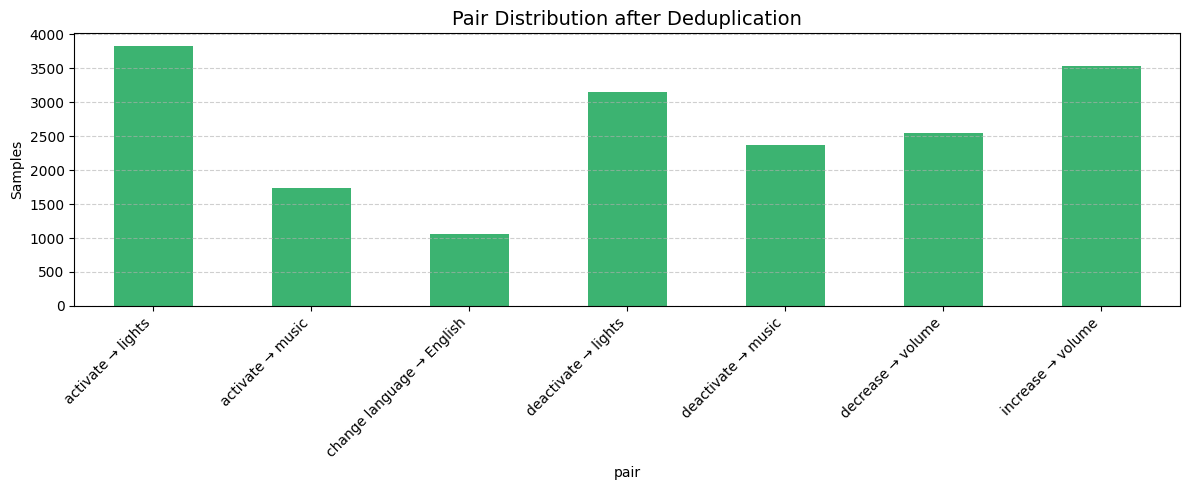

pair
activate → lights            3824
activate → music             1731
change language → English    1057
deactivate → lights          3151
deactivate → music           2375
decrease → volume            2553
increase → volume            3531
Name: count, dtype: int64

Total samples: 18222


In [50]:
import matplotlib.pyplot as plt
import pandas as pd

clean_df = pd.read_csv("/kaggle/working/data_qc/train_aug_balanced_dedup.csv")
clean_df["pair"] = clean_df["action"] + " → " + clean_df["object"]

pair_counts = clean_df["pair"].value_counts().sort_index()

plt.figure(figsize=(12,5))
pair_counts.plot.bar(color='mediumseagreen')
plt.title("Pair Distribution after Deduplication", fontsize=14)
plt.ylabel("Samples")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(pair_counts)
print("\nTotal samples:", len(clean_df))


In [40]:
import librosa
import numpy as np
import soundfile as sf
import os
from tqdm import tqdm

AUG_DIR = "/kaggle/working/augmented_audio"
os.makedirs(AUG_DIR, exist_ok=True)

def augment_audio(y, sr):
    # Normalize
    y = y / np.max(np.abs(y) + 1e-8)

    if np.random.rand() < 0.5:
        # Time shift
        shift = int(np.random.uniform(-0.1, 0.1) * len(y))
        y = np.roll(y, shift)

    if np.random.rand() < 0.5:
        # Pitch shift
        y = librosa.effects.pitch_shift(y, sr, n_steps=np.random.uniform(-1, 1))

    if np.random.rand() < 0.5:
        # Add Gaussian noise
        noise = np.random.randn(len(y)) * 0.005
        y = y + noise

    return y

# تطبيق augmentation على الفئات الصغيرة فقط
for path in tqdm(balanced_df['full_path'].unique()[:100]):  # مثال: أول 100 ملف مبدأيًا
    try:
        y, sr = librosa.load(path, sr=16000)
        y_aug = augment_audio(y, sr)
        out_path = os.path.join(AUG_DIR, os.path.basename(path))
        sf.write(out_path, y_aug, sr)
    except:
        pass


100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ======================================================
# ⚙️ STEP 1: Balance pairs (Action + Object)
# ======================================================
def balance_pairs(df):
    """
    موازنة الأزواج (action, object) بحيث يكون لكل زوج نفس العدد من العينات،
    دون oversampling مفرط.
    """
    groups = df.groupby(['action', 'object'])
    counts = groups.size()
    max_count = int(counts.median())   # استخدام الوسيط بدل الحد الأقصى لتجنب التضخيم
    print(f"Target per pair (median): {max_count}")

    balanced_groups = []
    rng = np.random.default_rng(42)

    for (act, obj), subset in groups:
        n = len(subset)
        if n < max_count:
            diff = max_count - n
            # نضيف عينات مكررة من نفس الفئة بشكل محدود فقط
            sampled = subset.sample(n=diff, replace=True, random_state=rng.integers(0, 9999))
            balanced_groups.append(pd.concat([subset, sampled], ignore_index=True))
        elif n > max_count * 1.5:
            # إذا كانت الفئة ضخمة جدًا، نعمل downsample خفيف
            balanced_groups.append(subset.sample(n=int(max_count*1.2), random_state=42))
        else:
            balanced_groups.append(subset)

    balanced_df = pd.concat(balanced_groups, ignore_index=True)
    print(f"Pair-level balancing done. New size: {len(balanced_df)}")
    return balanced_df

In [36]:
# ======================================================
# 🧮 STEP 3: Apply balancing
# ======================================================
balanced_df = balance_pairs(df)

Target per pair (median): 1744
Pair-level balancing done. New size: 13252


In [37]:
# ======================================================
# 💾 STEP 4: Save balanced dataset
# ======================================================
out_dir = "/kaggle/working/data_final"
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, "mapped_balanced_pairs_final.csv")
balanced_df.to_csv(out_path, index=False)
print(f"Saved final balanced dataset to: {out_path}")

Saved final balanced dataset to: /kaggle/working/data_final/mapped_balanced_pairs_final.csv



📊 Pair Counts (after balancing):
action           object 
activate         lights     2092
increase         volume     2092
deactivate       lights     2092
change language  English    1744
activate         music      1744
deactivate       music      1744
decrease         volume     1744
dtype: int64

إجمالي عدد الأزواج المختلفة: 7
إجمالي عدد العينات: 13252


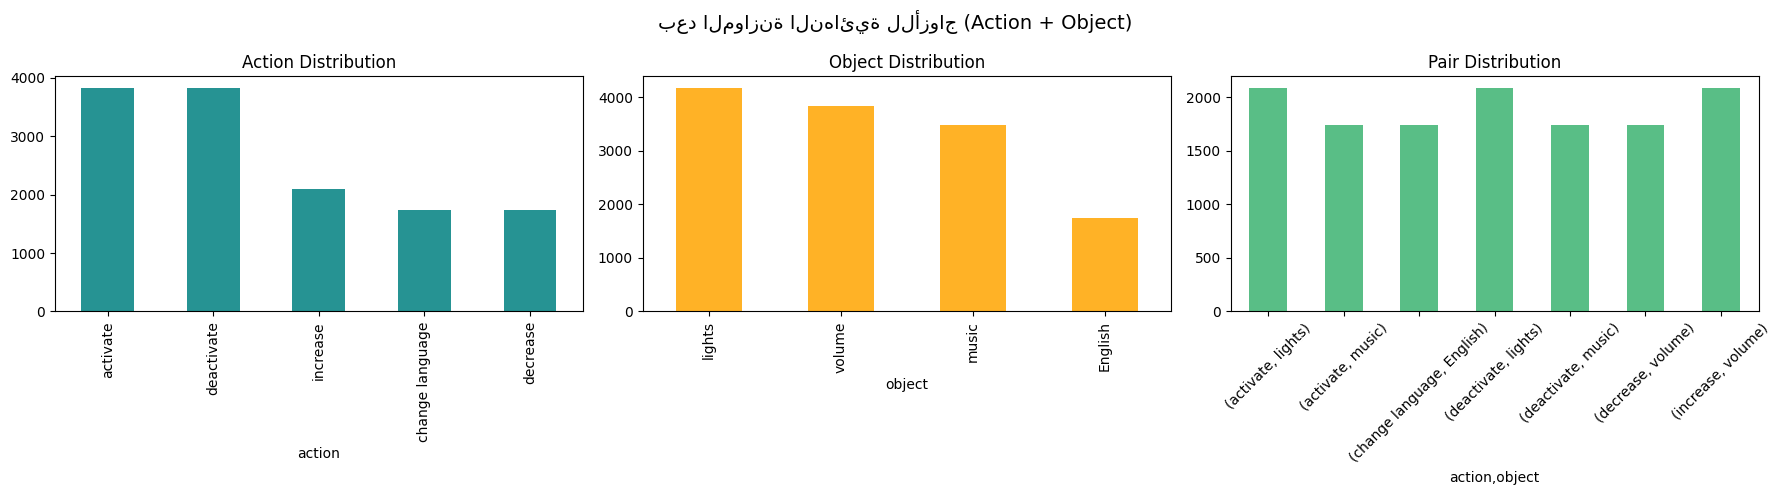

In [38]:
# ======================================================
# 📊 STEP 5: Summary statistics
# ======================================================
pair_counts = balanced_df.groupby(['action', 'object']).size().sort_values(ascending=False)
print("\n📊 Pair Counts (after balancing):")
print(pair_counts)
print("\nإجمالي عدد الأزواج المختلفة:", len(pair_counts))
print("إجمالي عدد العينات:", len(balanced_df))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("بعد الموازنة النهائية للأزواج (Action + Object)", fontsize=14)

# توزيع الـ Actions
balanced_df["action"].value_counts().plot.bar(ax=axes[0], color='teal', alpha=0.85)
axes[0].set_title("Action Distribution")

# توزيع الـ Objects
balanced_df["object"].value_counts().plot.bar(ax=axes[1], color='orange', alpha=0.85)
axes[1].set_title("Object Distribution")

# توزيع الأزواج
pair_counts.sort_index().plot.bar(ax=axes[2], color='mediumseagreen', alpha=0.85)
axes[2].set_title("Pair Distribution")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [39]:
dup_check = balanced_df['full_path'].duplicated().sum()
print(f"🔍 عدد الملفات الصوتية المكررة بعد الموازنة: {dup_check}")


🔍 عدد الملفات الصوتية المكررة بعد الموازنة: 2311


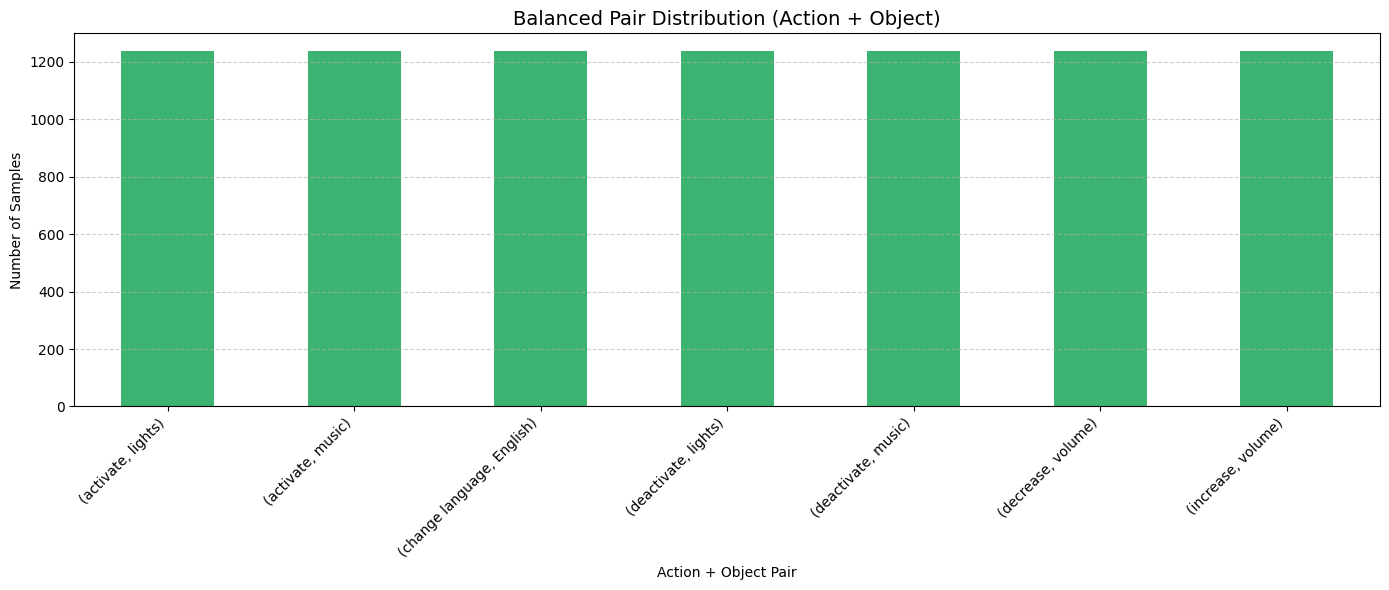

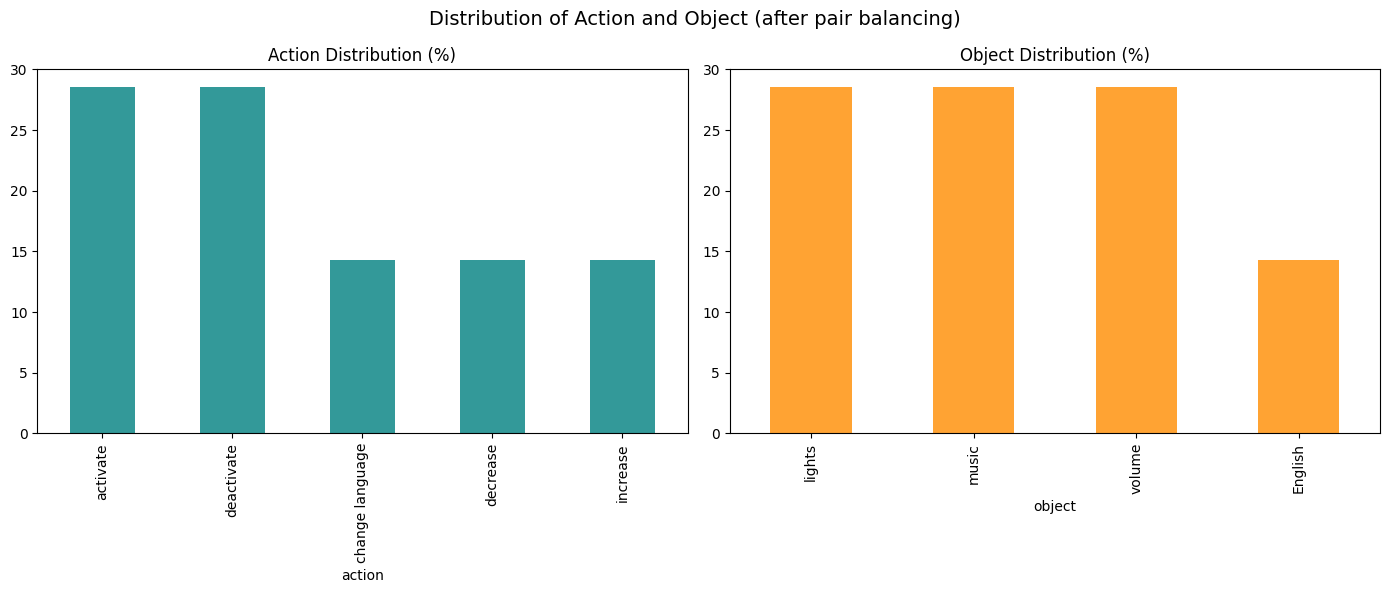

In [28]:
# ======================================================
# 📈 STEP 6: Visualize the distributions
# ======================================================
plt.figure(figsize=(14, 6))
pair_counts.plot.bar(color='mediumseagreen')
plt.title("Balanced Pair Distribution (Action + Object)", fontsize=14)
plt.ylabel("Number of Samples")
plt.xlabel("Action + Object Pair")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ======================================================
# 🔹 STEP 7: Compare Action/Object Distributions
# ======================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Distribution of Action and Object (after pair balancing)", fontsize=14)

df_balanced['action'].value_counts(normalize=True).mul(100).plot.bar(
    ax=axes[0], color='teal', alpha=0.8)
axes[0].set_title("Action Distribution (%)")

df_balanced['object'].value_counts(normalize=True).mul(100).plot.bar(
    ax=axes[1], color='darkorange', alpha=0.8)
axes[1].set_title("Object Distribution (%)")

plt.tight_layout()
plt.show()

In [9]:
# ⚖️ STEP 7: موازنة الأزواج (action + object)
# ======================================================
def balance_pairs(df):
    groups = df.groupby(["action", "object"])
    max_count = groups.size().max()
    new_rows = []
    print(f"Target per pair: {max_count}")

    for (act, obj), subset in groups:
        count = len(subset)
        if count < max_count:
            diff = max_count - count
            for i in range(diff):
                row = subset.sample(n=1, random_state=np.random.randint(0, 9999)).iloc[0]
                new_rows.append(row)

    balanced_df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    print(f"Pair-level balancing done. New size: {len(balanced_df)}")
    return balanced_df

balanced_df = balance_pairs(df)

balanced_path = "/kaggle/working/data_final/mapped_balanced_pairs.csv"
balanced_df.to_csv(balanced_path, index=False)
print(f"💾 Saved balanced pairs to: {balanced_path}")

Target per pair: 3615
Pair-level balancing done. New size: 25305
💾 Saved balanced pairs to: /kaggle/working/data_final/mapped_balanced_pairs.csv


In [10]:
# ======================================================
# ✂️ STEP 8: تقسيم البيانات (train / valid / test)
# ======================================================
train_df, temp_df = train_test_split(
    balanced_df, test_size=0.3, random_state=42, stratify=balanced_df[["action", "object"]]
)
valid_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df[["action", "object"]]
)

print(" Dataset split complete:")
print(f"Train: {train_df.shape}")
print(f"Valid: {valid_df.shape}")
print(f"Test : {test_df.shape}")

split_dir = "/kaggle/working/data_final/splits"
os.makedirs(split_dir, exist_ok=True)

train_df.to_csv(os.path.join(split_dir, "train_final.csv"), index=False)
valid_df.to_csv(os.path.join(split_dir, "valid_final.csv"), index=False)
test_df.to_csv(os.path.join(split_dir, "test_final.csv"), index=False)
print(f"Saved final splits to: {split_dir}")

 Dataset split complete:
Train: (17713, 8)
Valid: (3796, 8)
Test : (3796, 8)
Saved final splits to: /kaggle/working/data_final/splits


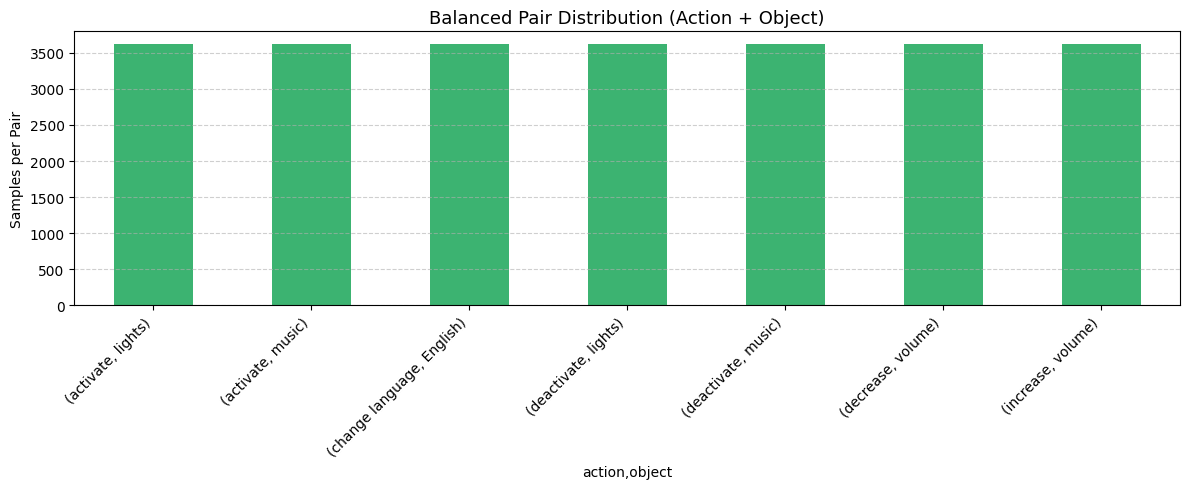

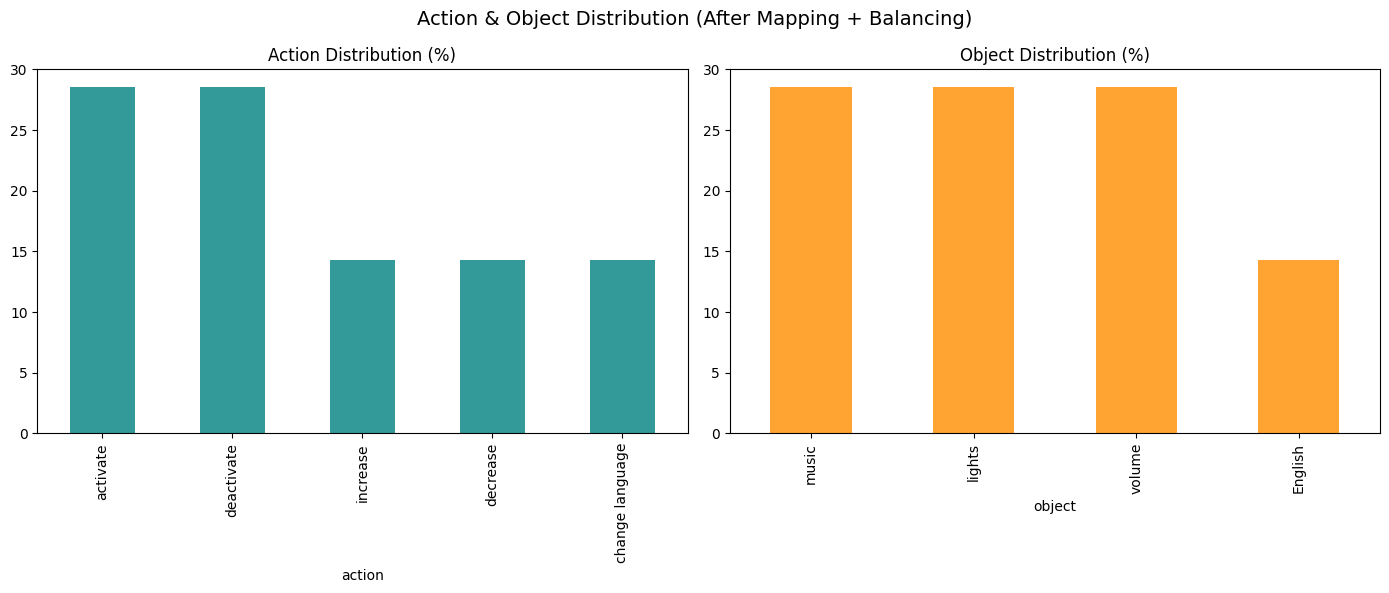

In [11]:
# ======================================================
# 📊 STEP 9: رسم التوزيعات النهائية
# ======================================================
pair_counts = balanced_df.groupby(["action", "object"]).size().sort_values(ascending=False)
plt.figure(figsize=(12, 5))
pair_counts.plot.bar(color="mediumseagreen")
plt.title("Balanced Pair Distribution (Action + Object)", fontsize=13)
plt.ylabel("Samples per Pair")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Action & Object Distribution (After Mapping + Balancing)", fontsize=14)

balanced_df["action"].value_counts(normalize=True).mul(100).plot.bar(ax=axes[0], color="teal", alpha=0.8)
axes[0].set_title("Action Distribution (%)")

balanced_df["object"].value_counts(normalize=True).mul(100).plot.bar(ax=axes[1], color="darkorange", alpha=0.8)
axes[1].set_title("Object Distribution (%)")

plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import os

# تحديد المسار إلى الملف الأخير
data_path = "/kaggle/input/data-final/data_final/mapped_balanced_pairs_cleaned.csv"

# قراءة البيانات
df = pd.read_csv(data_path)
print("Dataset Loaded Successfully")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3))

Dataset Loaded Successfully
Shape: (25305, 5)
Columns: ['path', 'transcription', 'action', 'object', 'full_path']
                                                path         transcription  \
0  wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-1...                Resume   
1  wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-1...    Turn the lights on   
2  wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-1...  Switch on the lights   

     action  object                                          full_path  
0  activate   music  /kaggle/input/fluent-speech-commands/fluent_sp...  
1  activate  lights  /kaggle/input/fluent-speech-commands/fluent_sp...  
2  activate  lights  /kaggle/input/fluent-speech-commands/fluent_sp...  


In [3]:
if 'full_path' in df.columns:
    audio_paths = df['full_path'].tolist()
else:
    # في حال فقط 'path' موجودة نكملها من المسار الجذر لمجموعة البيانات
    base_audio_dir = "/kaggle/input/fluent-speech-commands"  # عدّليها حسب اسم داتاست الصوت
    df['full_path'] = df['path'].apply(lambda p: os.path.join(base_audio_dir, p))
    audio_paths = df['full_path'].tolist()

print(f"Total audio files ready: {len(audio_paths)}")

Total audio files ready: 25305


In [4]:
# حساب عدد المسارات الفريدة
unique_files = df['full_path'].nunique()
total_files = len(df)

print(f"Total rows in dataset: {total_files}")
print(f"Unique audio files: {unique_files}")
print(f"Duplicated entries: {total_files - unique_files}")


Total rows in dataset: 25305
Unique audio files: 14241
Duplicated entries: 11064


قبل أي تنظيف: (14241, 10)
بعد إزالة التكرارات داخل الأزواج: (14241, 10)

توزيع الأزواج بعد الـdedupe:
pair
activate → lights            3615
activate → music              912
change language → English     446
deactivate → lights          2702
deactivate → music           1563
decrease → volume            1744
increase → volume            3259
Name: count, dtype: int64

بعد الموازنة: (25305, 10)
pair
activate → lights            3615
activate → music             3615
change language → English    3615
deactivate → lights          3615
deactivate → music           3615
decrease → volume            3615
increase → volume            3615
Name: count, dtype: int64

حُفظ الملف المتوازن في: /kaggle/working/data_final/mapped_balanced_pairs_final.csv


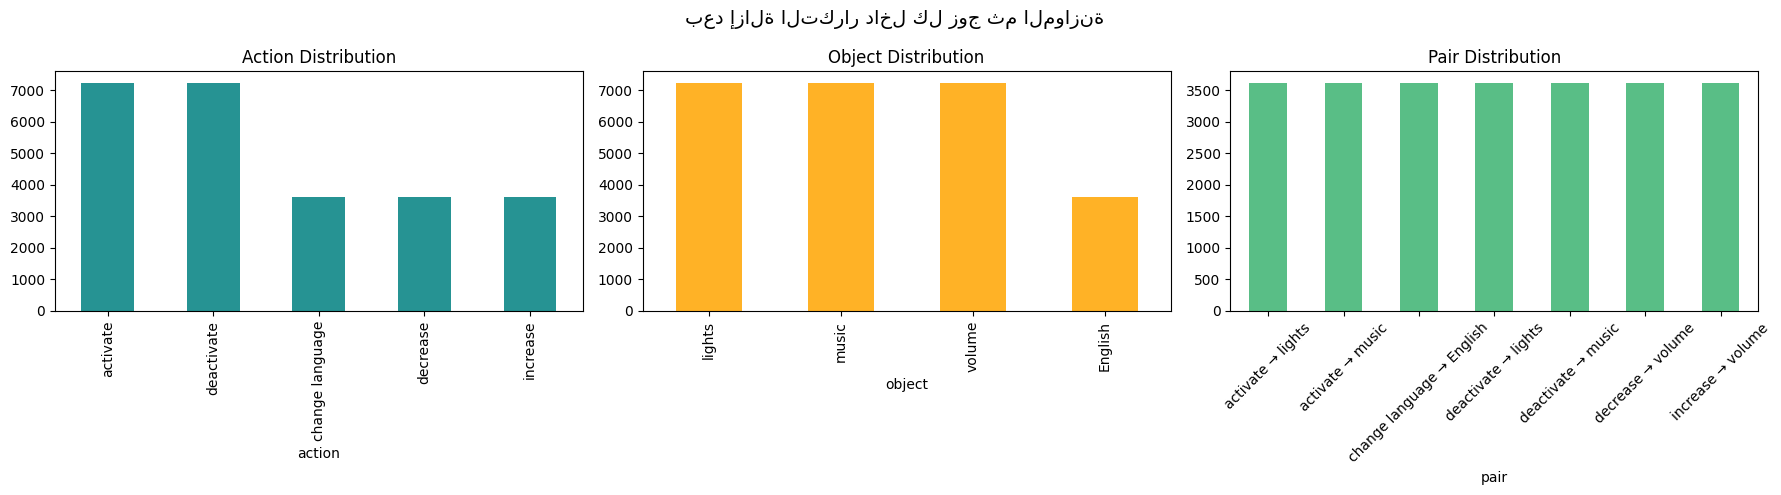

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) تحميل الملف الموحّد بعد المابينغ (قبل إزالة التكرارات)
df = pd.read_csv("/kaggle/input/data-final/data_final/mapped_clean_ready.csv")

# مساعدة: معرّف للملف الصوتي (اسم الملف فقط)
def file_id(p):
    try:
        return os.path.basename(p)
    except Exception:
        return p

df["pair"] = df["action"] + " → " + df["object"]
df["audio_id"] = df["full_path"].apply(file_id)

print("قبل أي تنظيف:", df.shape)

# 2) إزالة التكرارات داخل كل زوج فقط (نحافظ على التوازن النسبي)
#    أي إذا كان عندي نفس audio_id مكرر ضمن نفس الزوج، منحتفظ بواحد
dedup_df = (
    df.sort_values(["pair", "audio_id"])
      .drop_duplicates(subset=["pair", "audio_id"], keep="first")
      .reset_index(drop=True)
)

print("بعد إزالة التكرارات داخل الأزواج:", dedup_df.shape)

# 3) فحص توزيع الأزواج بعد إزالة التكرارات
pair_counts = dedup_df["pair"].value_counts().sort_index()
print("\nتوزيع الأزواج بعد الـdedupe:")
print(pair_counts)

# 4) موازنة الأزواج: upsample أو downsample
def balance_pairs(df_pairs, strategy="upsample", target=None, random_state=42):
    """
    strategy: 'upsample' لرفع المجموعات الصغيرة إلى الهدف
              'downsample' لخفض المجموعات الكبيرة إلى الهدف
    target:   إذا None:
                - upsample → نستخدم الحد الأقصى
                - downsample → نستخدم الحد الأدنى
    """
    rng = np.random.default_rng(random_state)
    groups = list(df_pairs.groupby("pair"))
    counts = df_pairs["pair"].value_counts()

    if target is None:
        target = counts.max() if strategy == "upsample" else counts.min()

    balanced = []
    for pair_name, g in groups:
        n = len(g)
        if strategy == "upsample" and n < target:
            # نكرر بعينة مع إرجاع (بدون Aug)
            idx = rng.integers(low=0, high=n, size=target - n)
            balanced.append(pd.concat([g, g.iloc[idx]], ignore_index=True))
        elif strategy == "downsample" and n > target:
            balanced.append(g.sample(n=target, random_state=random_state))
        else:
            balanced.append(g)
    return pd.concat(balanced, ignore_index=True)

# اختاري الاستراتيجية التي تناسبك:
# - لو بدك تحافظي على أكبر حجم ممكن للداتا: استخدمي upsample
# - لو بدك حجم موحّد وصغير: downsample
balanced_df = balance_pairs(dedup_df, strategy="upsample")  # أو "downsample"

print("\nبعد الموازنة:", balanced_df.shape)
print(balanced_df["pair"].value_counts())

# 5) حفظ نسخة نظيفة ومتوازنة
out_dir = "/kaggle/working/data_final"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "mapped_balanced_pairs_final.csv")
balanced_df.drop(columns=["audio_id"], errors="ignore").to_csv(out_path, index=False)
print("\nحُفظ الملف المتوازن في:", out_path)

# 6) رسوم التحقق السريعة
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("بعد إزالة التكرار داخل كل زوج ثم الموازنة", fontsize=14)

balanced_df["action"].value_counts().plot.bar(ax=axes[0], color='teal', alpha=0.85)
axes[0].set_title("Action Distribution")

balanced_df["object"].value_counts().plot.bar(ax=axes[1], color='orange', alpha=0.85)
axes[1].set_title("Object Distribution")

(balanced_df["pair"].value_counts().sort_index()
 .plot.bar(ax=axes[2], color='mediumseagreen', alpha=0.85))
axes[2].set_title("Pair Distribution")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


✅ Dataset loaded successfully!
Shape: (10767, 8)

Columns: ['Unnamed: 0', 'path', 'speakerId', 'transcription', 'action', 'object', 'location', 'full_path']

Sample rows:
   Unnamed: 0                                               path  \
0        1136  wavs/speakers/k5bqyxx2lzIbrlg9/932d63d0-4526-1...   
1       21070  wavs/speakers/Xygv5loxdZtrywr9/3546dbd0-452a-1...   
2       15374  wavs/speakers/R3mexpM2YAtdPbL7/00914ac0-44fc-1...   
3         955  wavs/speakers/9MX3AgZzVgCw4W4j/56a81290-4501-1...   
4       21078  wavs/speakers/Xygv5loxdZtrywr9/5c9c4940-452a-1...   

          speakerId                        transcription    action  object  \
0  k5bqyxx2lzIbrlg9        Switch on the bathroom lights  activate  lights   
1  Xygv5loxdZtrywr9  Switch on the lights in the bedroom  activate  lights   
2  R3mexpM2YAtdPbL7                   Bathroom lights on  activate  lights   
3  9MX3AgZzVgCw4W4j         Switch the bedroom lights on  activate  lights   
4  Xygv5loxdZtrywr9           

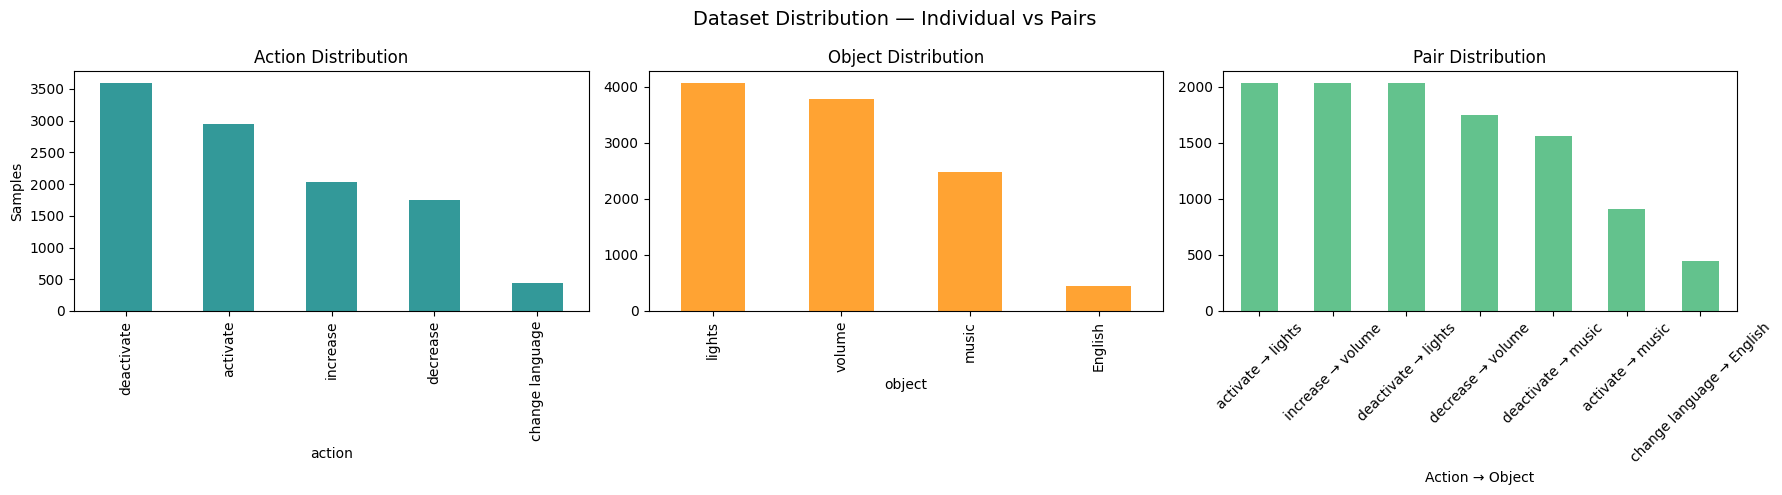


📊 Relative frequencies (%):
                 Action %  Object %
action                             
deactivate          33.41       0.0
activate            27.36       0.0
increase            18.89       0.0
decrease            16.20       0.0
change language      4.14       0.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# ======================================================
# 🧾 تحميل البيانات
# ======================================================
data_path = "/kaggle/working/data_final/mapped_balanced_pairs_unique.csv"  # عدّلي المسار إذا مختلف
df = pd.read_csv(data_path)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample rows:")
print(df.head(5))
print("="*60)

# ======================================================
# 📊 عرض التوزيع العام
# ======================================================
print("\n🔹 Distribution per action:")
print(df["action"].value_counts())

print("\n🔹 Distribution per object:")
print(df["object"].value_counts())

# ======================================================
# 🧩 إنشاء عمود للأزواج
# ======================================================
df["pair"] = df["action"] + " → " + df["object"]

print("\n🔹 Distribution per (action, object) pair:")
pair_counts = df["pair"].value_counts()
print(pair_counts.head(10))
print(f"\nإجمالي عدد الأزواج المختلفة: {len(pair_counts)}")

# ======================================================
# 📈 رسم التوزيع
# ======================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Dataset Distribution — Individual vs Pairs", fontsize=14)

# 1️⃣ توزيع الأفعال
df["action"].value_counts().plot.bar(ax=axes[0], color='teal', alpha=0.8)
axes[0].set_title("Action Distribution")
axes[0].set_ylabel("Samples")

# 2️⃣ توزيع الكائنات
df["object"].value_counts().plot.bar(ax=axes[1], color='darkorange', alpha=0.8)
axes[1].set_title("Object Distribution")

# 3️⃣ توزيع الأزواج
pair_counts.plot.bar(ax=axes[2], color='mediumseagreen', alpha=0.8)
axes[2].set_title("Pair Distribution")
axes[2].set_xlabel("Action → Object")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ======================================================
# 🔍 نسبة كل فئة من المجموع الكلي
# ======================================================
print("\n📊 Relative frequencies (%):")
action_pct = df["action"].value_counts(normalize=True).mul(100).round(2)
object_pct = df["object"].value_counts(normalize=True).mul(100).round(2)
pair_pct = df["pair"].value_counts(normalize=True).mul(100).round(2)

summary = pd.DataFrame({
    "Action %": action_pct,
    "Object %": object_pct.reindex(action_pct.index).fillna(0)
}).fillna(0)

print(summary)
